In [1]:
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [39]:
data_train_raw, labels_train, data_test_raw, labels_test = split(*load_all_data('dataset'), seed=69421)

print(f'{data_train_raw.shape}')
print(f'{labels_train.shape}')
print(f'{data_test_raw.shape}')
print(f'{labels_test.shape}')

data_train, data_test = data_train_raw, data_test_raw

(960, 100, 548)
(960, 100)
(240, 100, 548)
(240, 100)


In [40]:
data_train, data_test = data_train_raw, data_test_raw

In [28]:
# data_train, data_test = remove_correlated_columns(data_train, data_test)
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [5]:
# N_COMPONENTS = 50
# 
# data_train_raw_shape = data_train_raw.shape
# data_test_raw_shape = data_test_raw.shape
# 
# data_train_flat = data_train_raw.reshape(-1, data_train_raw.shape[-1])
# data_test_flat = data_test_raw.reshape(-1, data_test_raw.shape[-1])
# 
# pca = sklearn.decomposition.PCA(n_components=N_COMPONENTS)
# pca.fit(data_train_flat)
# 
# data_train_downprojected = pca.transform(data_train_flat)
# data_test_downprojected = pca.transform(data_test_flat)
# 
# data_train = np.reshape(data_train_downprojected, (data_train_raw_shape[0], data_train_raw_shape[1], N_COMPONENTS))
# data_test = np.reshape(data_test_downprojected, (data_test_raw_shape[0], data_test_raw_shape[1], N_COMPONENTS))
# 
# print(f'{data_train.shape}')
# print(f'{data_test.shape}')

In [27]:
# set_random_seed(42)
# subset_indices = [
#     bird * data_train.shape[0] // 6 + sample_nr
#     for bird in range(6)
#     for sample_nr in range(10)
# ]
# # data_train_subset = data_train[subset_indices, :, :]
# # labels_train_subset = labels_train[subset_indices, :]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
# print(data_train_subset.shape)
# print(labels_train_subset.shape)

# Hyper Parameters

In [41]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_train.shape[-1],
    out_features=NUM_CLASSES,
    
    self_attention=True,
    d_model=60,
    num_heads=12,
    stack_size=1,
    attention_dropout=0.1,
    
    in_linear_hidden_out_features=[48, 48],
    out_linear_hidden_out_features=[64],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.0,
)

In [42]:
def create_training_hyper_parameters(epoch_multiplier: float, lr_multiplier: float):
    return TrainingHyperParameters(
        batch_size=32,

        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(100 * epoch_multiplier),
        
        lr=1e-2 * lr_multiplier,
        lr_scheduler_milestones=[int(m * epoch_multiplier) for m in [10, 20, 40, 60, 80]],
        lr_scheduler_gamma=0.5,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Training fold 0
Training AttentionClassifier with 50643 parameters
train label counts = [61639, 4059, 6705, 5828, 1641, 3405, 3123]
loss weights = [1.0, 15.19, 9.19, 10.58, 37.56, 18.1, 19.74]
eval label counts = [6828, 410, 614, 739, 235, 412, 362]
eval loss weights = [1.0, 16.65, 11.12, 9.24, 29.06, 16.57, 18.86]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000502, num_samples = 86400, num_correct = 12419, acc = 0.143738, bacc = 0.257428
Evaluation Epoch   1/35 : avg_loss = 0.000499, num_samples =  9600, num_correct =  2836, acc = 0.295417, bacc = 0.466327
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000303, num_samples = 86400, num_correct = 22015, acc = 0.254803, bacc = 0.606632
Evaluation Epoch   2/35 : avg_loss = 0.000509, num_samples =  9600, num_correct =  2934, acc = 0.305625, bacc = 0.778917
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000193, num_samples = 86400, num_correct = 34299, acc = 0.396979, bacc = 0.765639
Evaluation Epoch   3/35 : avg_loss = 0.000334, num

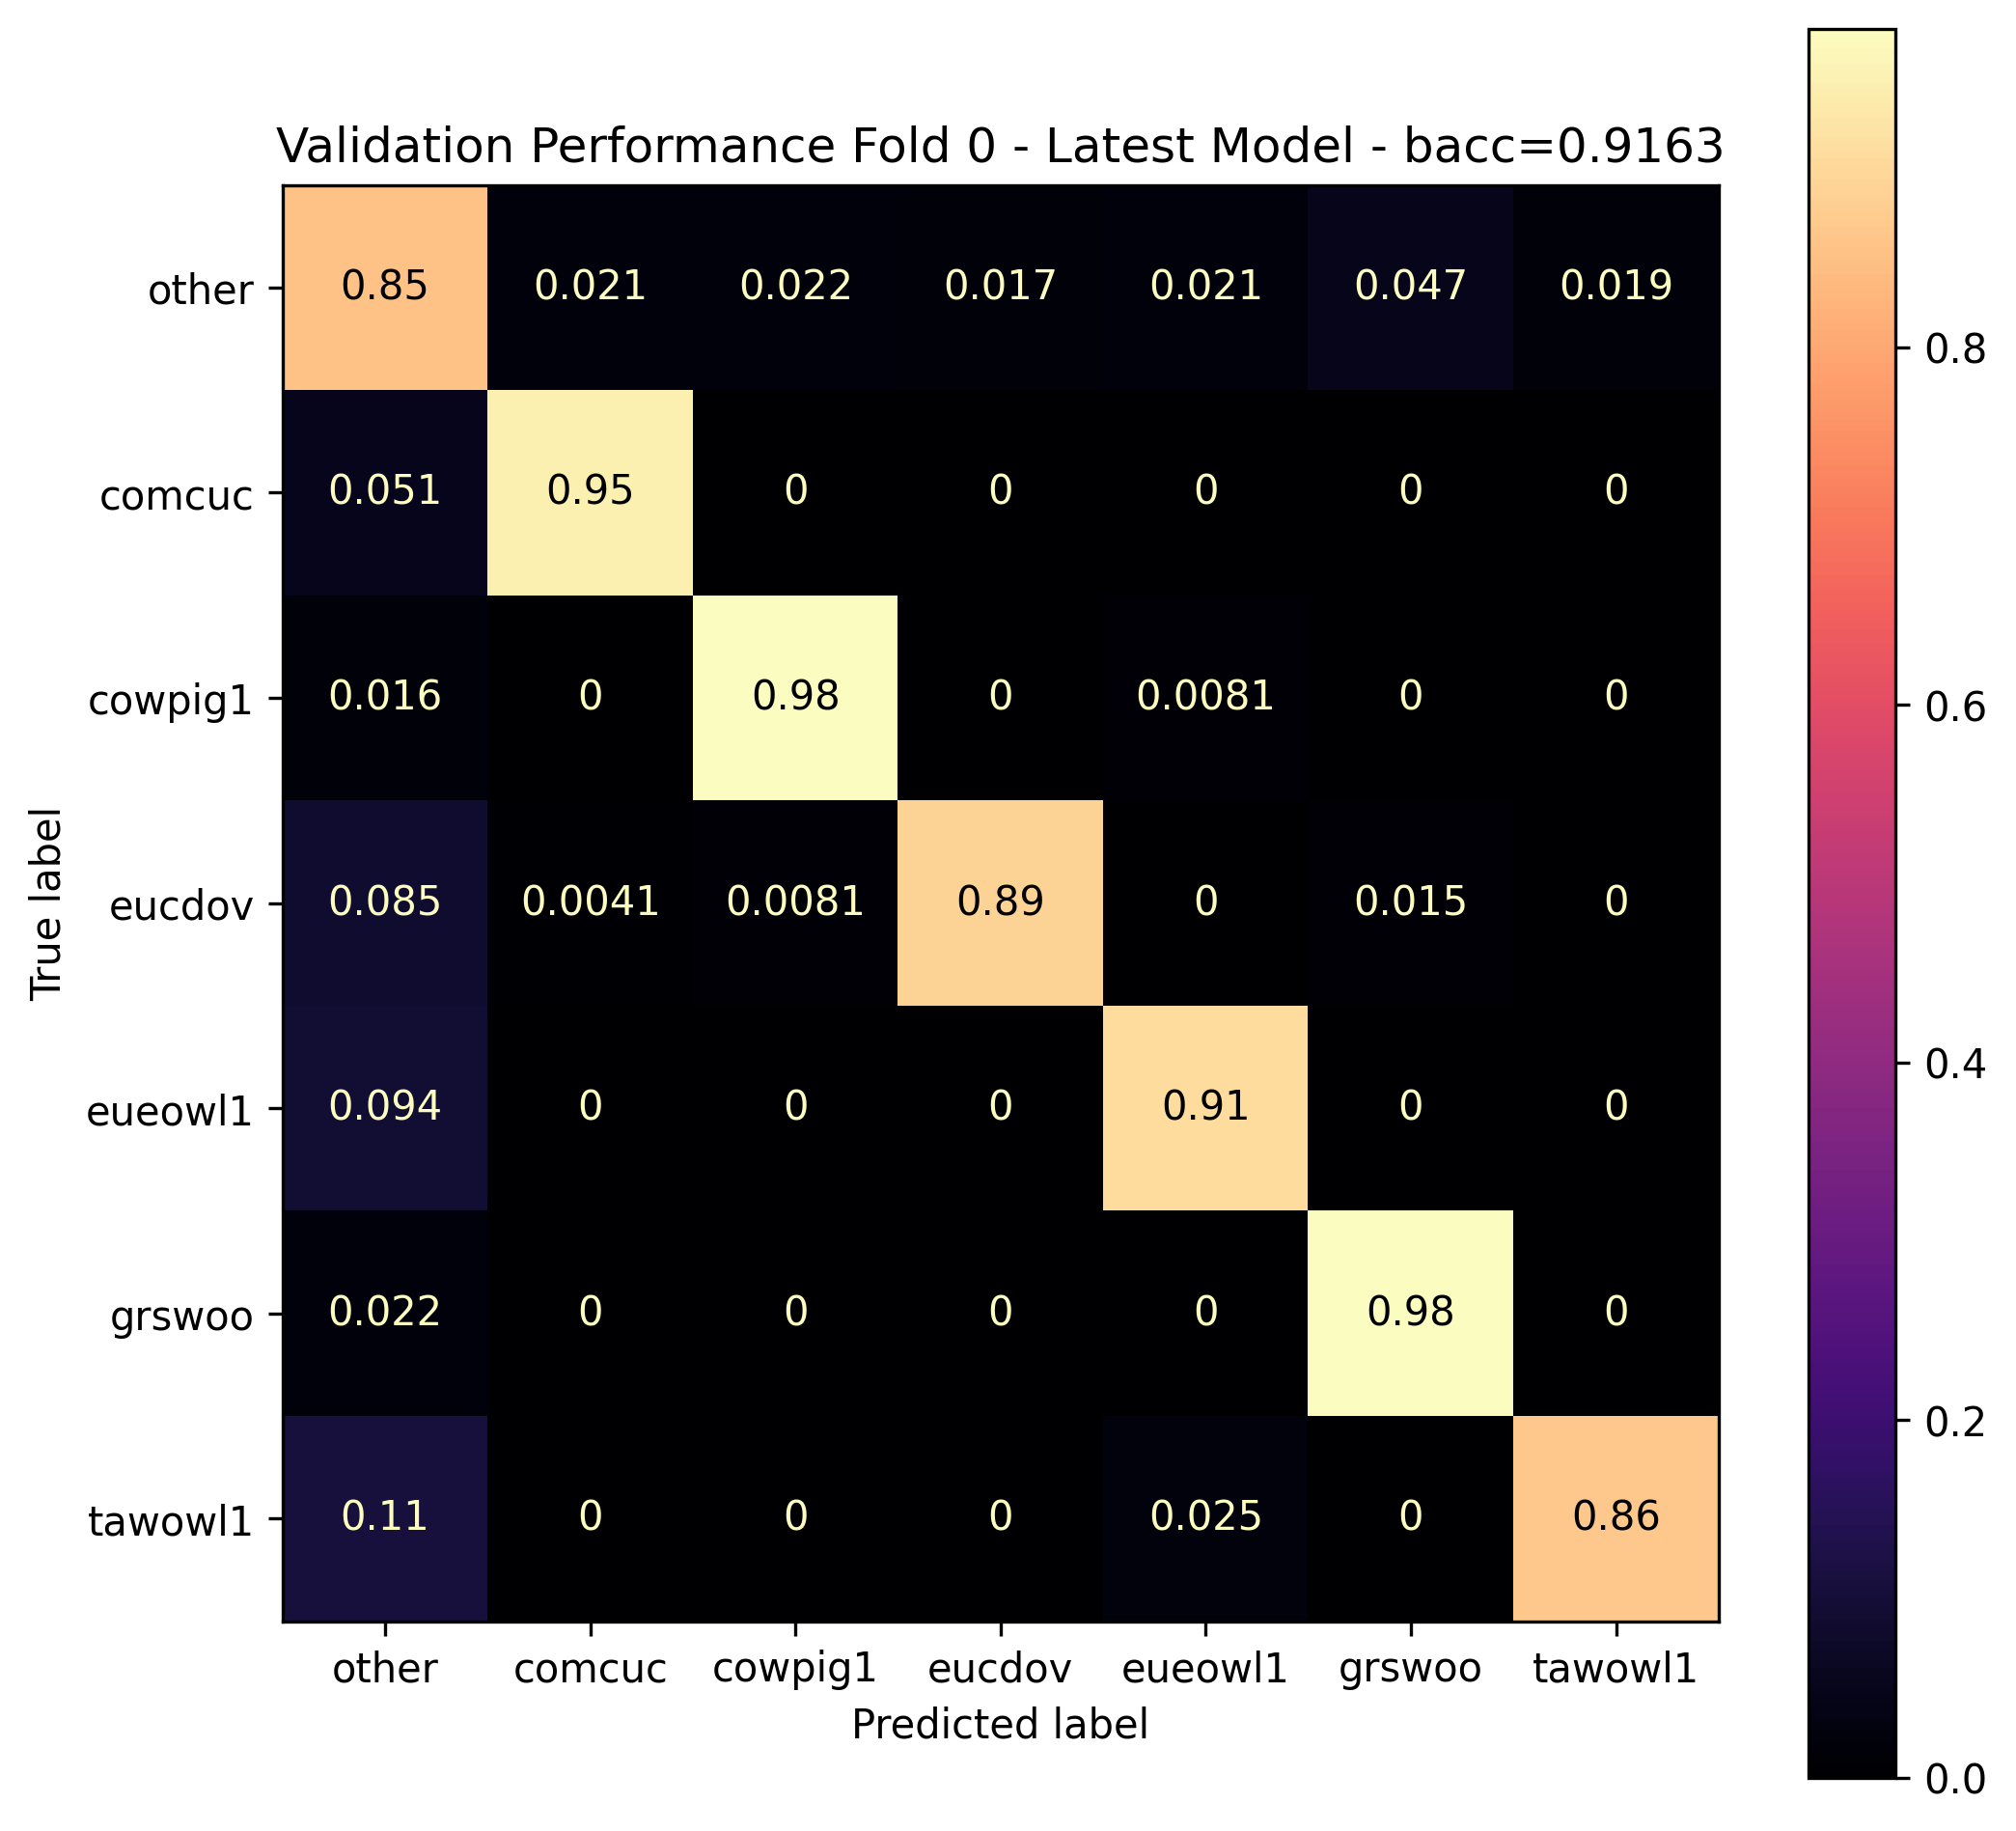

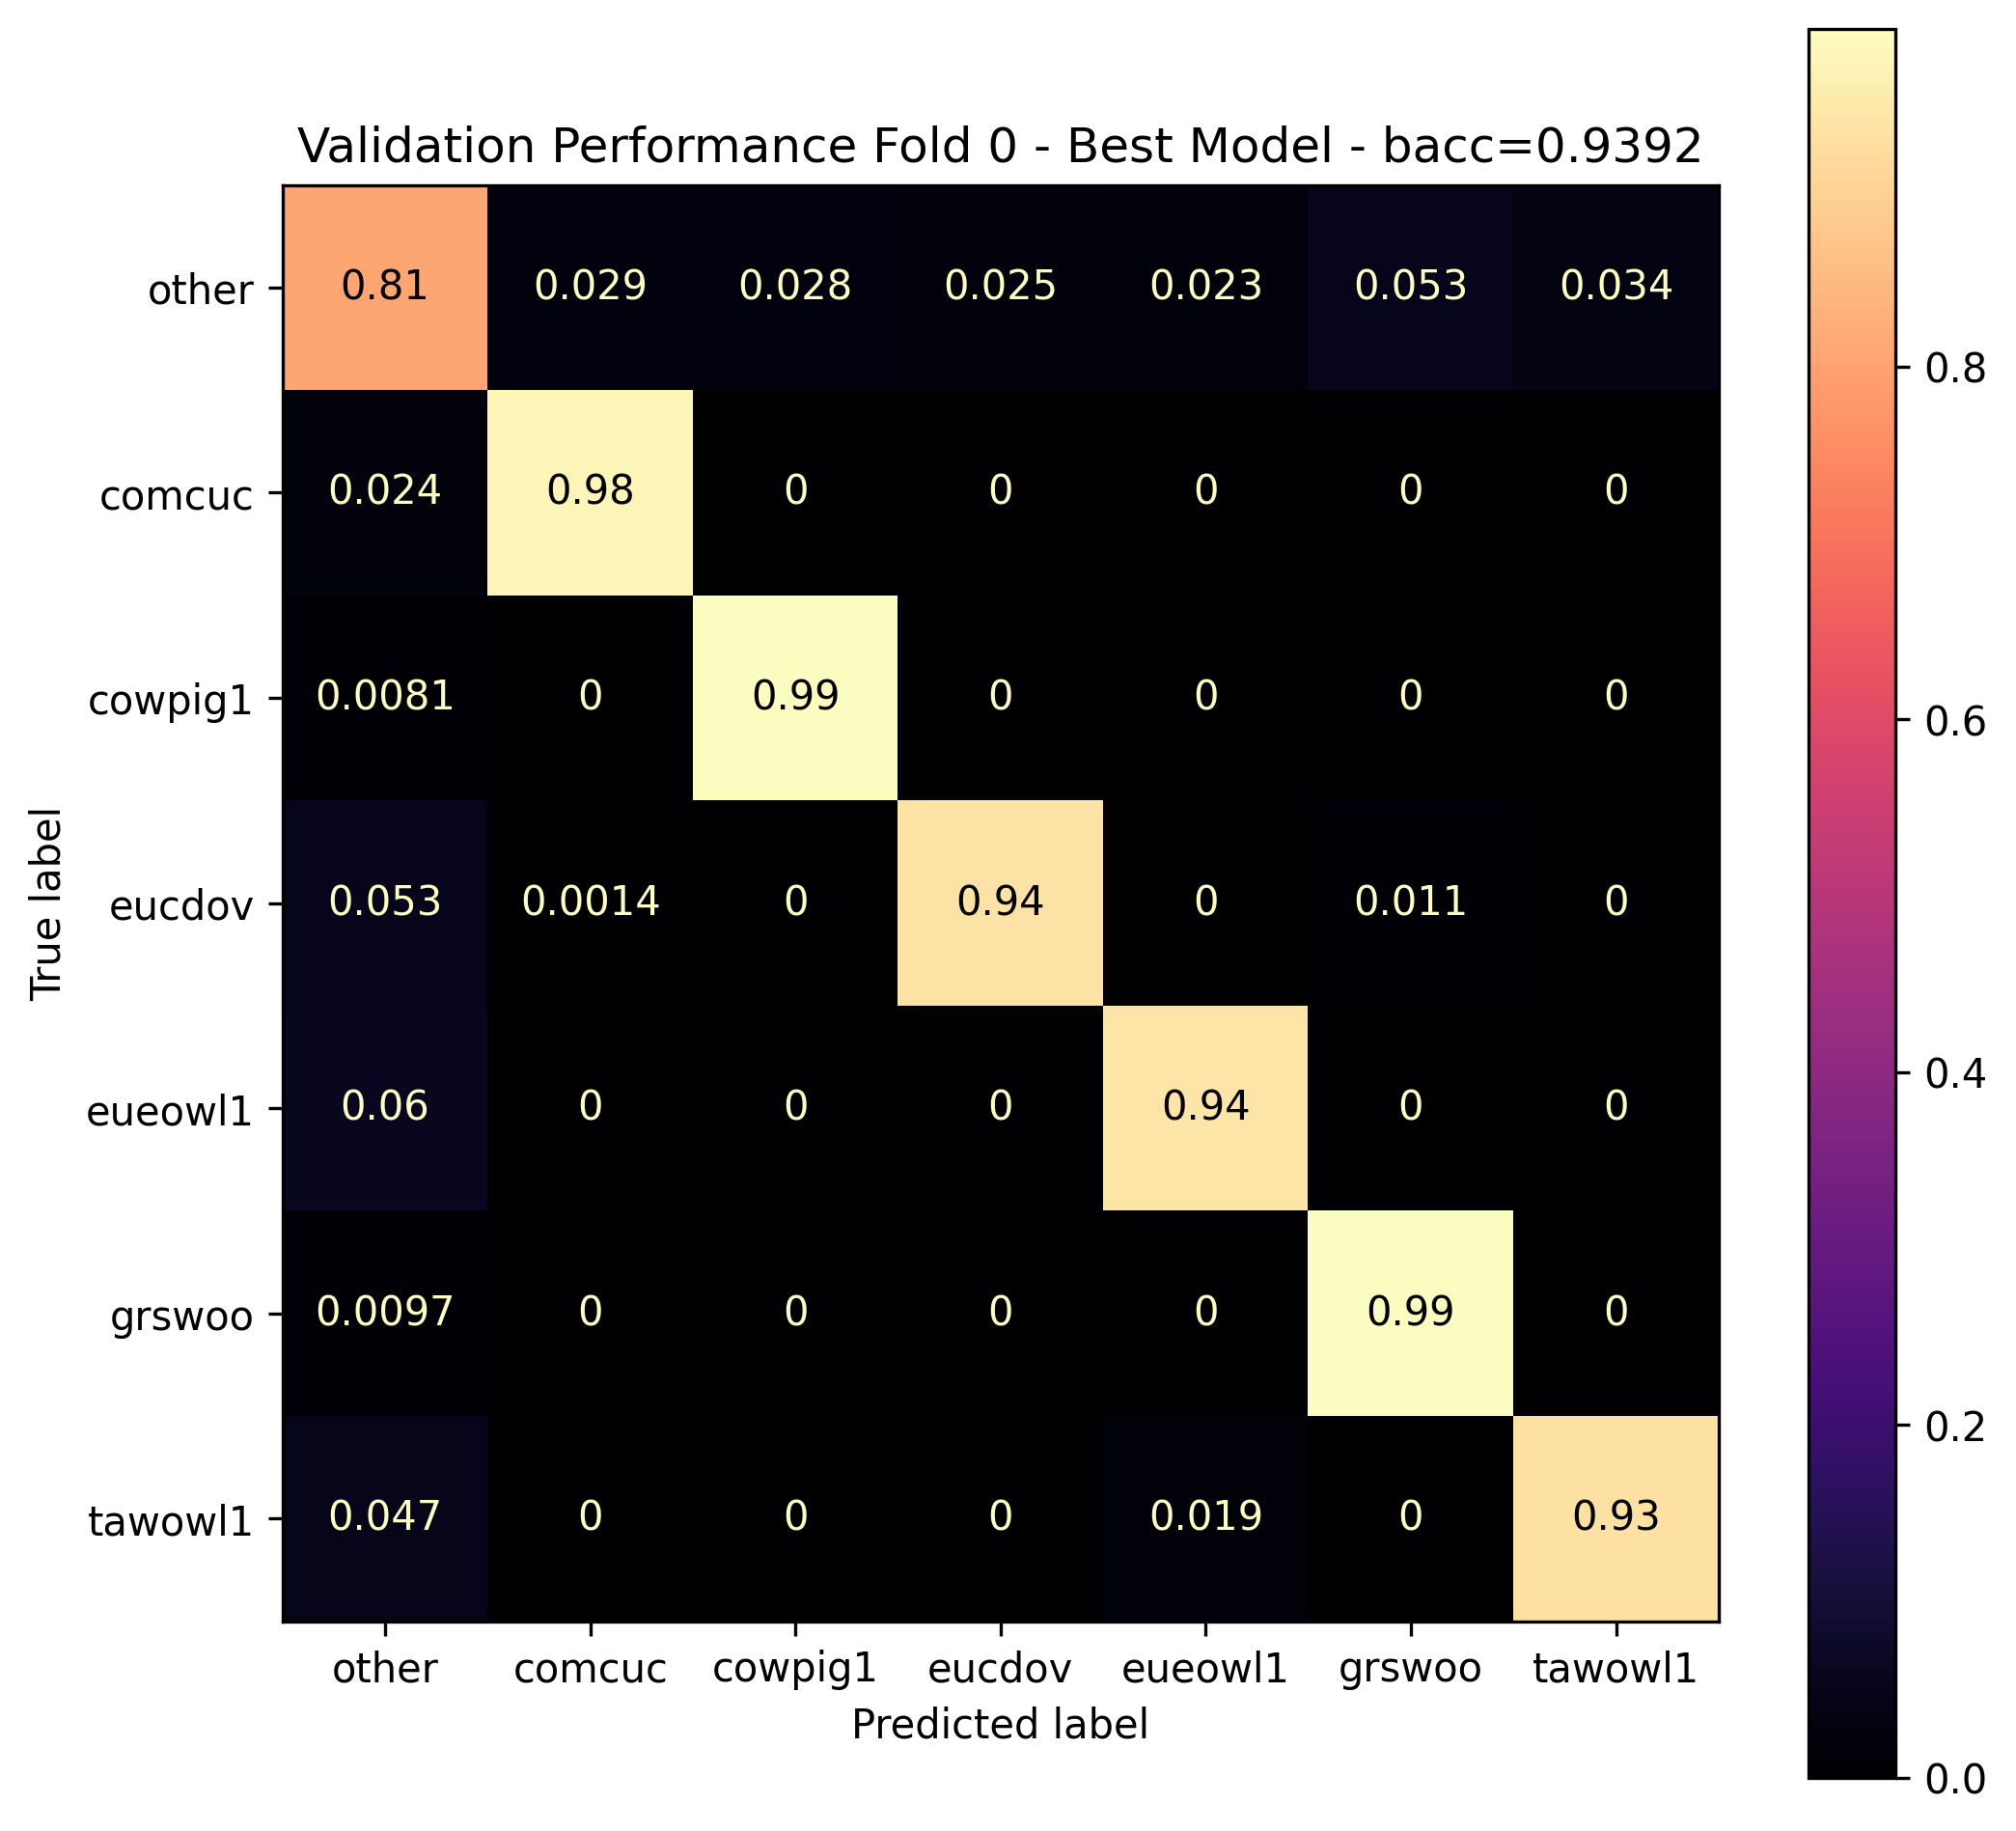

Training fold 1
Training AttentionClassifier with 50643 parameters
train label counts = [61512, 3993, 6746, 5981, 1735, 3332, 3101]
loss weights = [1.0, 15.4, 9.12, 10.28, 35.45, 18.46, 19.84]
eval label counts = [6955, 476, 573, 586, 141, 485, 384]
eval loss weights = [1.0, 14.61, 12.14, 11.87, 49.33, 14.34, 18.11]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000521, num_samples = 86400, num_correct = 13614, acc = 0.157569, bacc = 0.300526
Evaluation Epoch   1/35 : avg_loss = 0.000564, num_samples =  9600, num_correct =  1681, acc = 0.175104, bacc = 0.489071
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000326, num_samples = 86400, num_correct = 19592, acc = 0.226759, bacc = 0.562843
Evaluation Epoch   2/35 : avg_loss = 0.000468, num_samples =  9600, num_correct =  2514, acc = 0.261875, bacc = 0.664351
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000197, num_samples = 86400, num_correct = 39837, acc = 0.461076, bacc = 0.762087
Evaluation Epoch   3/35 : avg_loss = 0.000291, nu

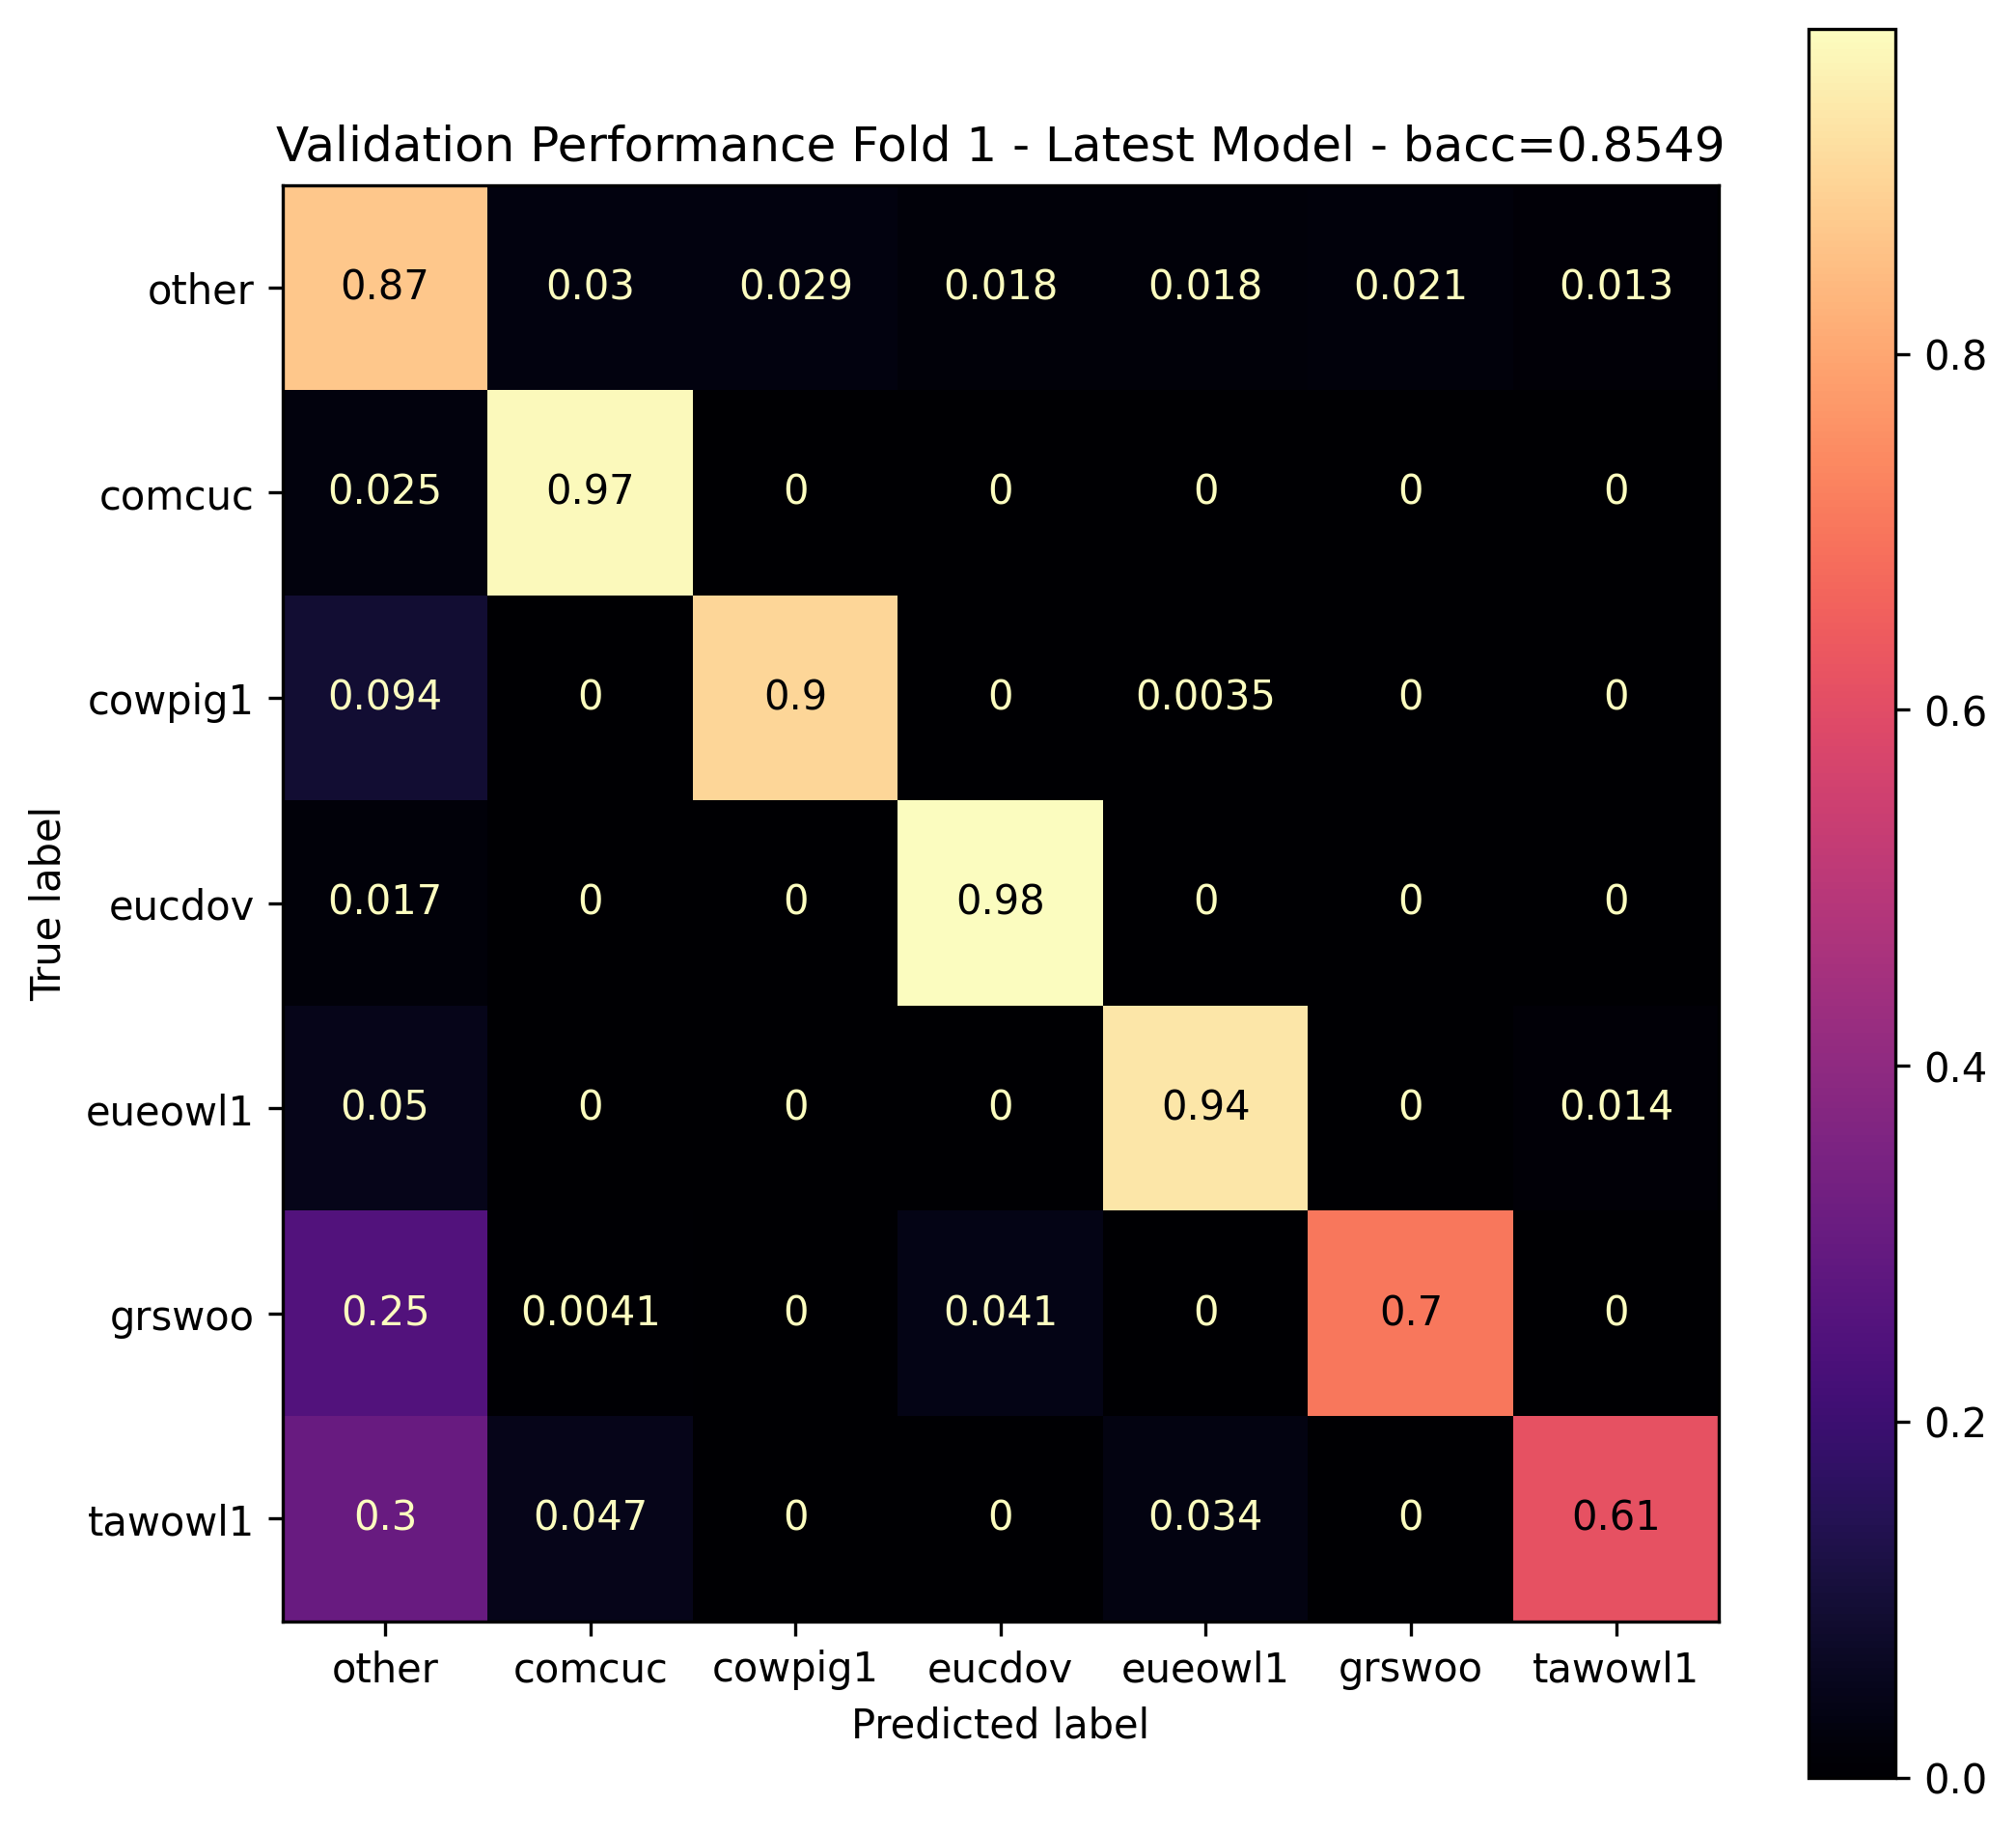

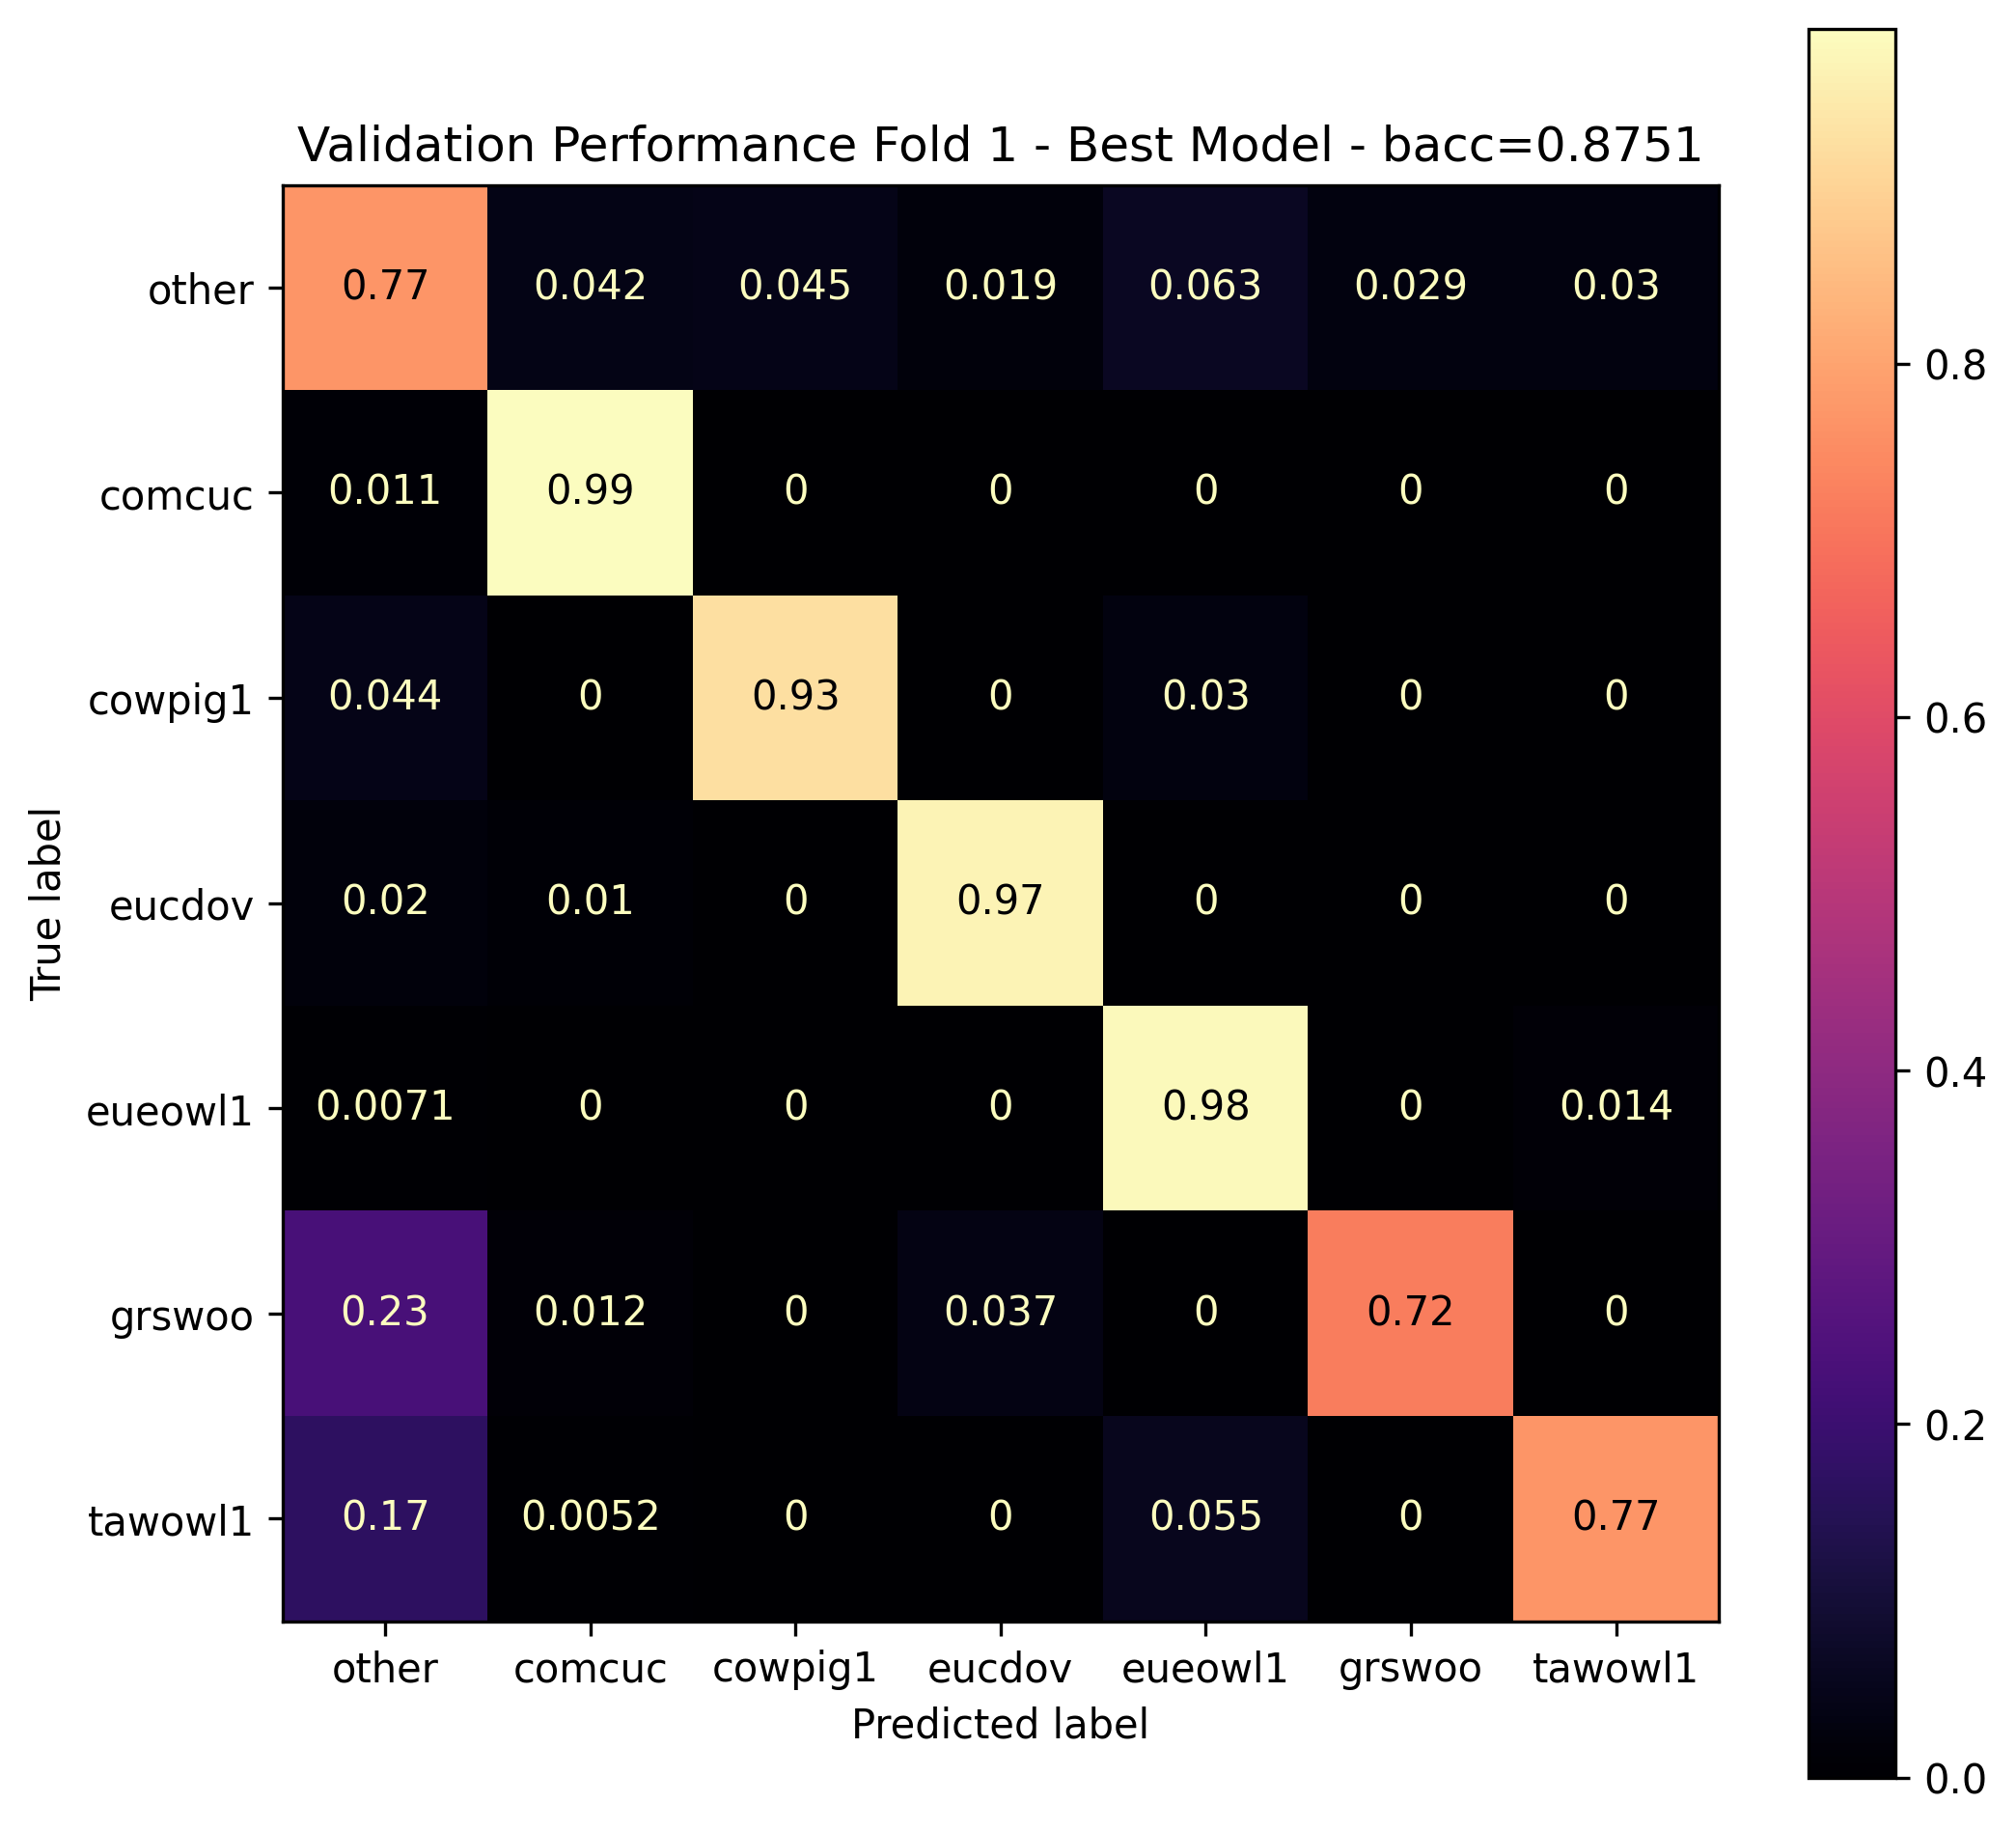

Training fold 2
Training AttentionClassifier with 50643 parameters
train label counts = [61583, 3914, 6719, 6037, 1680, 3320, 3147]
loss weights = [1.0, 15.73, 9.17, 10.2, 36.66, 18.55, 19.57]
eval label counts = [6884, 555, 600, 530, 196, 497, 338]
eval loss weights = [1.0, 12.4, 11.47, 12.99, 35.12, 13.85, 20.37]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000502, num_samples = 86400, num_correct =  9713, acc = 0.112419, bacc = 0.245793
Evaluation Epoch   1/35 : avg_loss = 0.000541, num_samples =  9600, num_correct =  1595, acc = 0.166146, bacc = 0.493157
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000311, num_samples = 86400, num_correct = 19301, acc = 0.223391, bacc = 0.583349
Evaluation Epoch   2/35 : avg_loss = 0.000403, num_samples =  9600, num_correct =  3199, acc = 0.333229, bacc = 0.702988
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000188, num_samples = 86400, num_correct = 42523, acc = 0.492164, bacc = 0.768756
Evaluation Epoch   3/35 : avg_loss = 0.000267, num

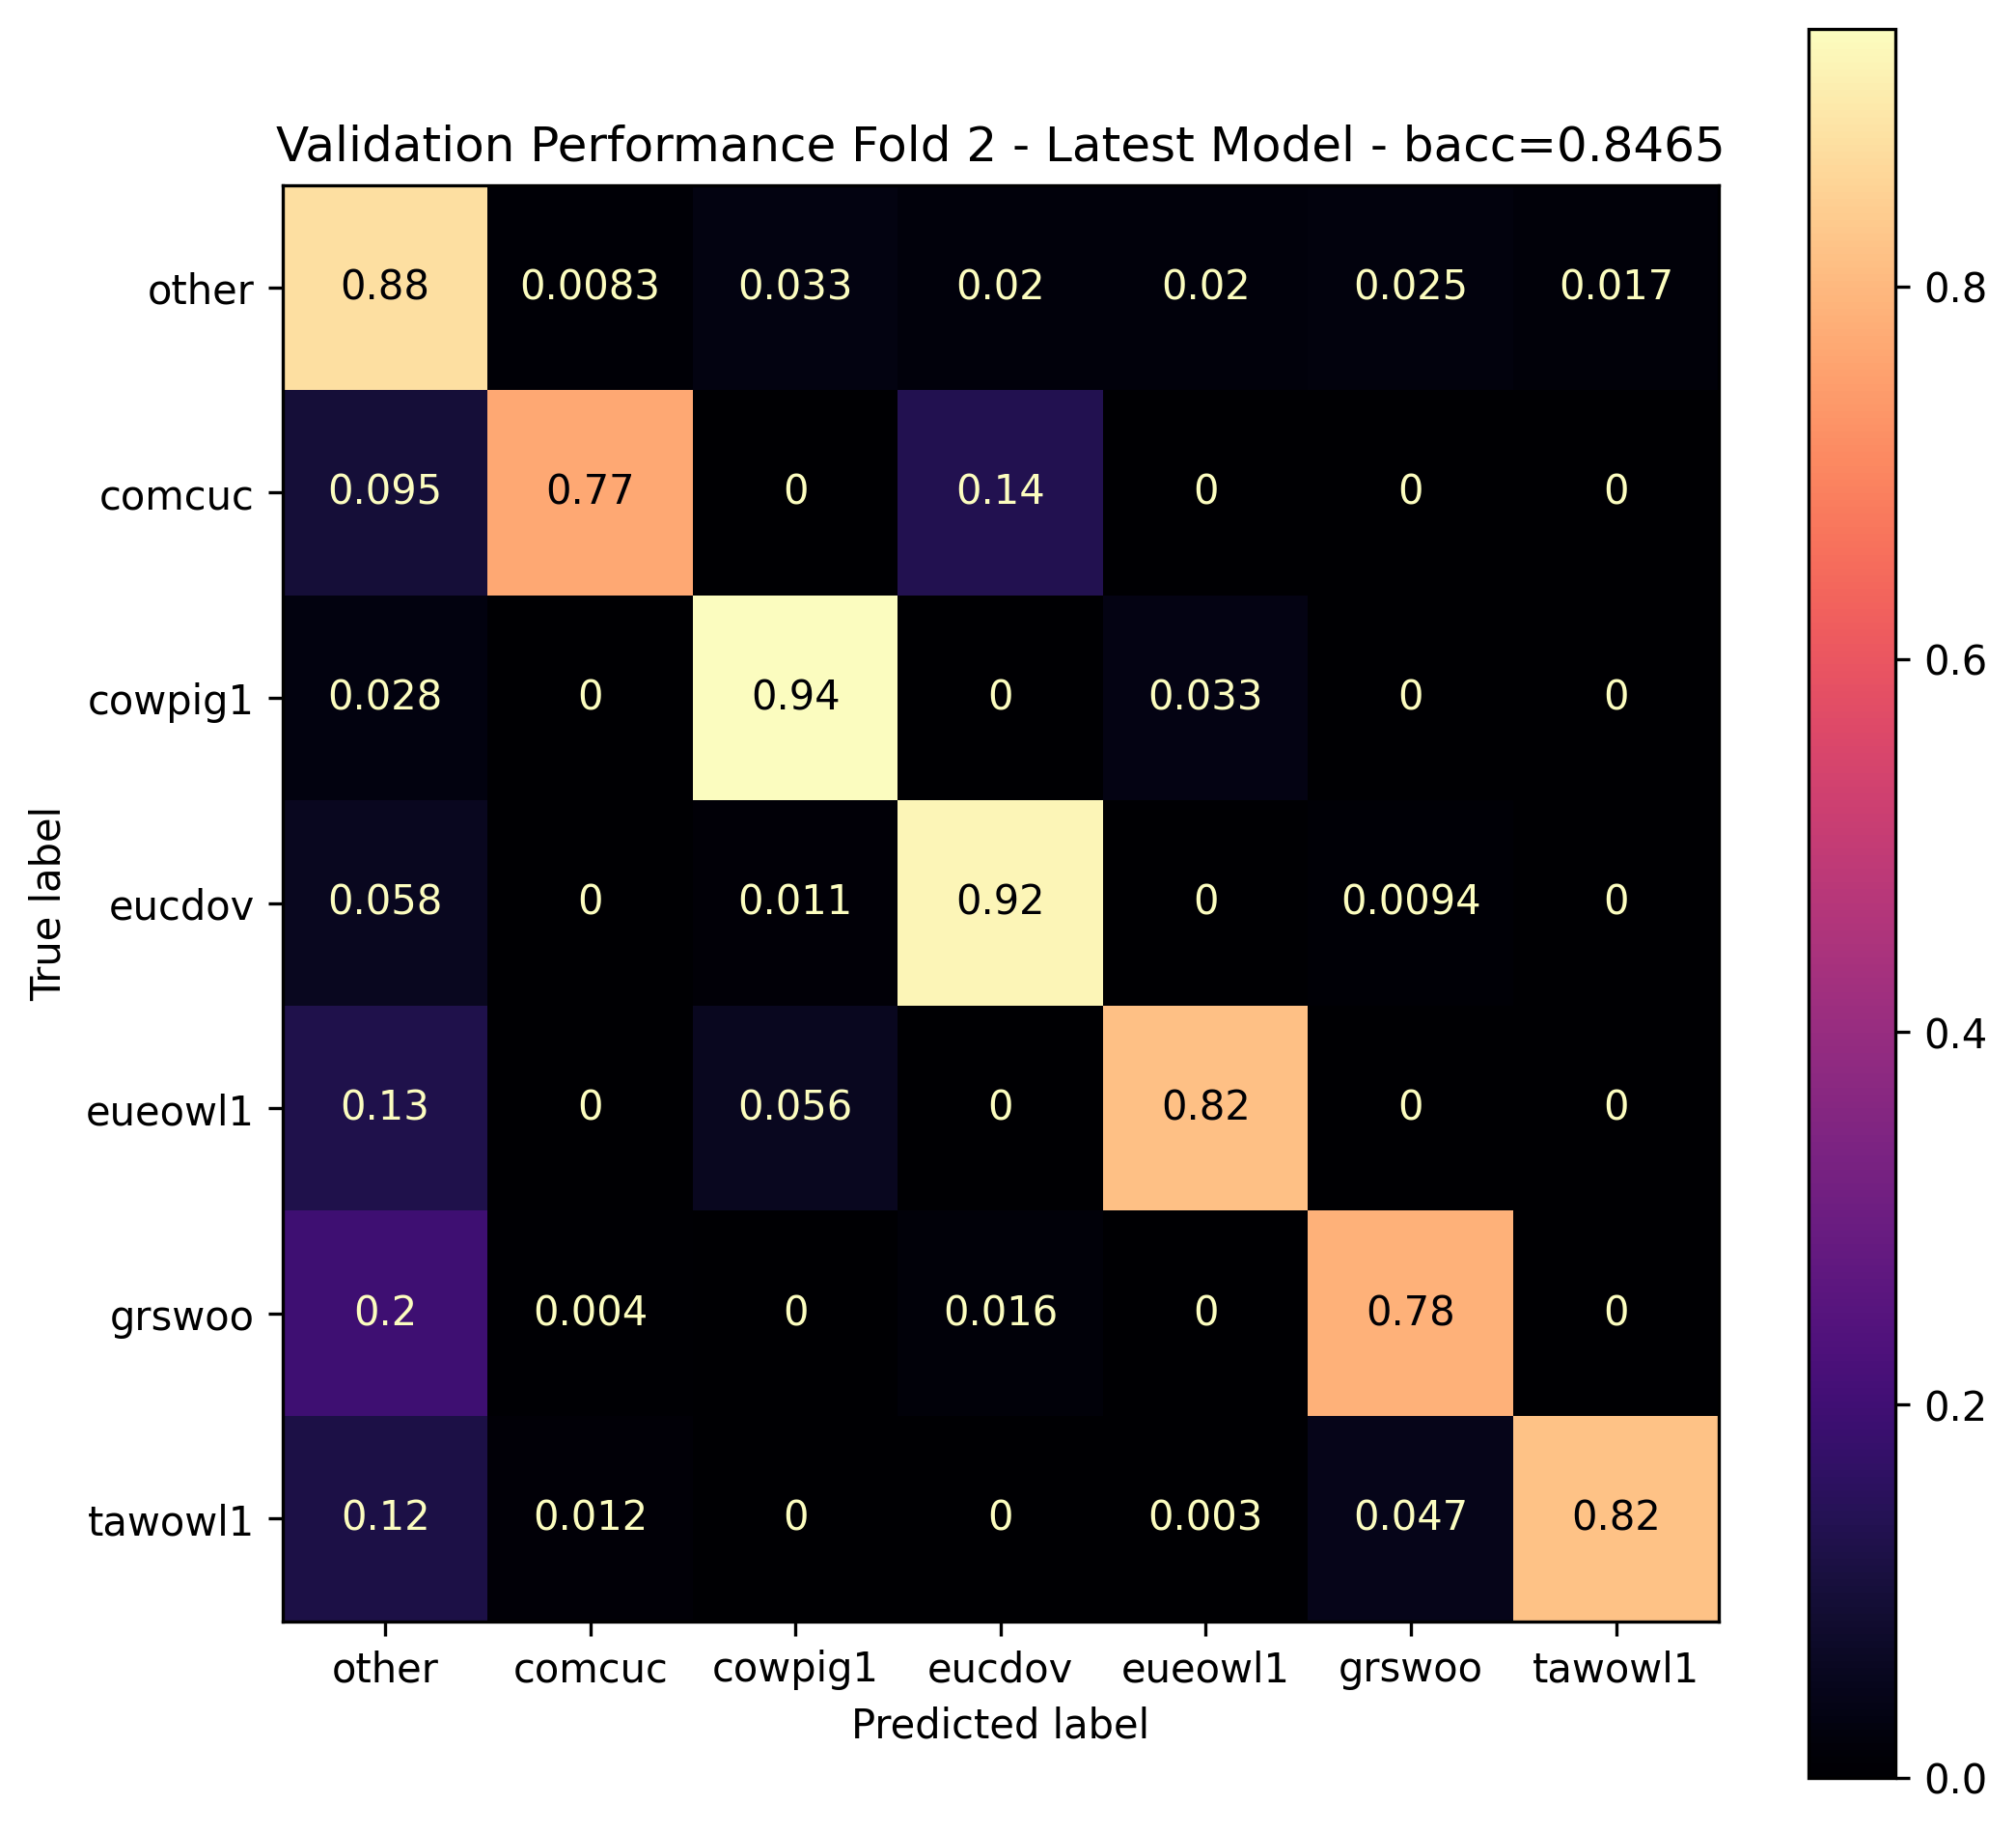

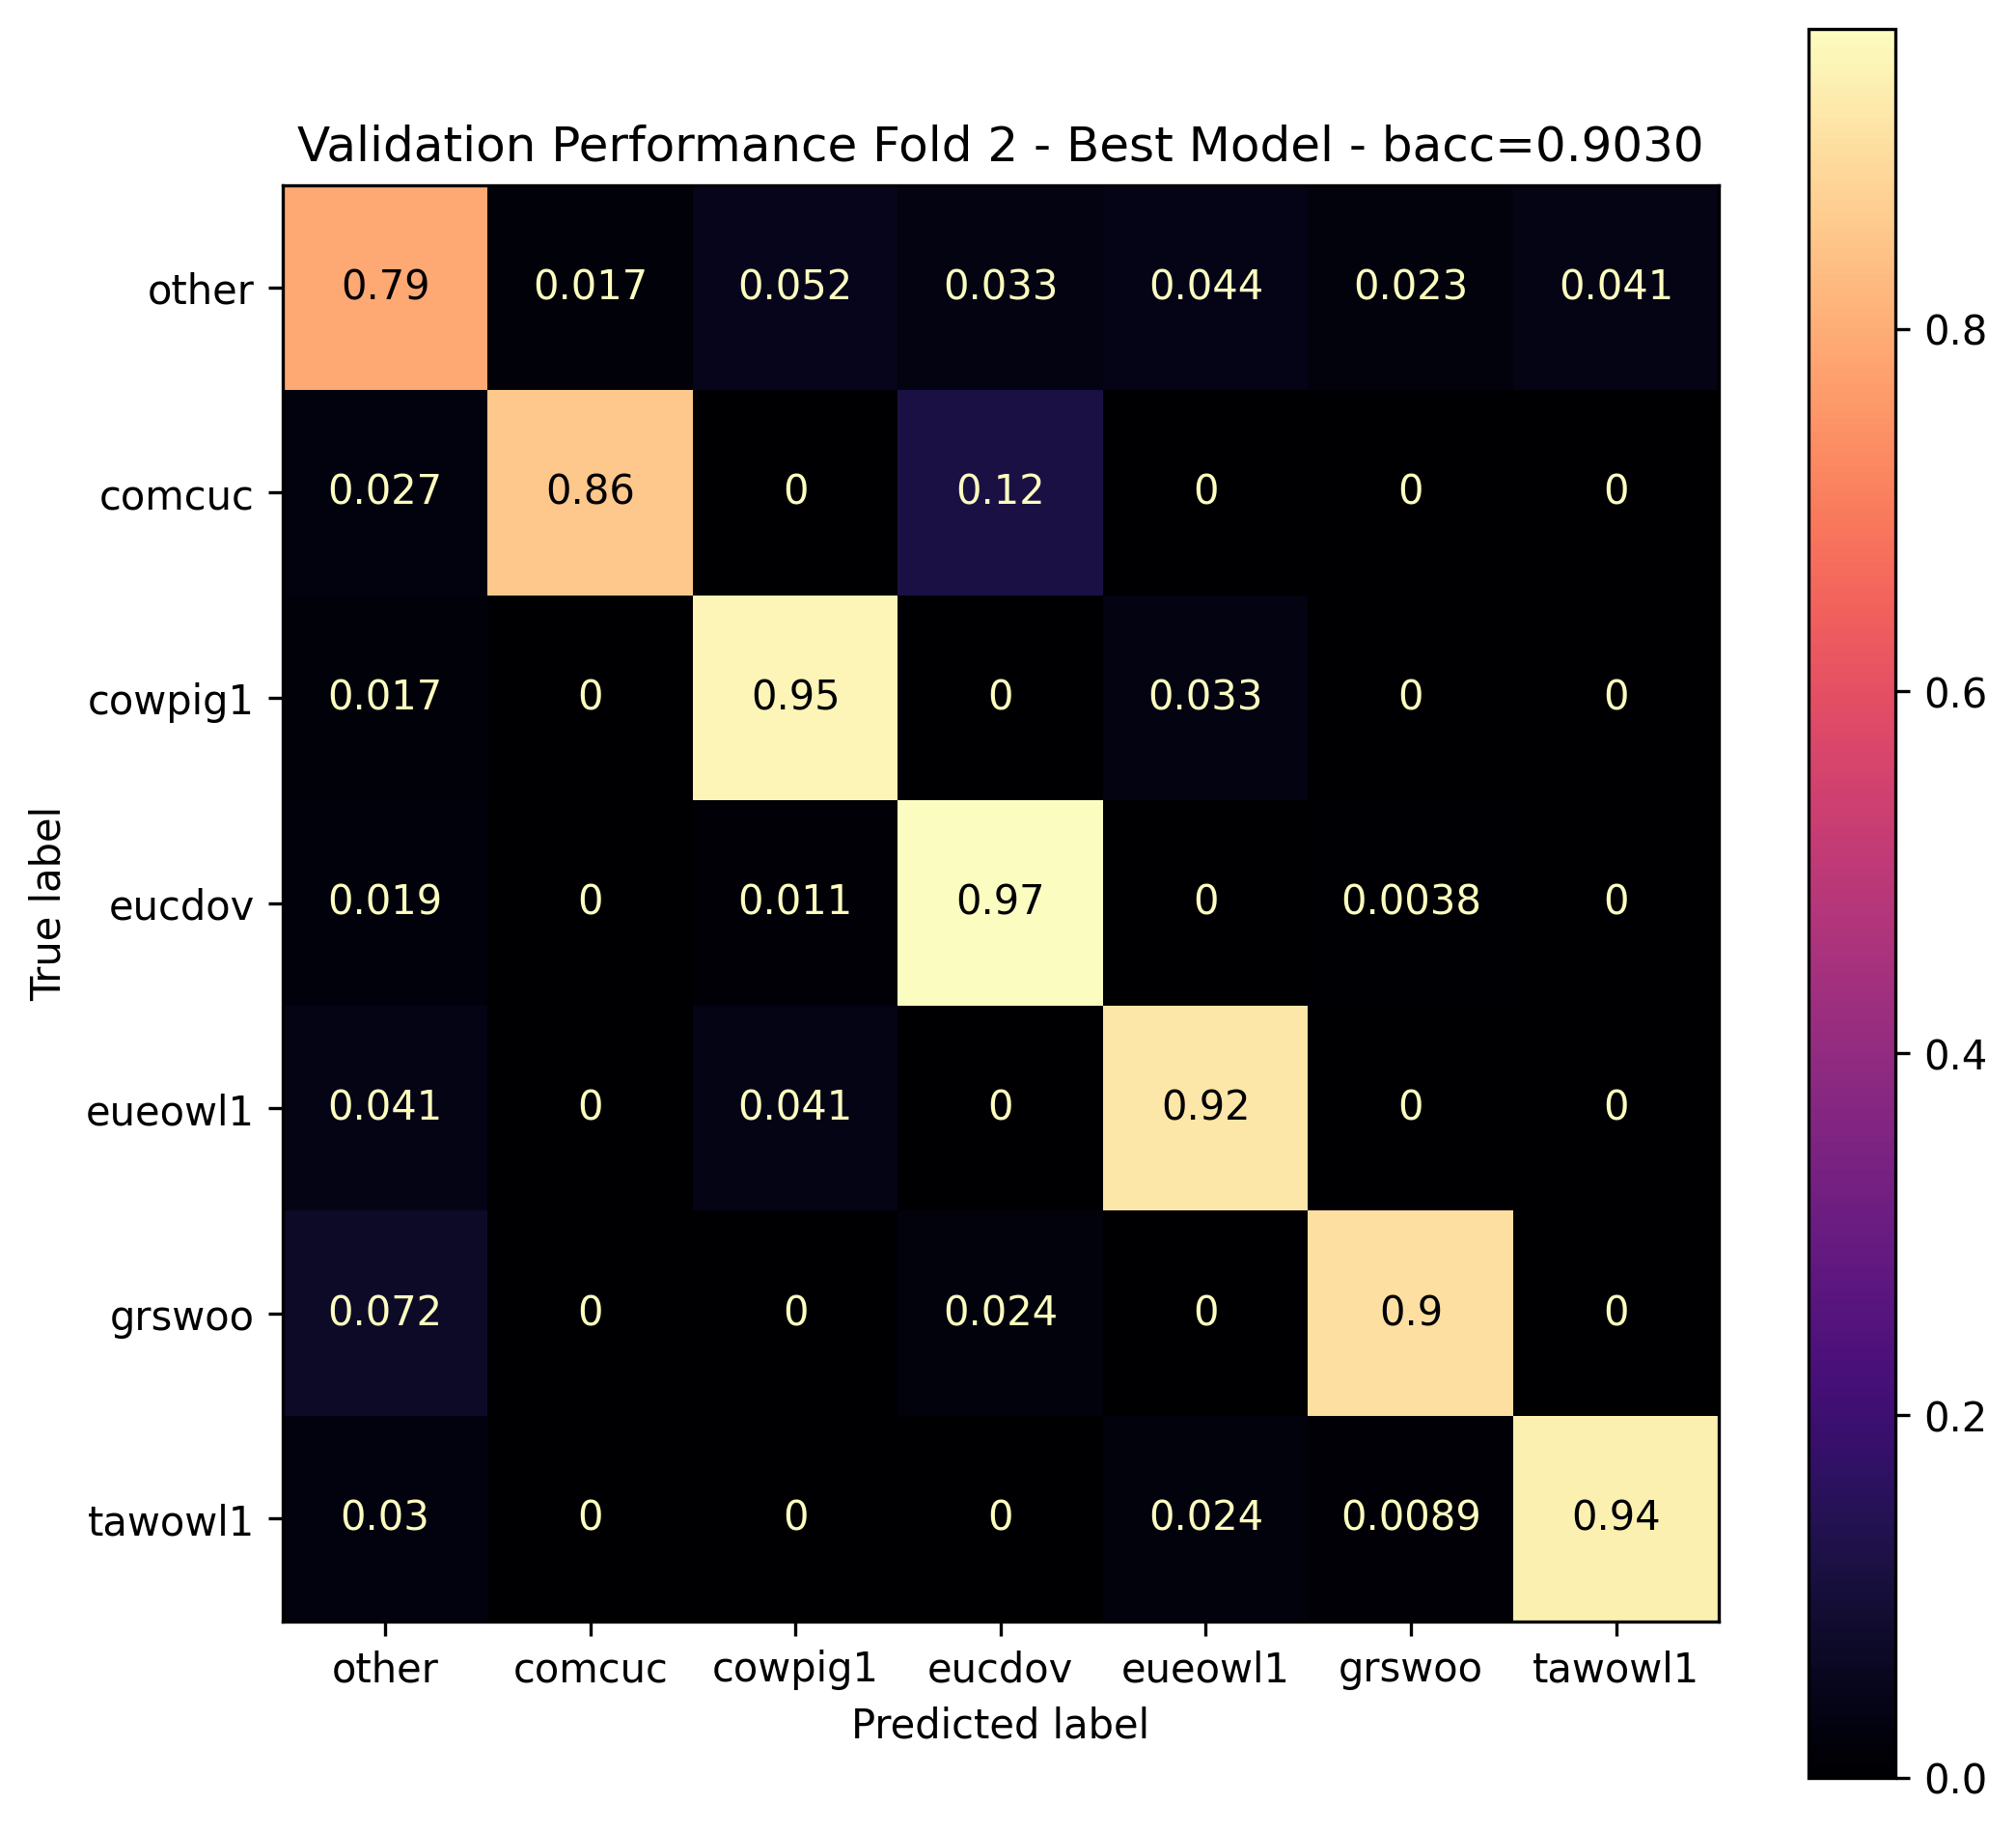

Training fold 3
Training AttentionClassifier with 50643 parameters
train label counts = [61740, 4030, 6387, 5829, 1708, 3556, 3150]
loss weights = [1.0, 15.32, 9.67, 10.59, 36.15, 17.36, 19.6]
eval label counts = [6727, 439, 932, 738, 168, 261, 335]
eval loss weights = [1.0, 15.32, 7.22, 9.12, 40.04, 25.77, 20.08]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000497, num_samples = 86400, num_correct = 10439, acc = 0.120822, bacc = 0.286608
Evaluation Epoch   1/35 : avg_loss = 0.000567, num_samples =  9600, num_correct =  2037, acc = 0.212188, bacc = 0.619441
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000266, num_samples = 86400, num_correct = 23843, acc = 0.275961, bacc = 0.693098
Evaluation Epoch   2/35 : avg_loss = 0.000340, num_samples =  9600, num_correct =  3957, acc = 0.412187, bacc = 0.784340
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000181, num_samples = 86400, num_correct = 39848, acc = 0.461204, bacc = 0.787082
Evaluation Epoch   3/35 : avg_loss = 0.000249, num_

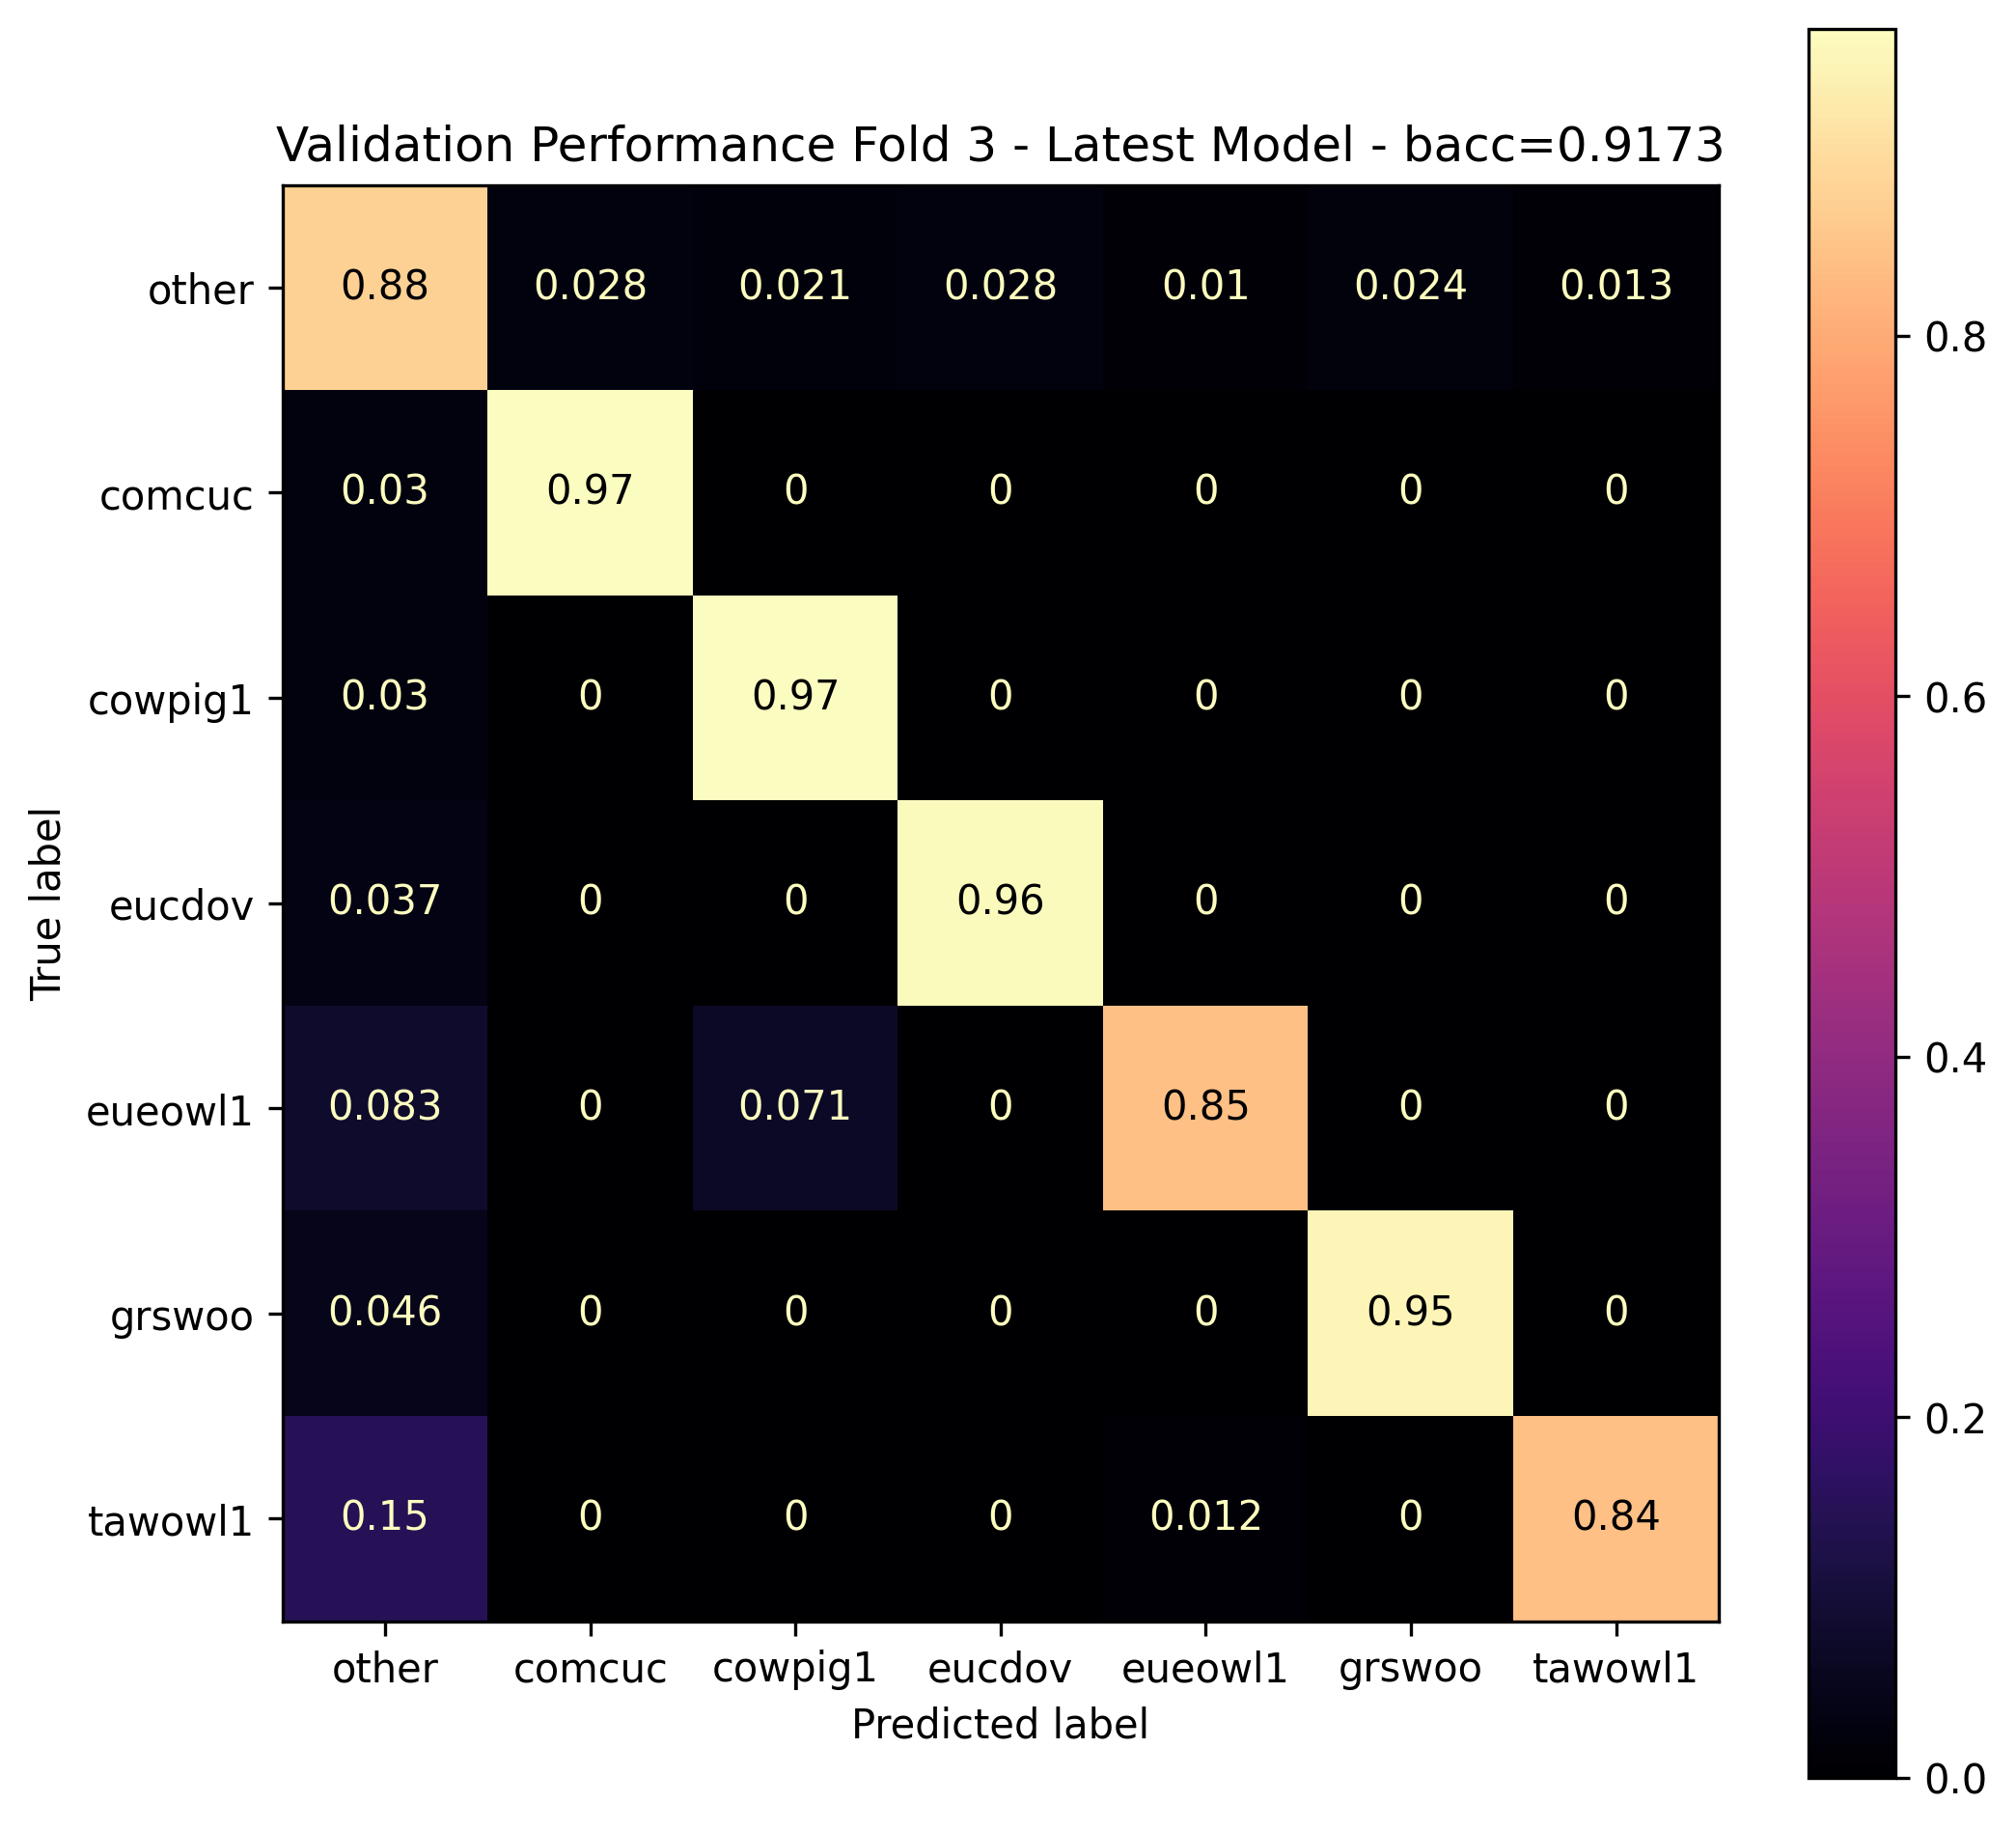

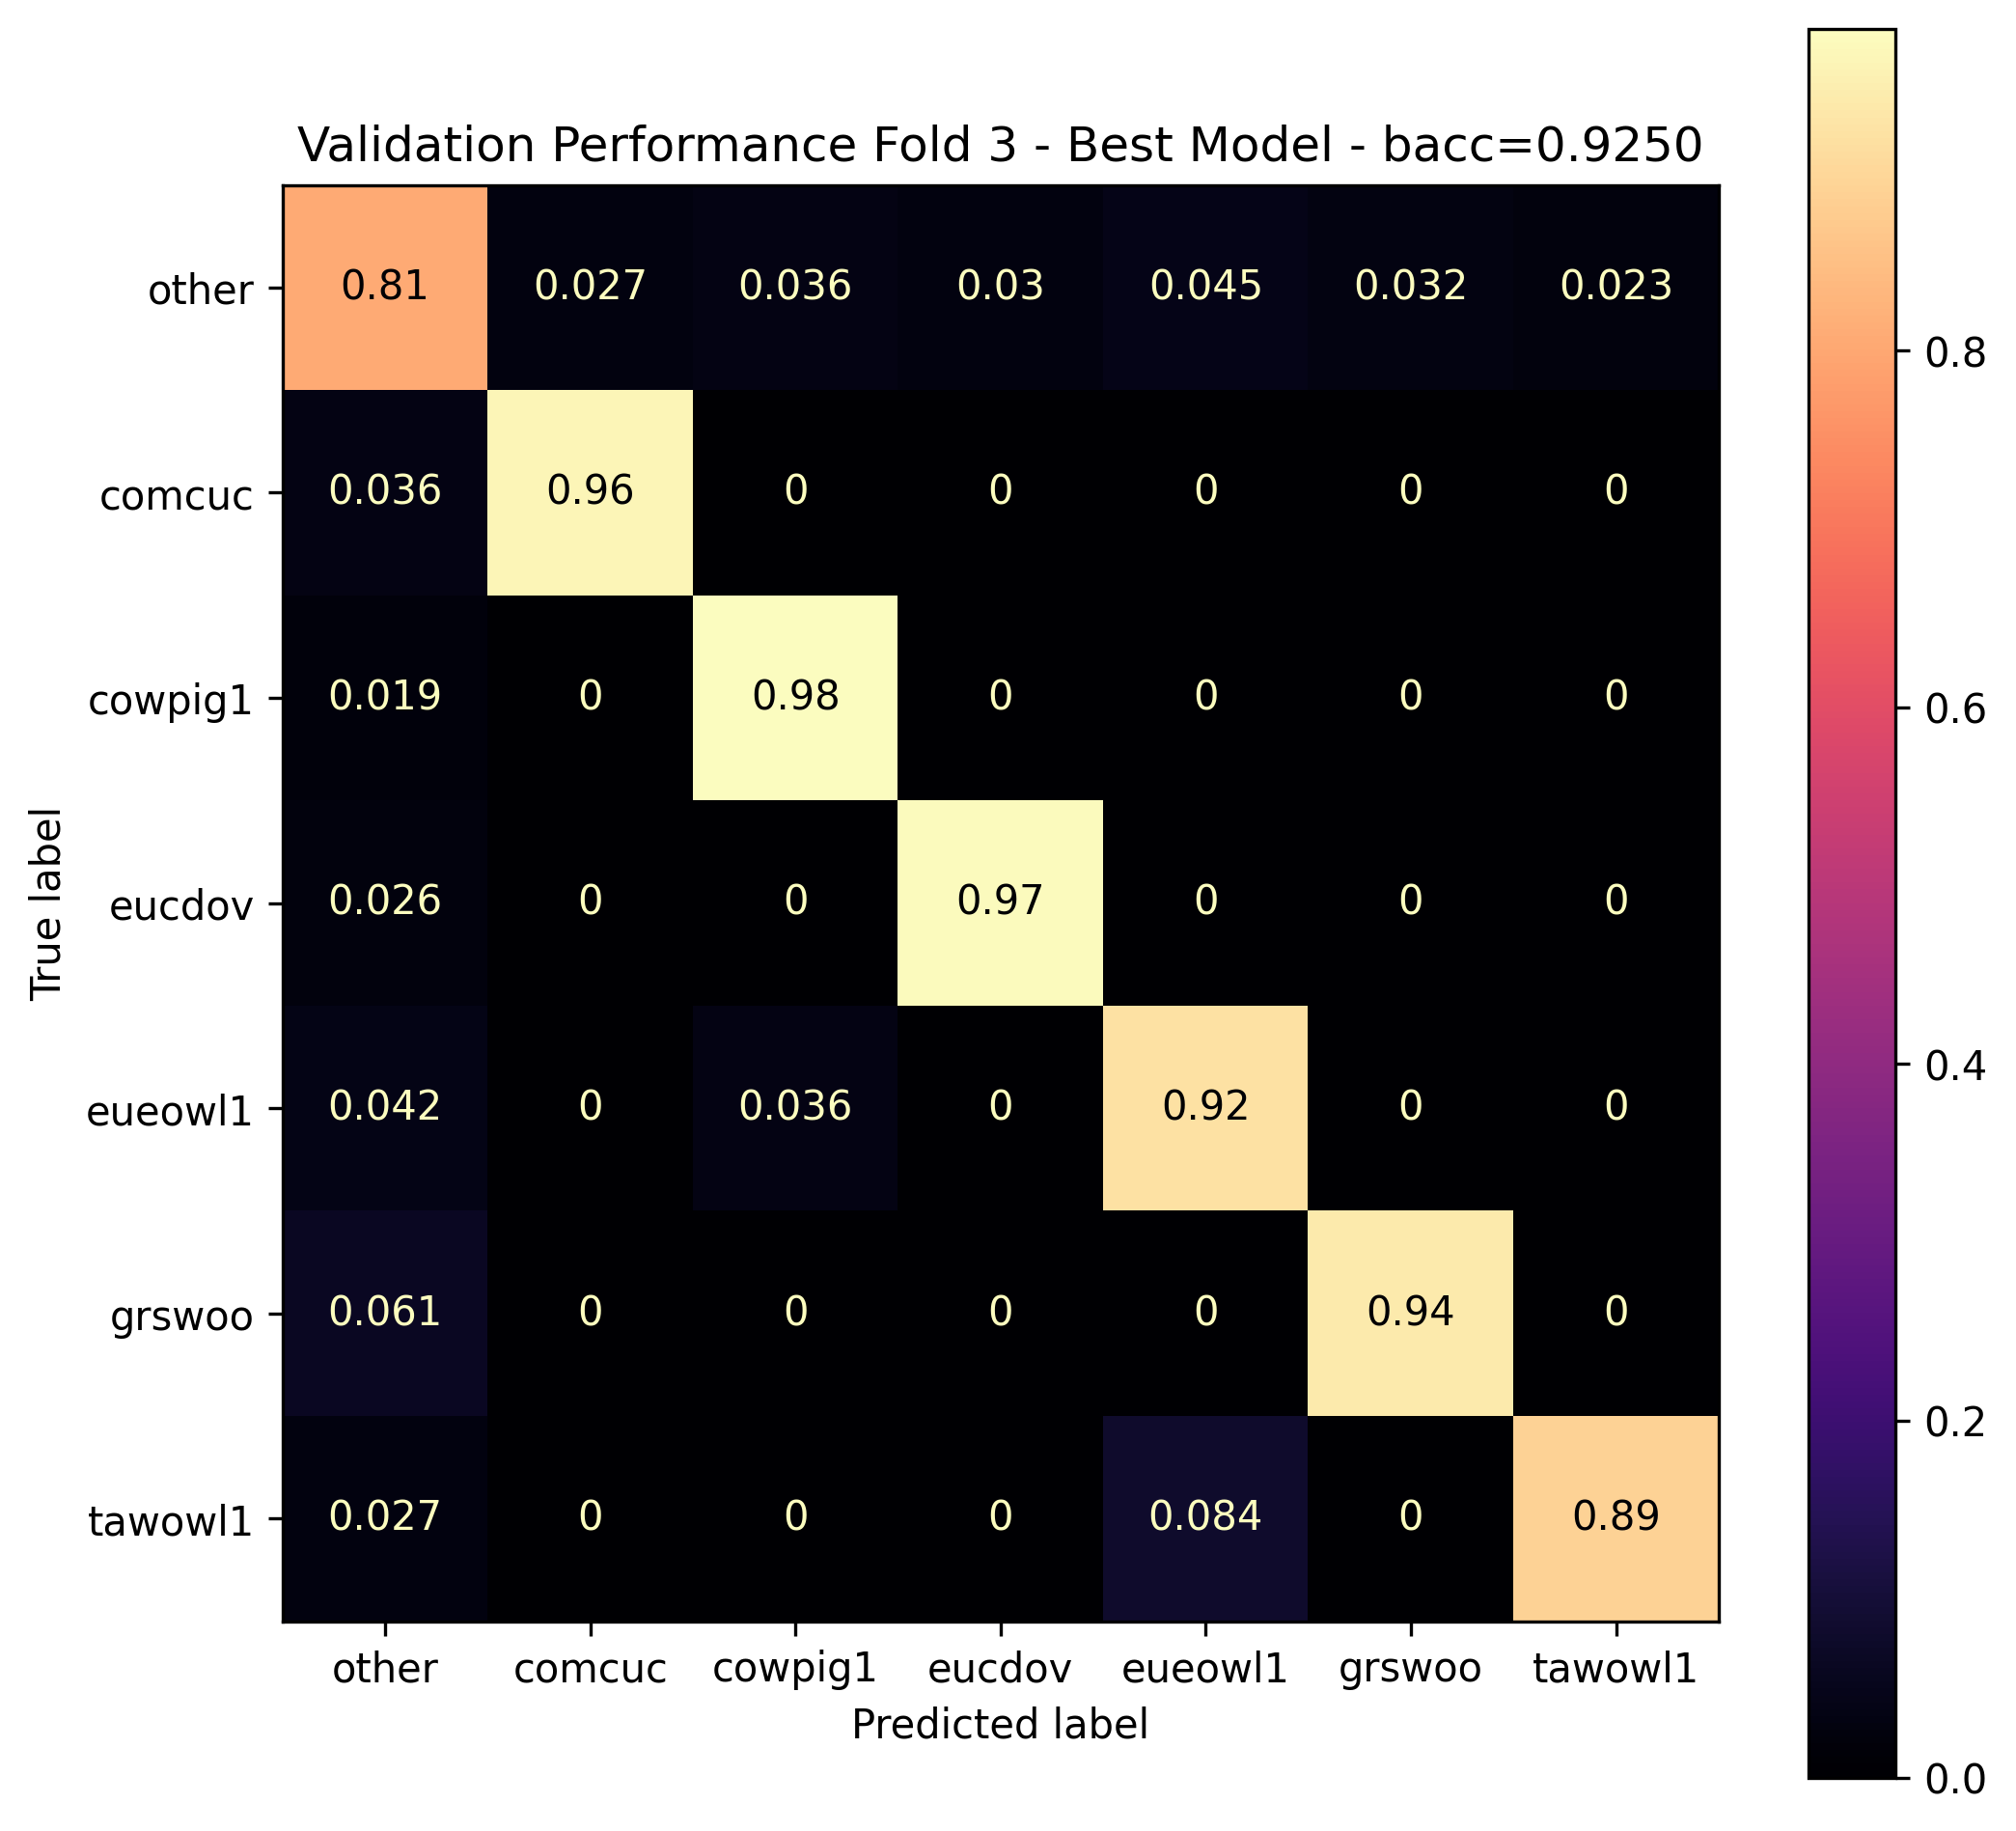

Training fold 4
Training AttentionClassifier with 50643 parameters
train label counts = [61753, 3979, 6551, 5841, 1646, 3420, 3210]
loss weights = [1.0, 15.52, 9.43, 10.57, 37.52, 18.06, 19.24]
eval label counts = [6714, 490, 768, 726, 230, 397, 275]
eval loss weights = [1.0, 13.7, 8.74, 9.25, 29.19, 16.91, 24.41]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000495, num_samples = 86400, num_correct = 12474, acc = 0.144375, bacc = 0.304122
Evaluation Epoch   1/35 : avg_loss = 0.000550, num_samples =  9600, num_correct =  2228, acc = 0.232083, bacc = 0.685370
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000262, num_samples = 86400, num_correct = 31474, acc = 0.364282, bacc = 0.698459
Evaluation Epoch   2/35 : avg_loss = 0.000406, num_samples =  9600, num_correct =  3837, acc = 0.399687, bacc = 0.757068
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000196, num_samples = 86400, num_correct = 42036, acc = 0.486528, bacc = 0.768708
Evaluation Epoch   3/35 : avg_loss = 0.000294, num_

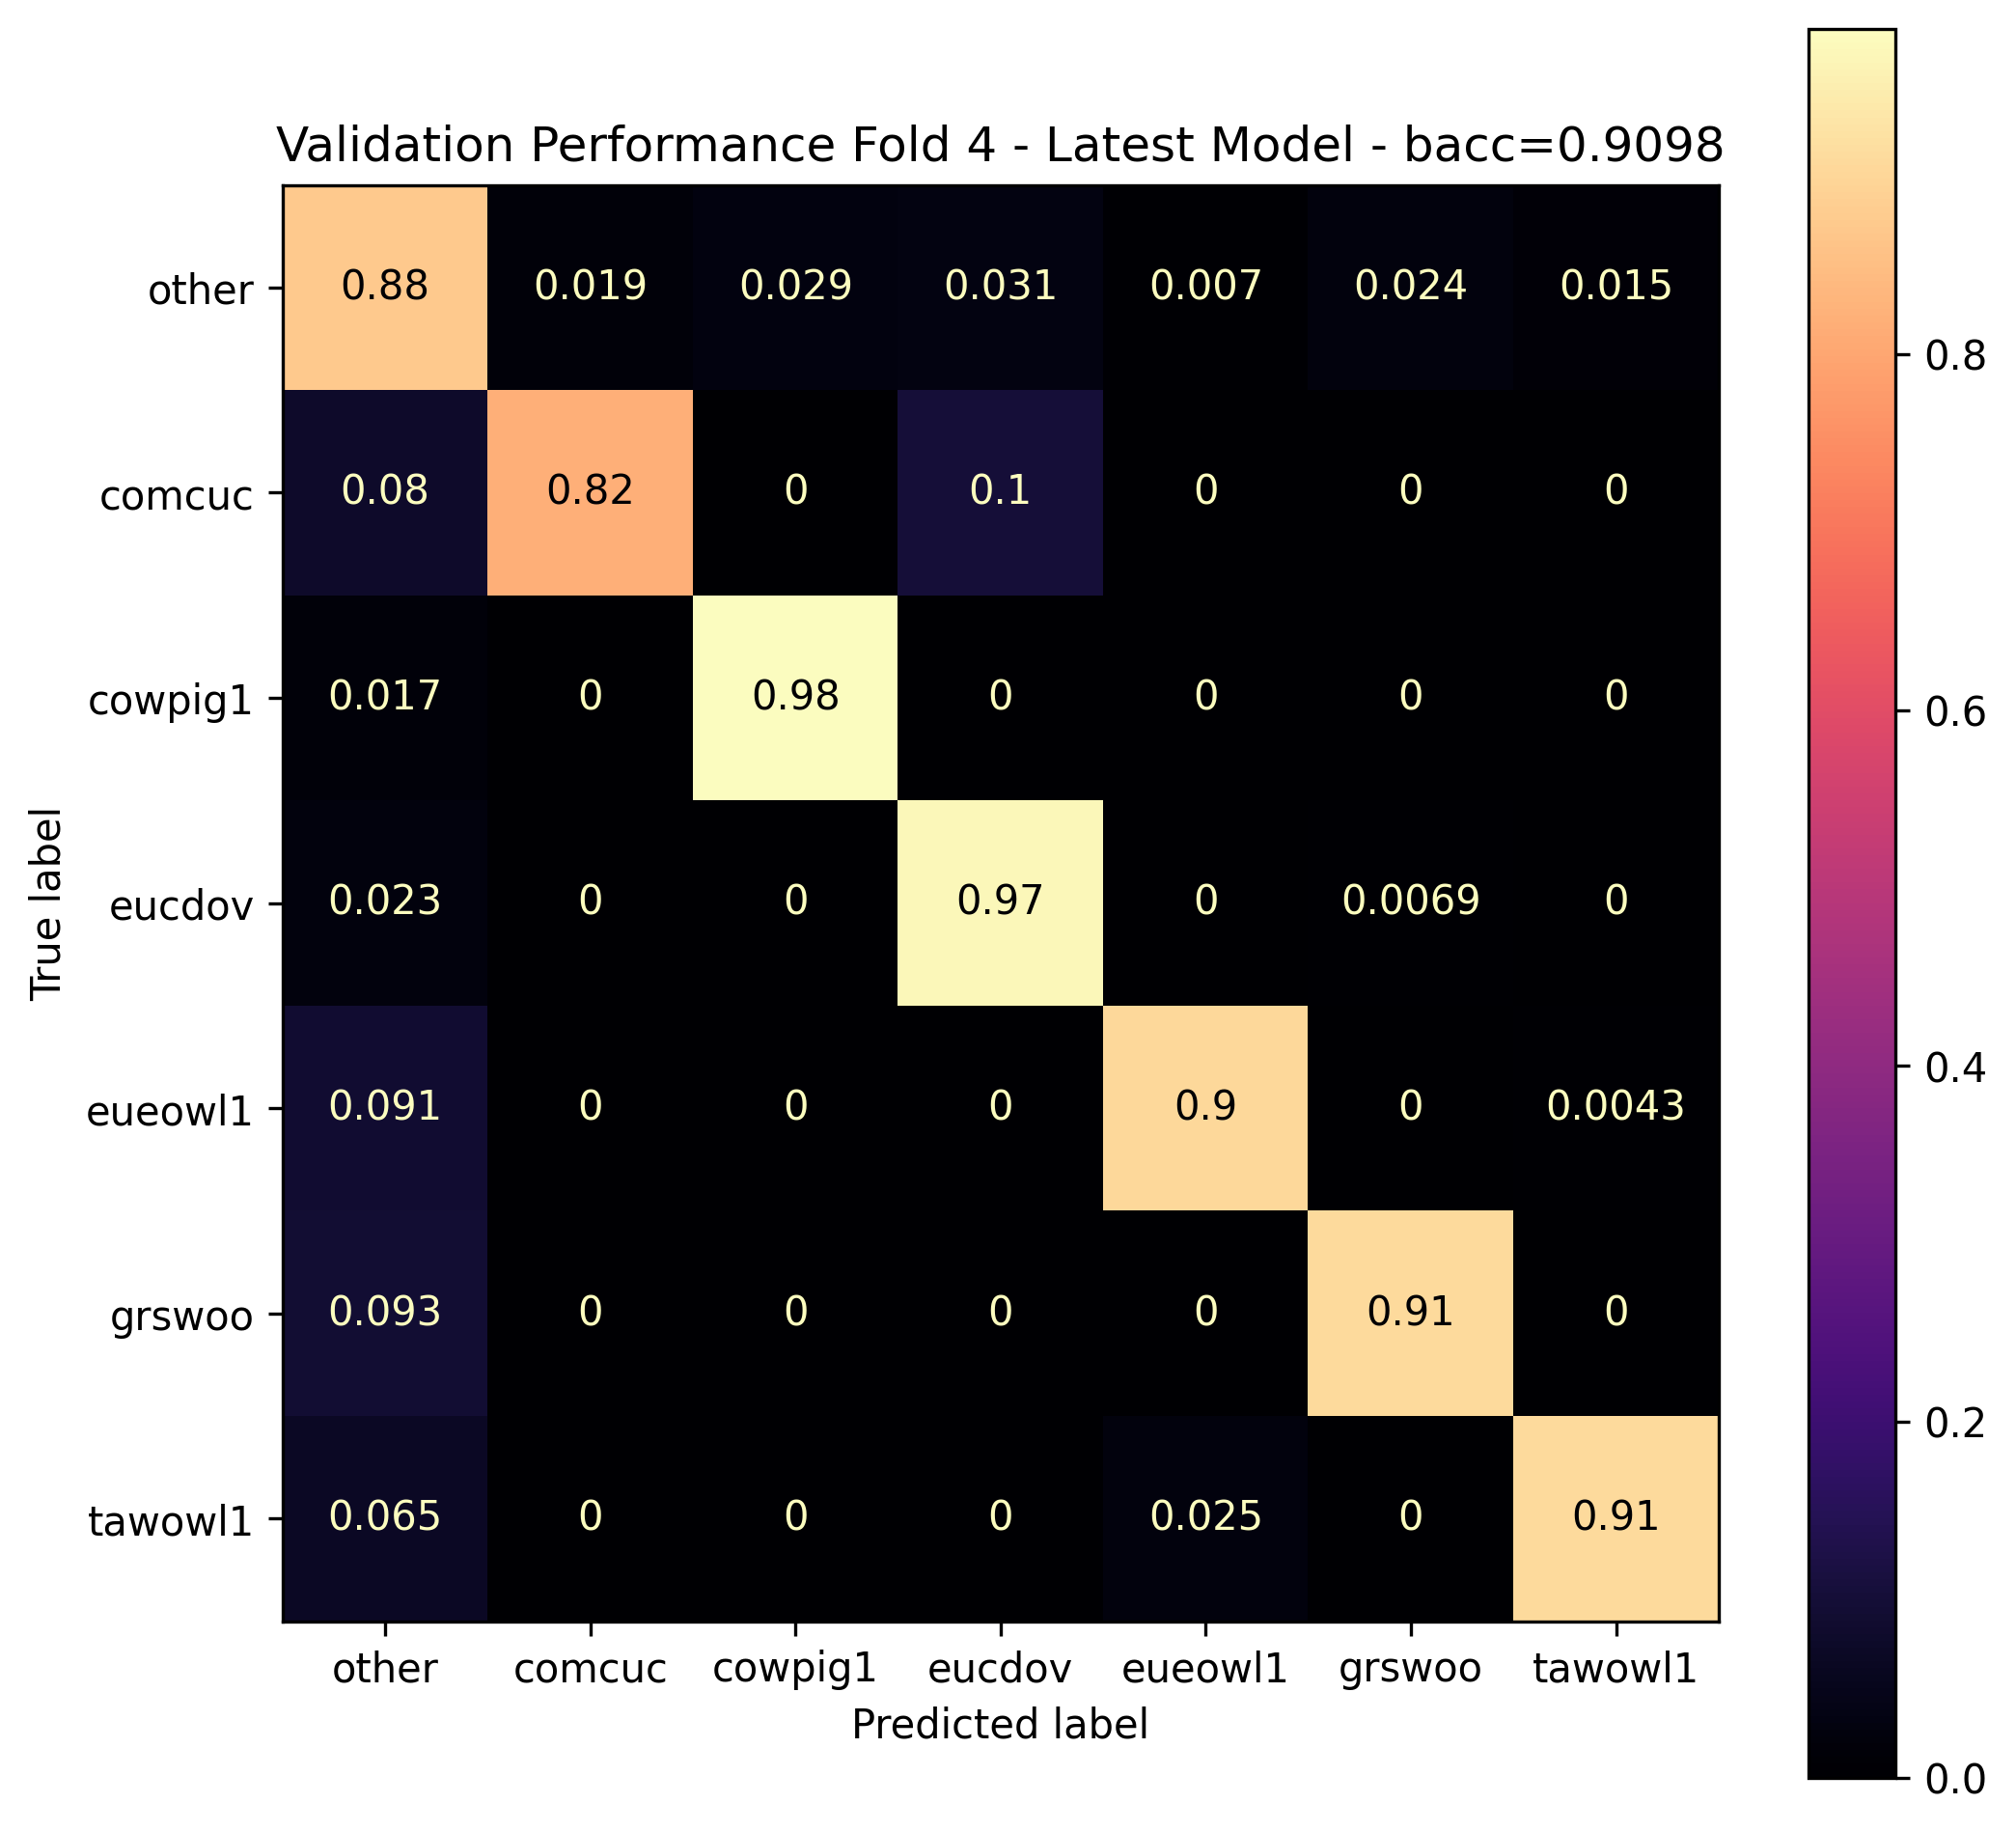

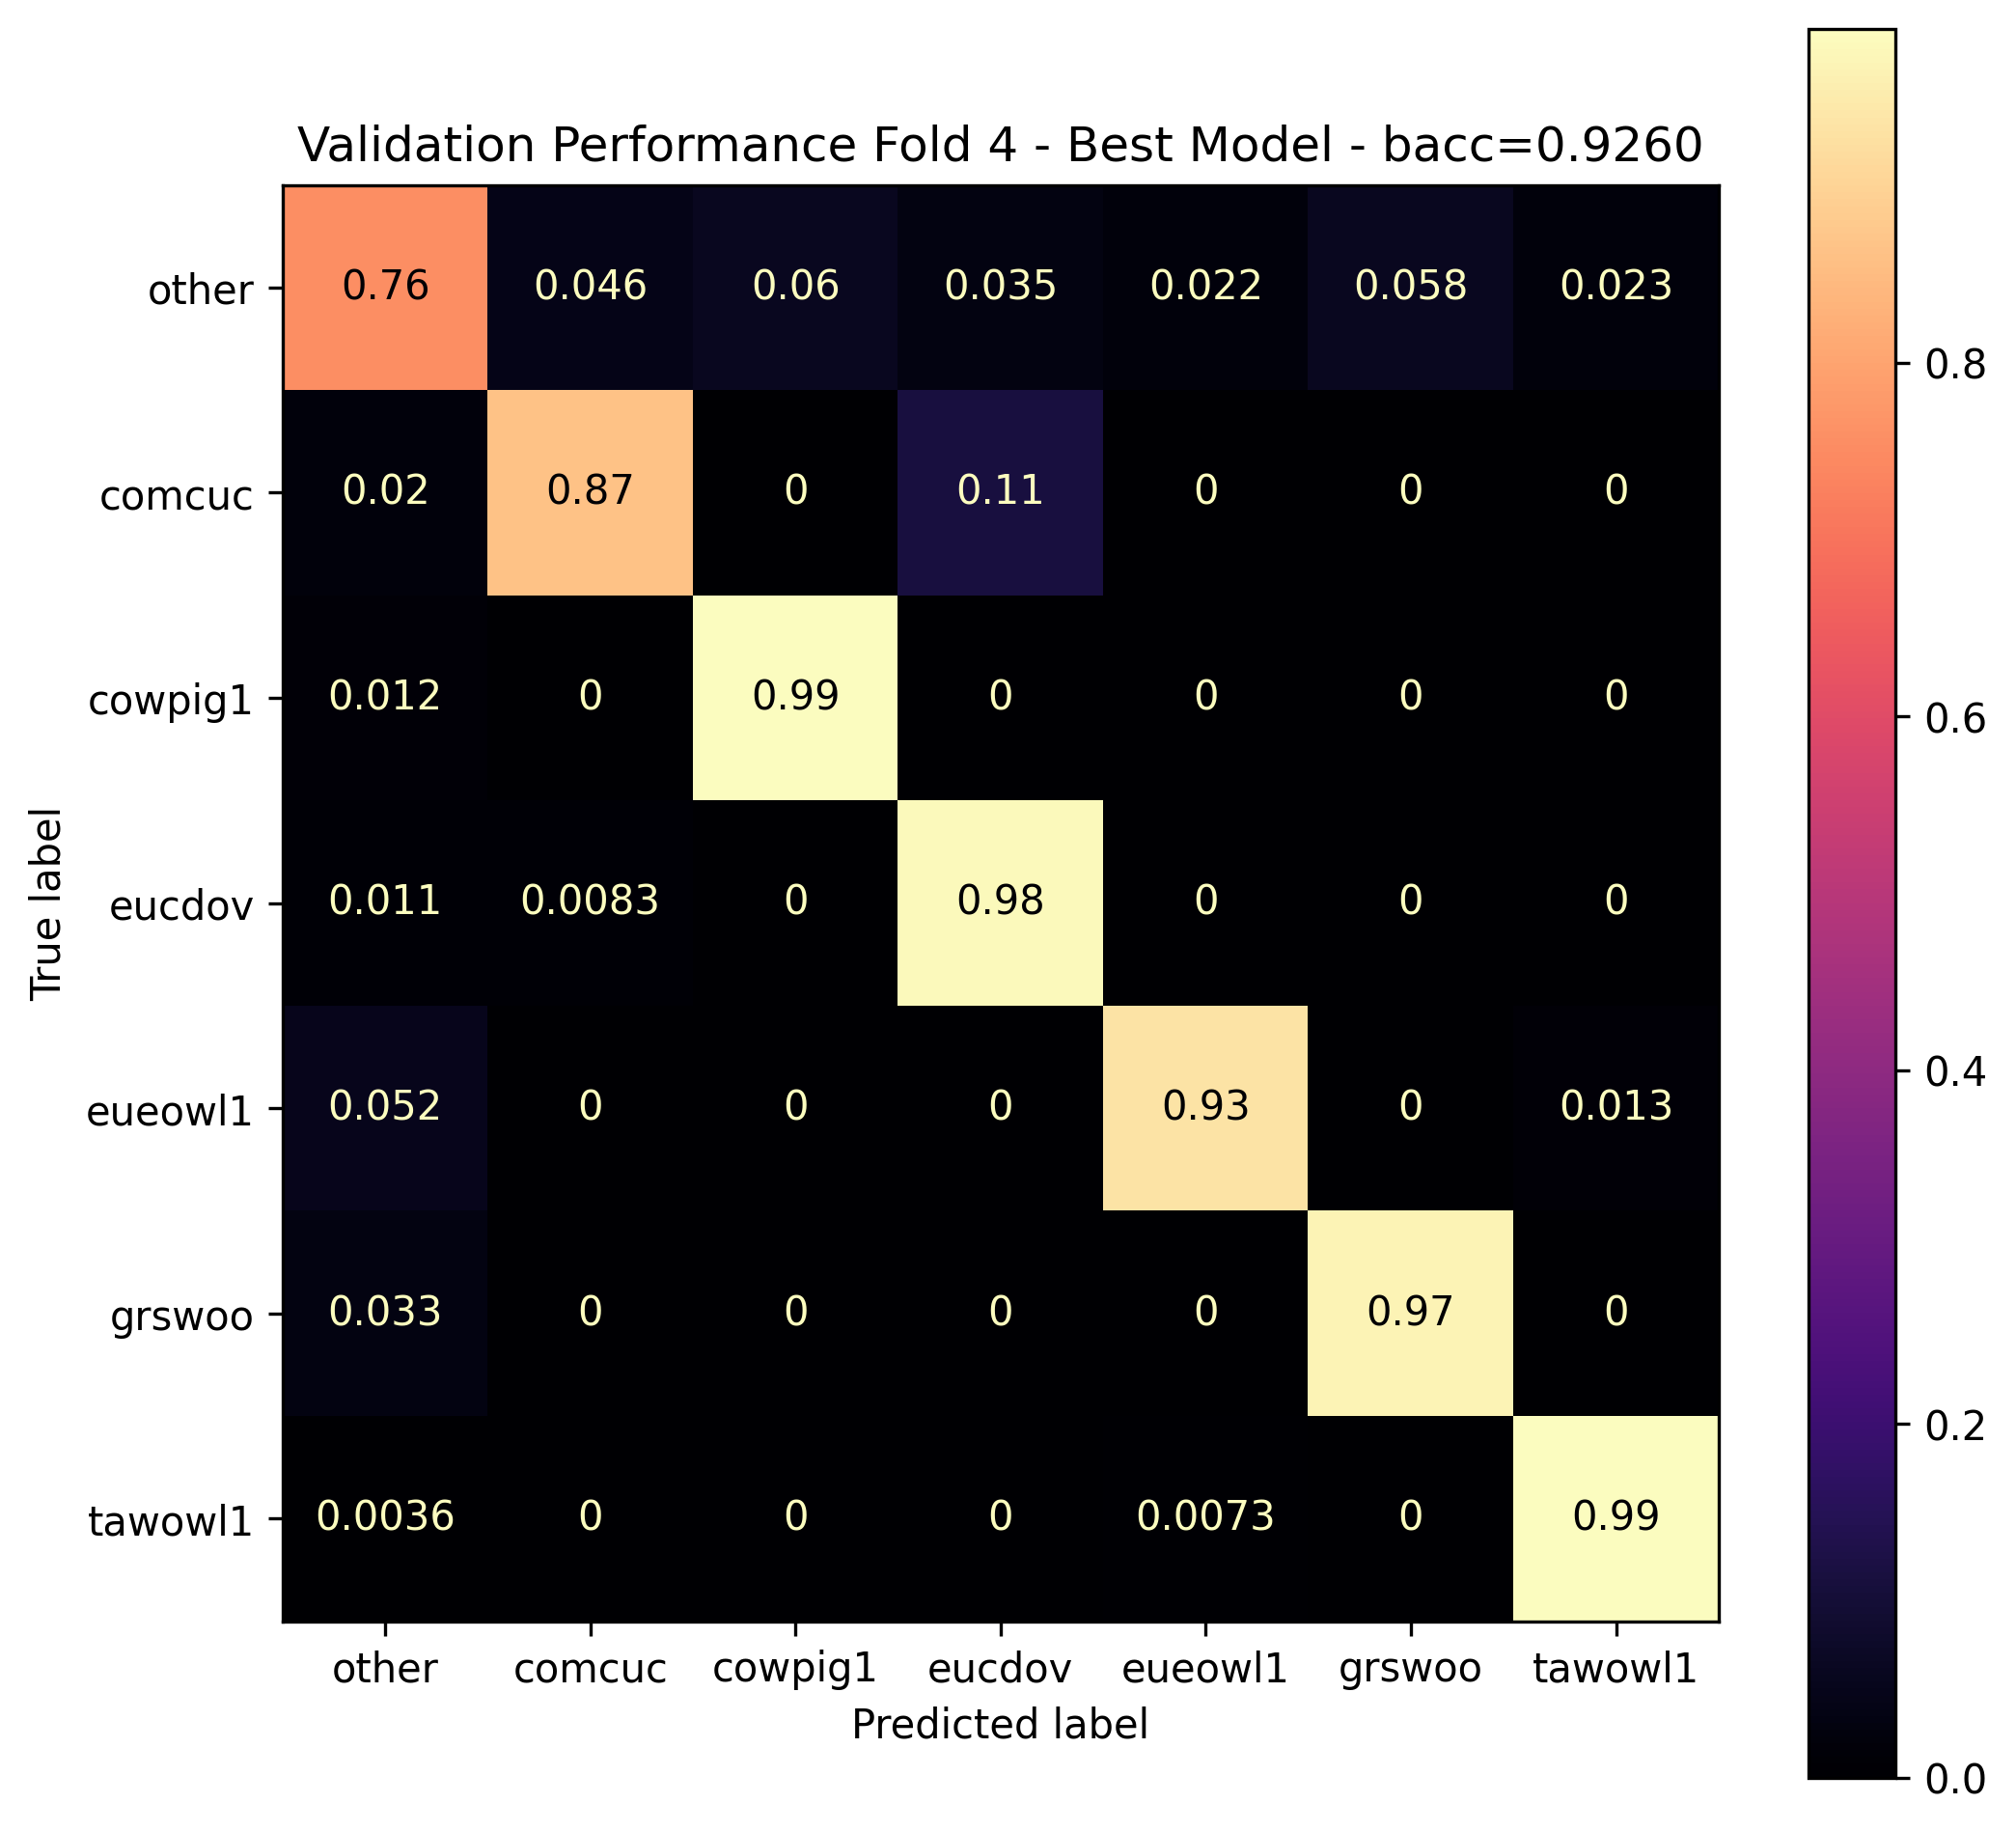

Training fold 5
Training AttentionClassifier with 50643 parameters
train label counts = [61594, 4029, 6512, 5939, 1768, 3478, 3080]
loss weights = [1.0, 15.29, 9.46, 10.37, 34.84, 17.71, 20.0]
eval label counts = [6873, 440, 807, 628, 108, 339, 405]
eval loss weights = [1.0, 15.62, 8.52, 10.94, 63.64, 20.27, 16.97]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000493, num_samples = 86400, num_correct =  7378, acc = 0.085394, bacc = 0.243773
Evaluation Epoch   1/35 : avg_loss = 0.000508, num_samples =  9600, num_correct =  1778, acc = 0.185208, bacc = 0.490691
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000315, num_samples = 86400, num_correct = 22009, acc = 0.254734, bacc = 0.571059
Evaluation Epoch   2/35 : avg_loss = 0.000468, num_samples =  9600, num_correct =  2757, acc = 0.287187, bacc = 0.693195
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000222, num_samples = 86400, num_correct = 37717, acc = 0.436539, bacc = 0.749953
Evaluation Epoch   3/35 : avg_loss = 0.000295, num

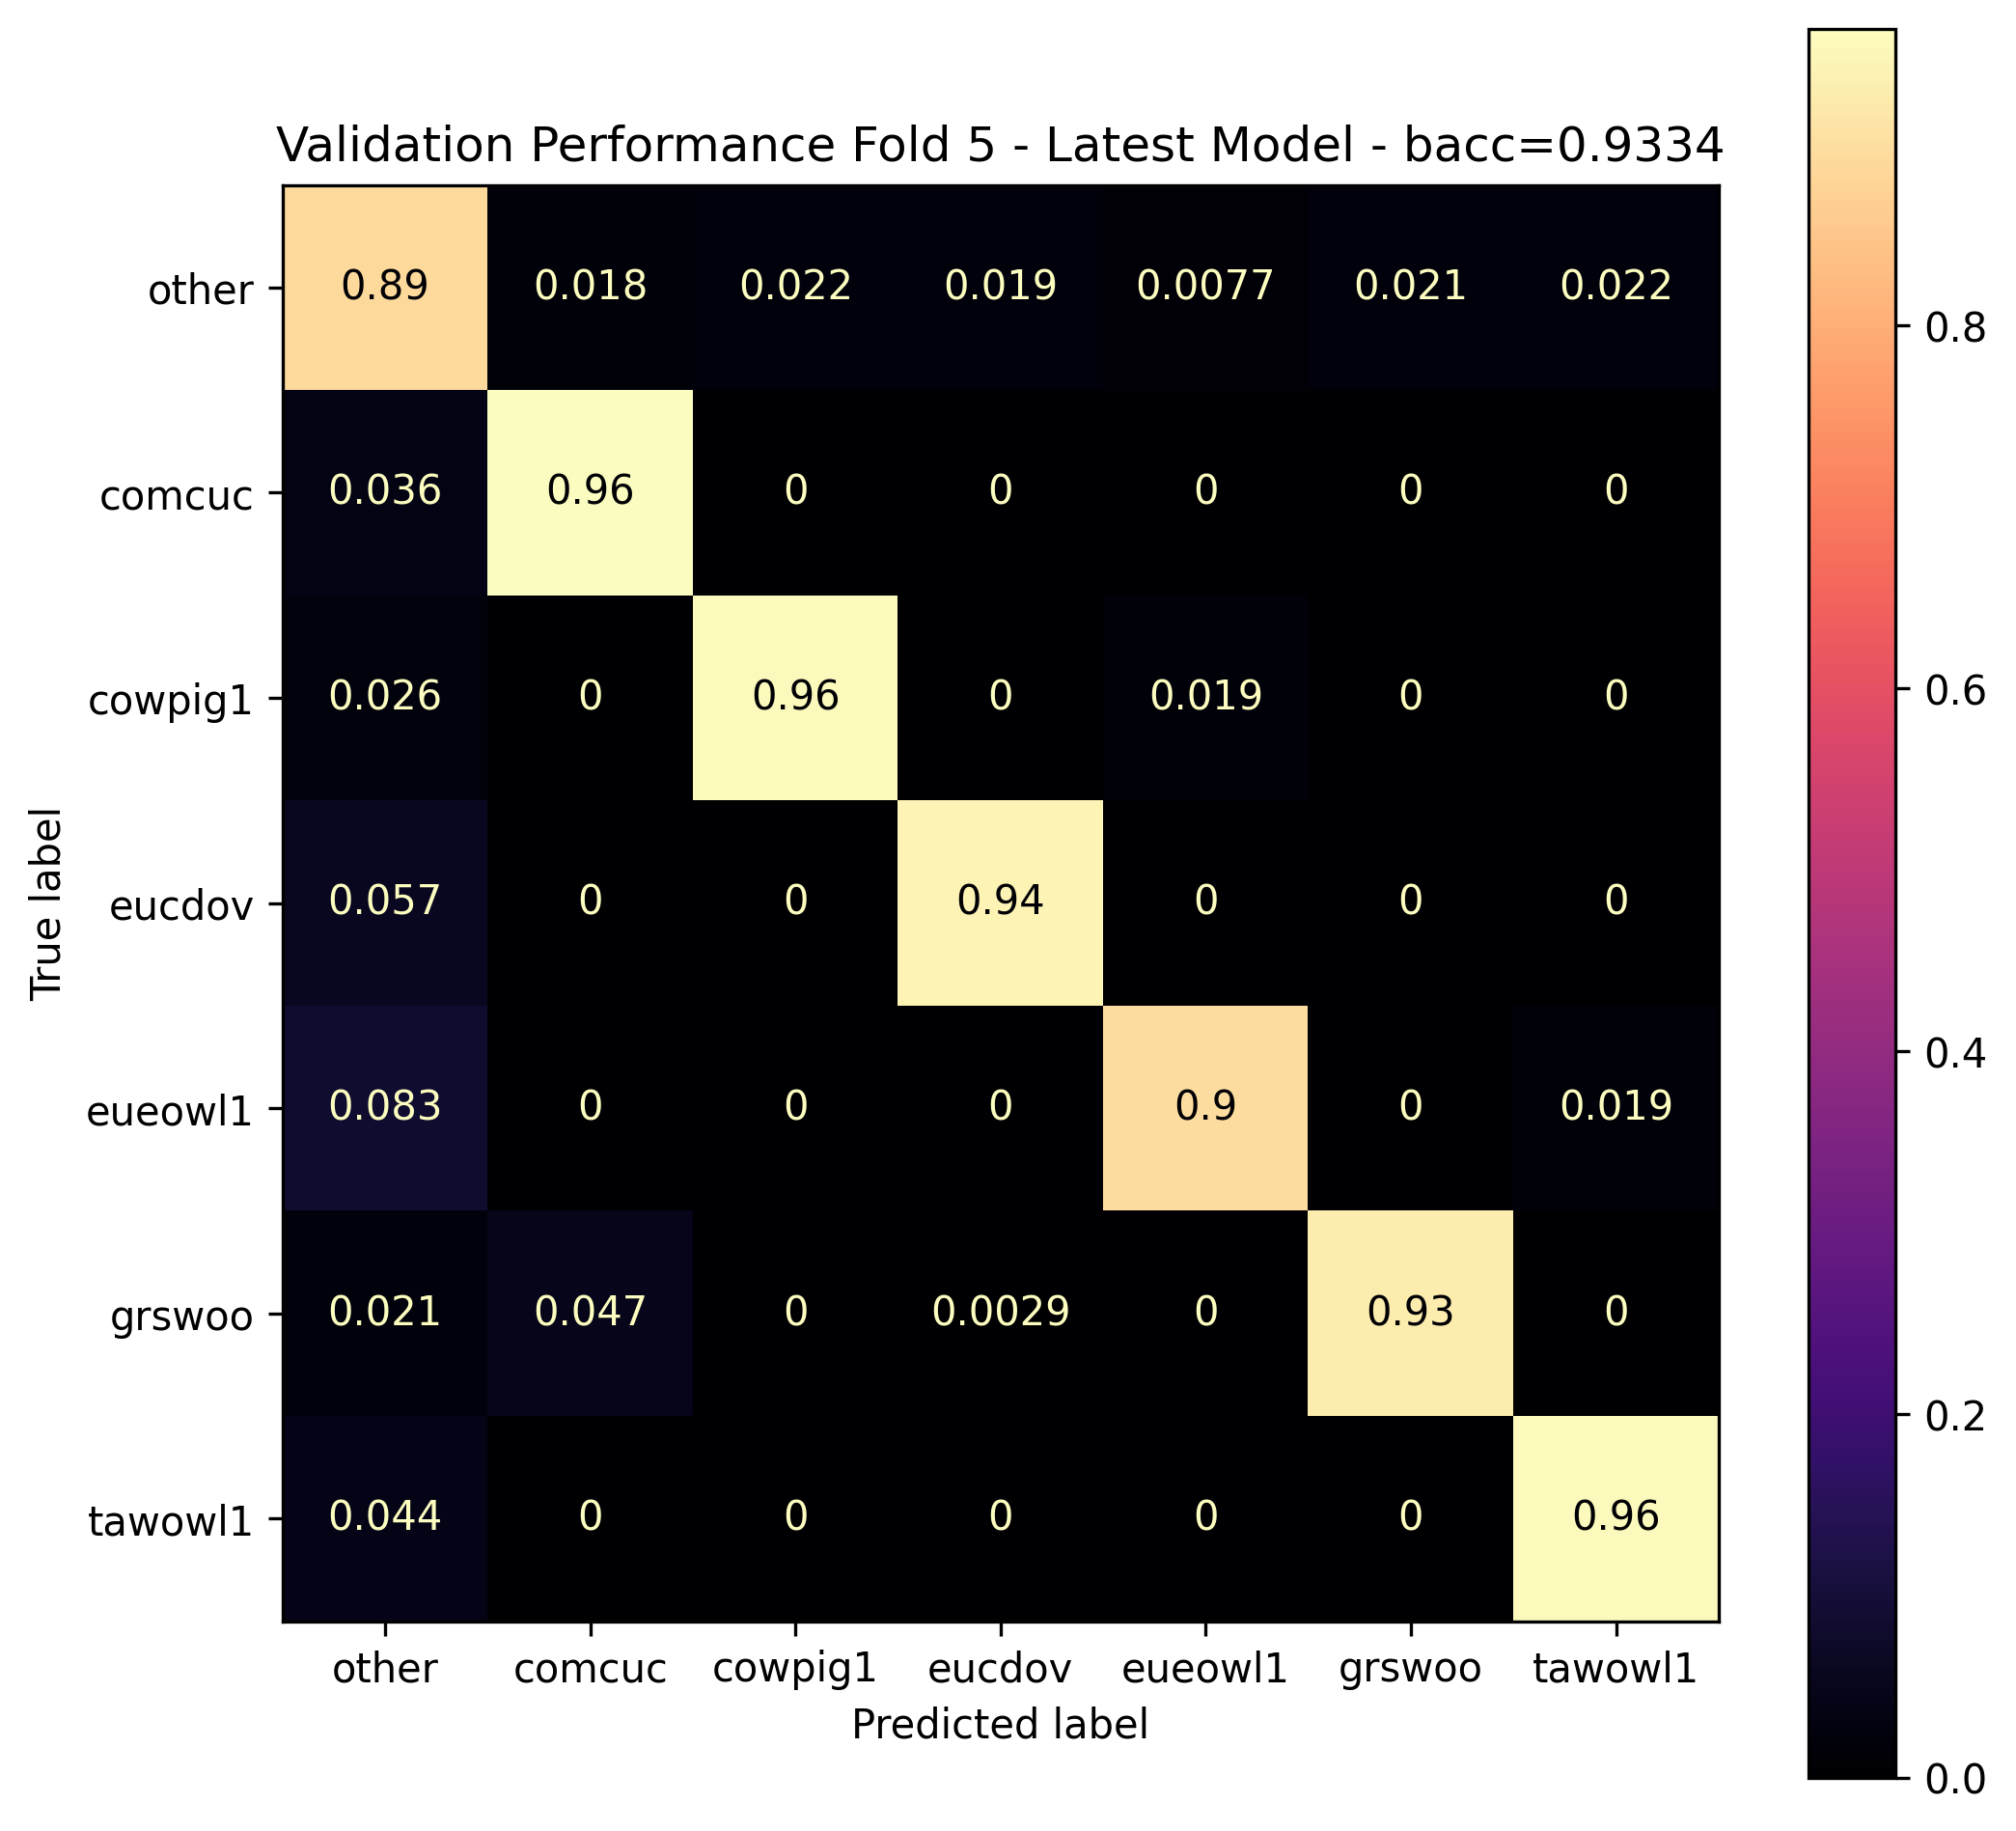

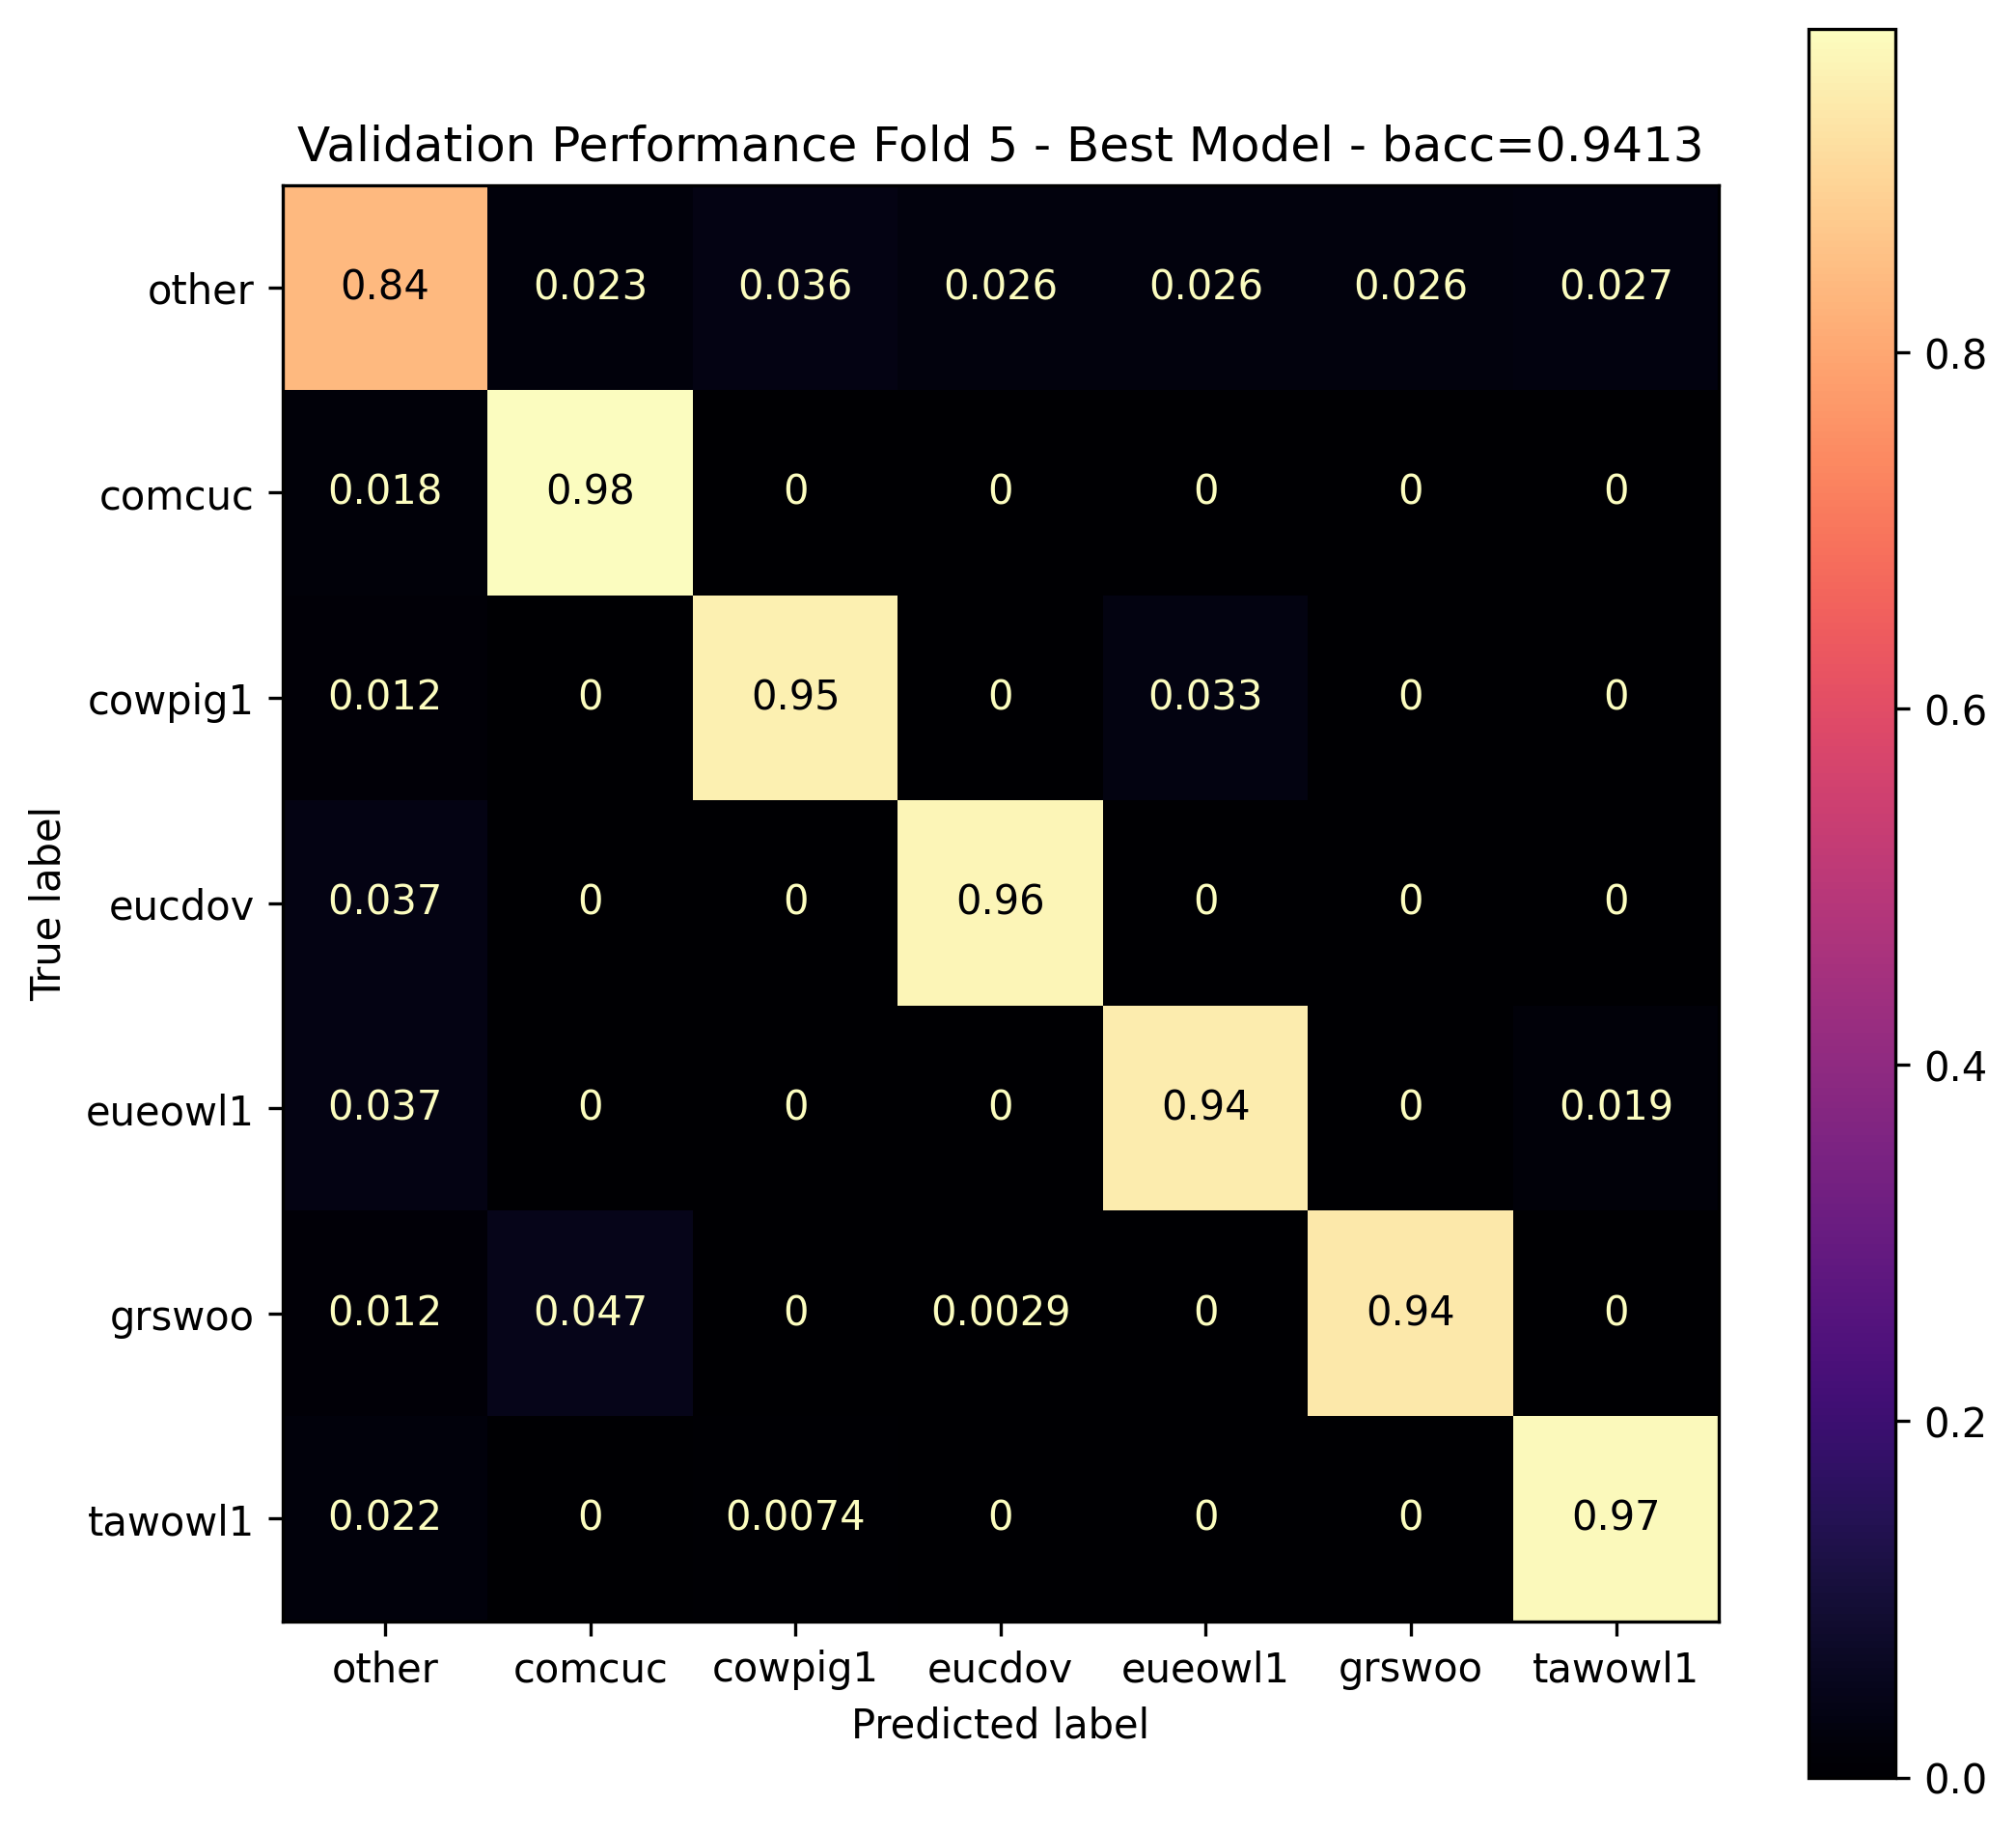

Training fold 6
Training AttentionClassifier with 50643 parameters
train label counts = [61356, 4053, 6671, 5896, 1753, 3469, 3202]
loss weights = [1.0, 15.14, 9.2, 10.41, 35.0, 17.69, 19.16]
eval label counts = [7111, 416, 648, 671, 123, 348, 283]
eval loss weights = [1.0, 17.09, 10.97, 10.6, 57.81, 20.43, 25.13]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000506, num_samples = 86400, num_correct =  9954, acc = 0.115208, bacc = 0.281920
Evaluation Epoch   1/35 : avg_loss = 0.000514, num_samples =  9600, num_correct =  1887, acc = 0.196563, bacc = 0.608941
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000280, num_samples = 86400, num_correct = 22939, acc = 0.265498, bacc = 0.670625
Evaluation Epoch   2/35 : avg_loss = 0.000452, num_samples =  9600, num_correct =  2989, acc = 0.311354, bacc = 0.764510
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000205, num_samples = 86400, num_correct = 33852, acc = 0.391806, bacc = 0.756259
Evaluation Epoch   3/35 : avg_loss = 0.000312, num_

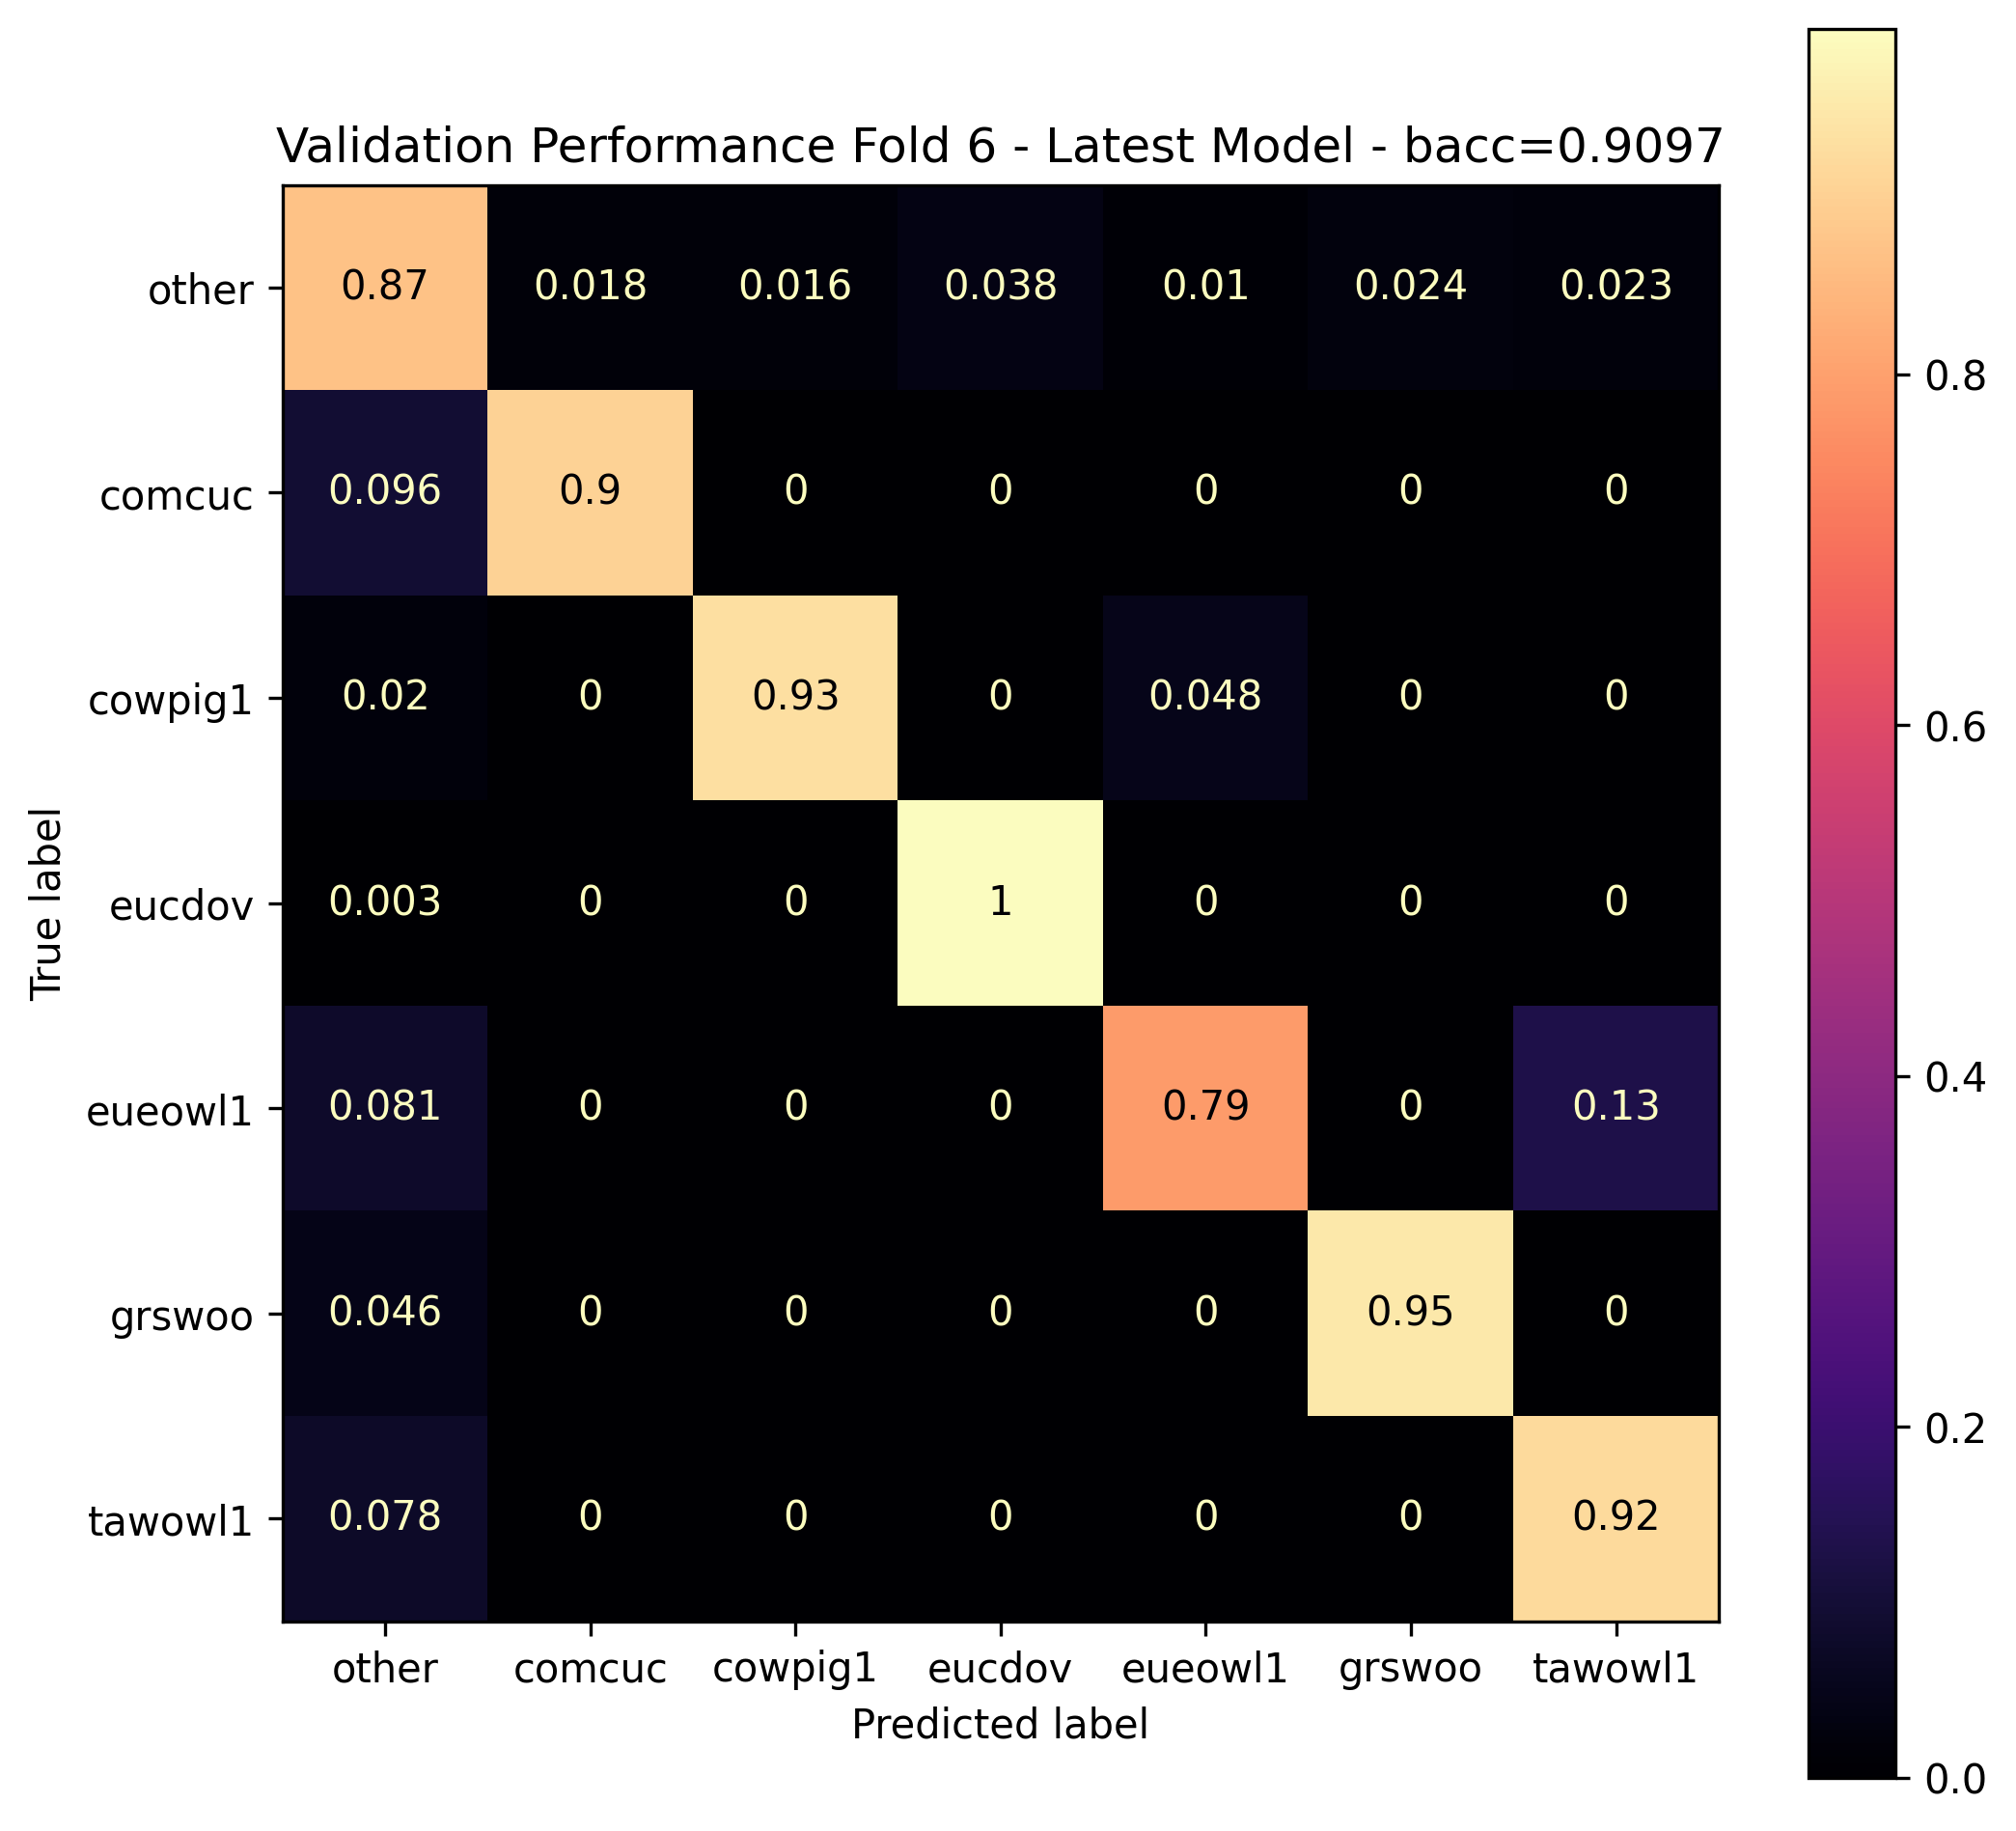

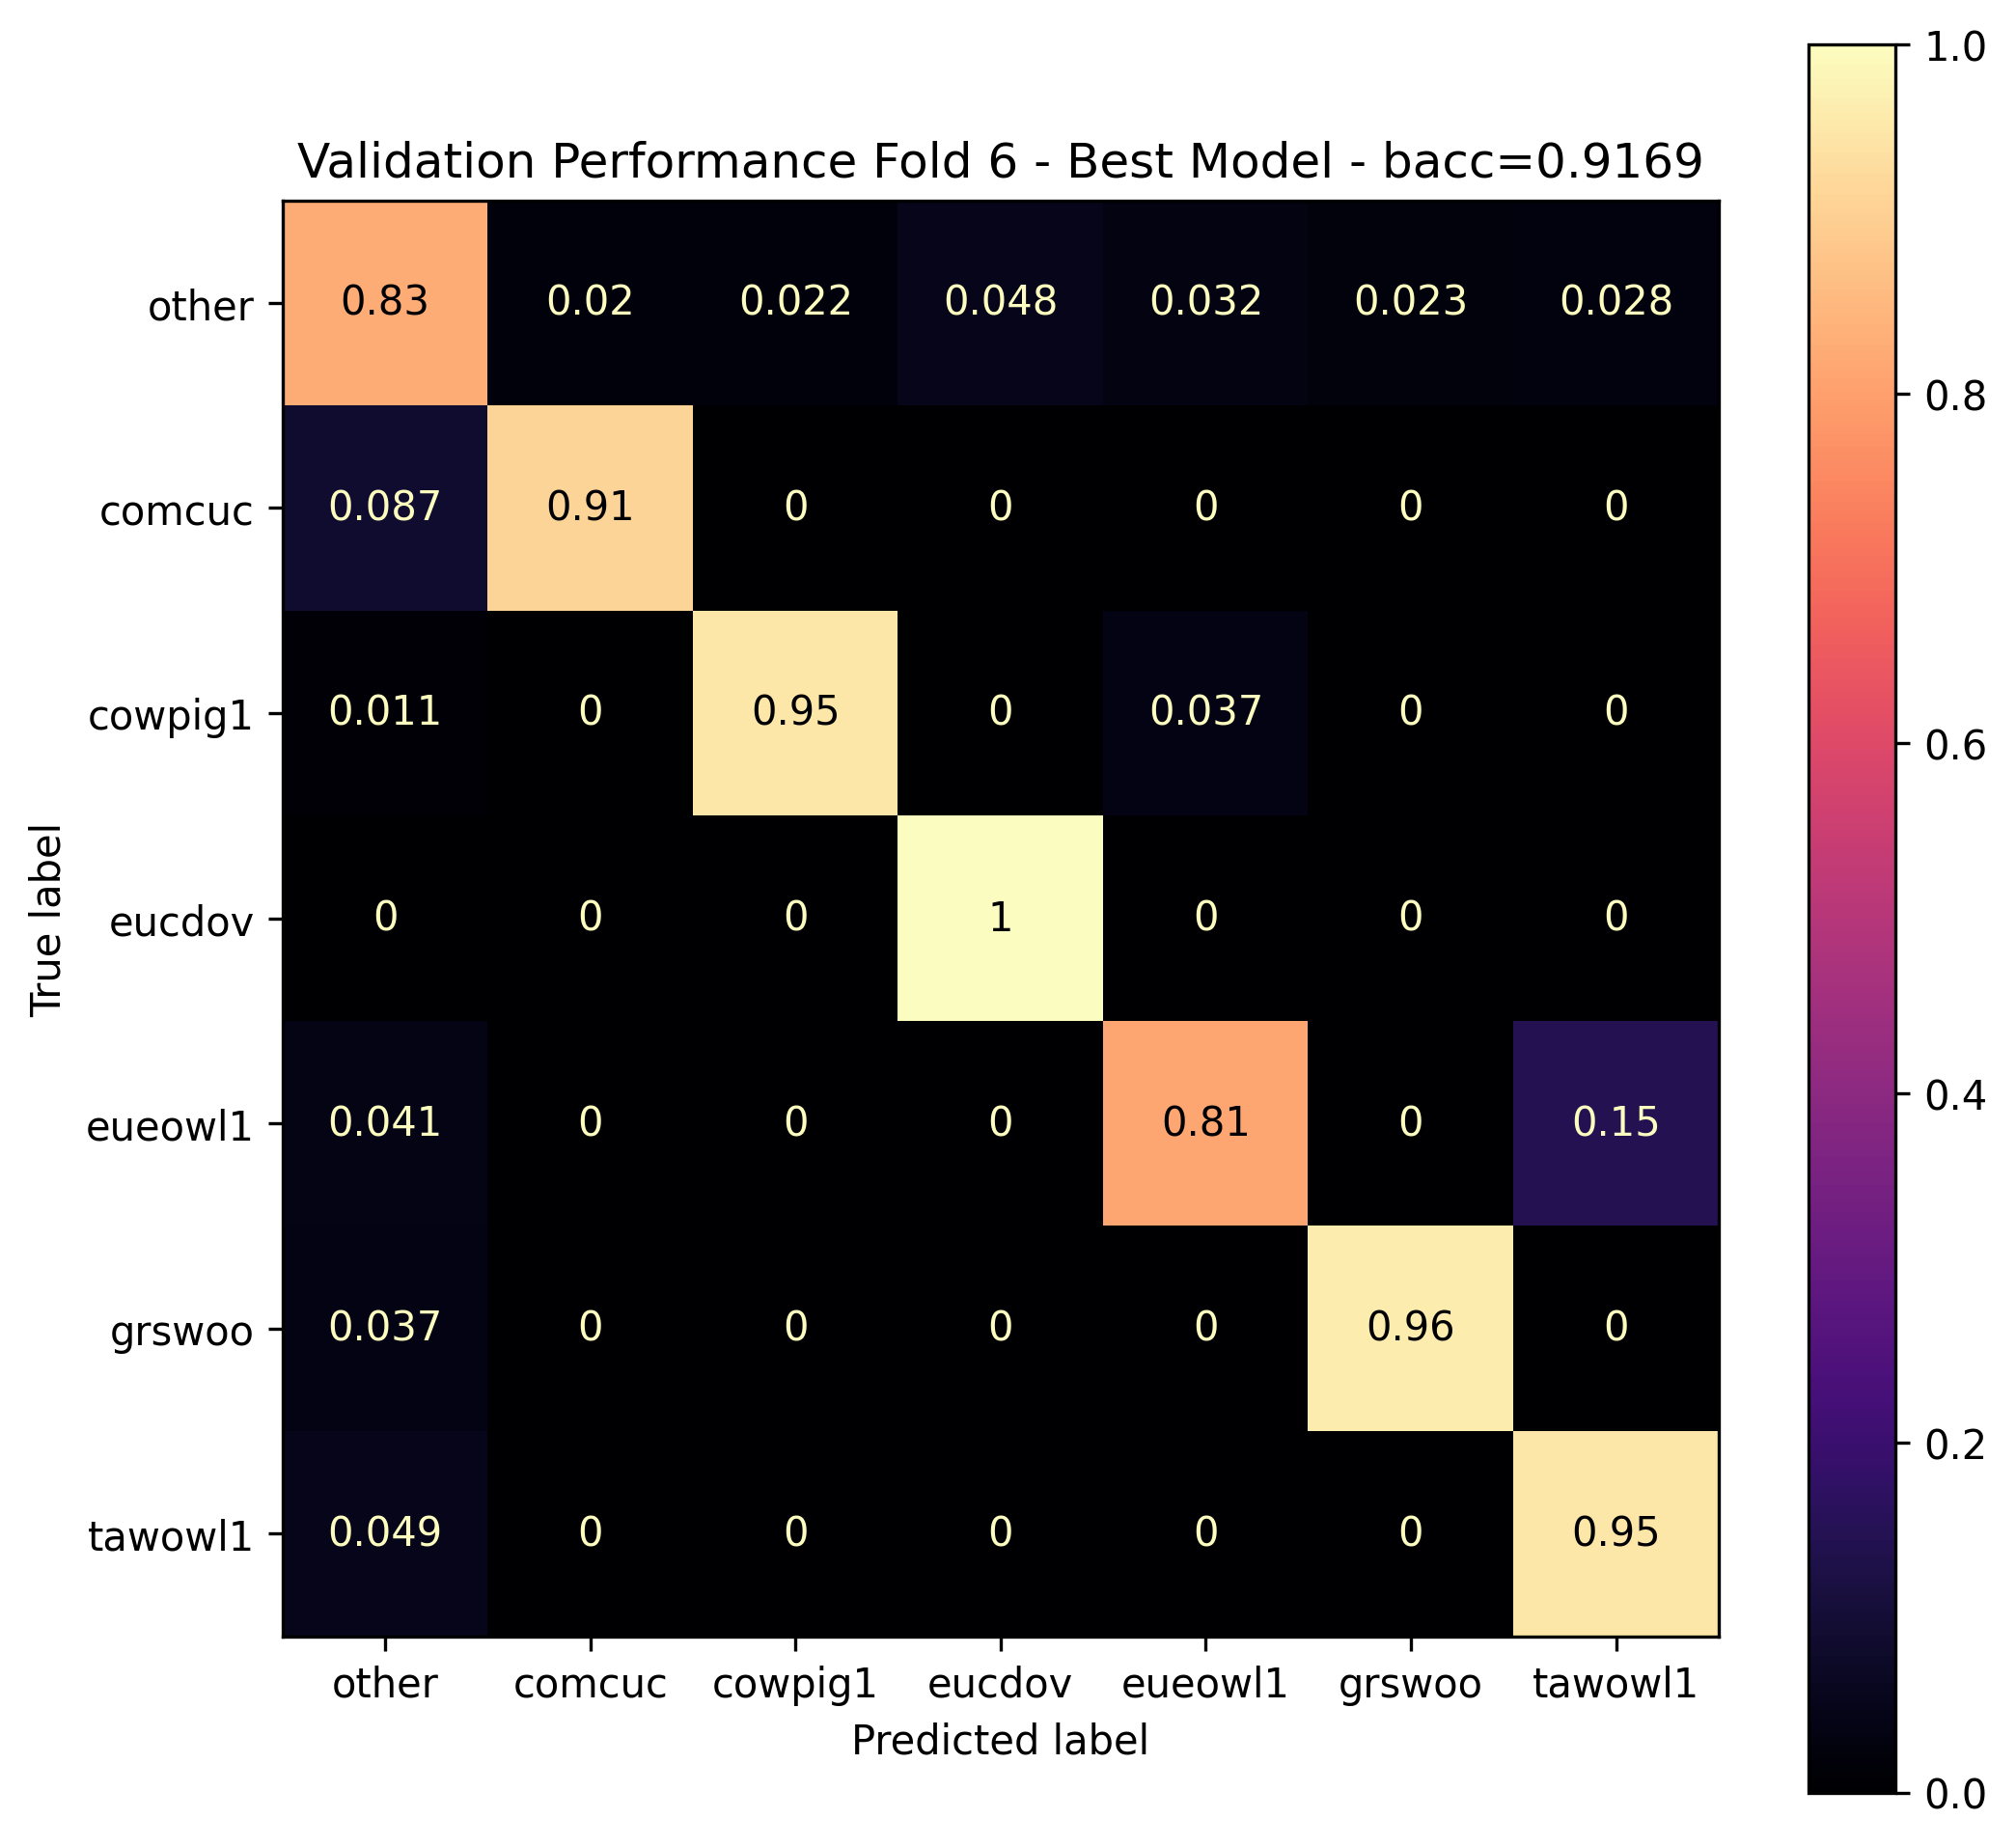

Training fold 7
Training AttentionClassifier with 50643 parameters
train label counts = [61752, 4049, 6580, 5857, 1674, 3375, 3113]
loss weights = [1.0, 15.25, 9.38, 10.54, 36.89, 18.3, 19.84]
eval label counts = [6715, 420, 739, 710, 202, 442, 372]
eval loss weights = [1.0, 15.99, 9.09, 9.46, 33.24, 15.19, 18.05]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000508, num_samples = 86400, num_correct = 10218, acc = 0.118264, bacc = 0.256596
Evaluation Epoch   1/35 : avg_loss = 0.000548, num_samples =  9600, num_correct =  1659, acc = 0.172813, bacc = 0.514025
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000291, num_samples = 86400, num_correct = 21527, acc = 0.249155, bacc = 0.604226
Evaluation Epoch   2/35 : avg_loss = 0.000337, num_samples =  9600, num_correct =  4367, acc = 0.454896, bacc = 0.700169
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000215, num_samples = 86400, num_correct = 44497, acc = 0.515012, bacc = 0.741410
Evaluation Epoch   3/35 : avg_loss = 0.000351, num_

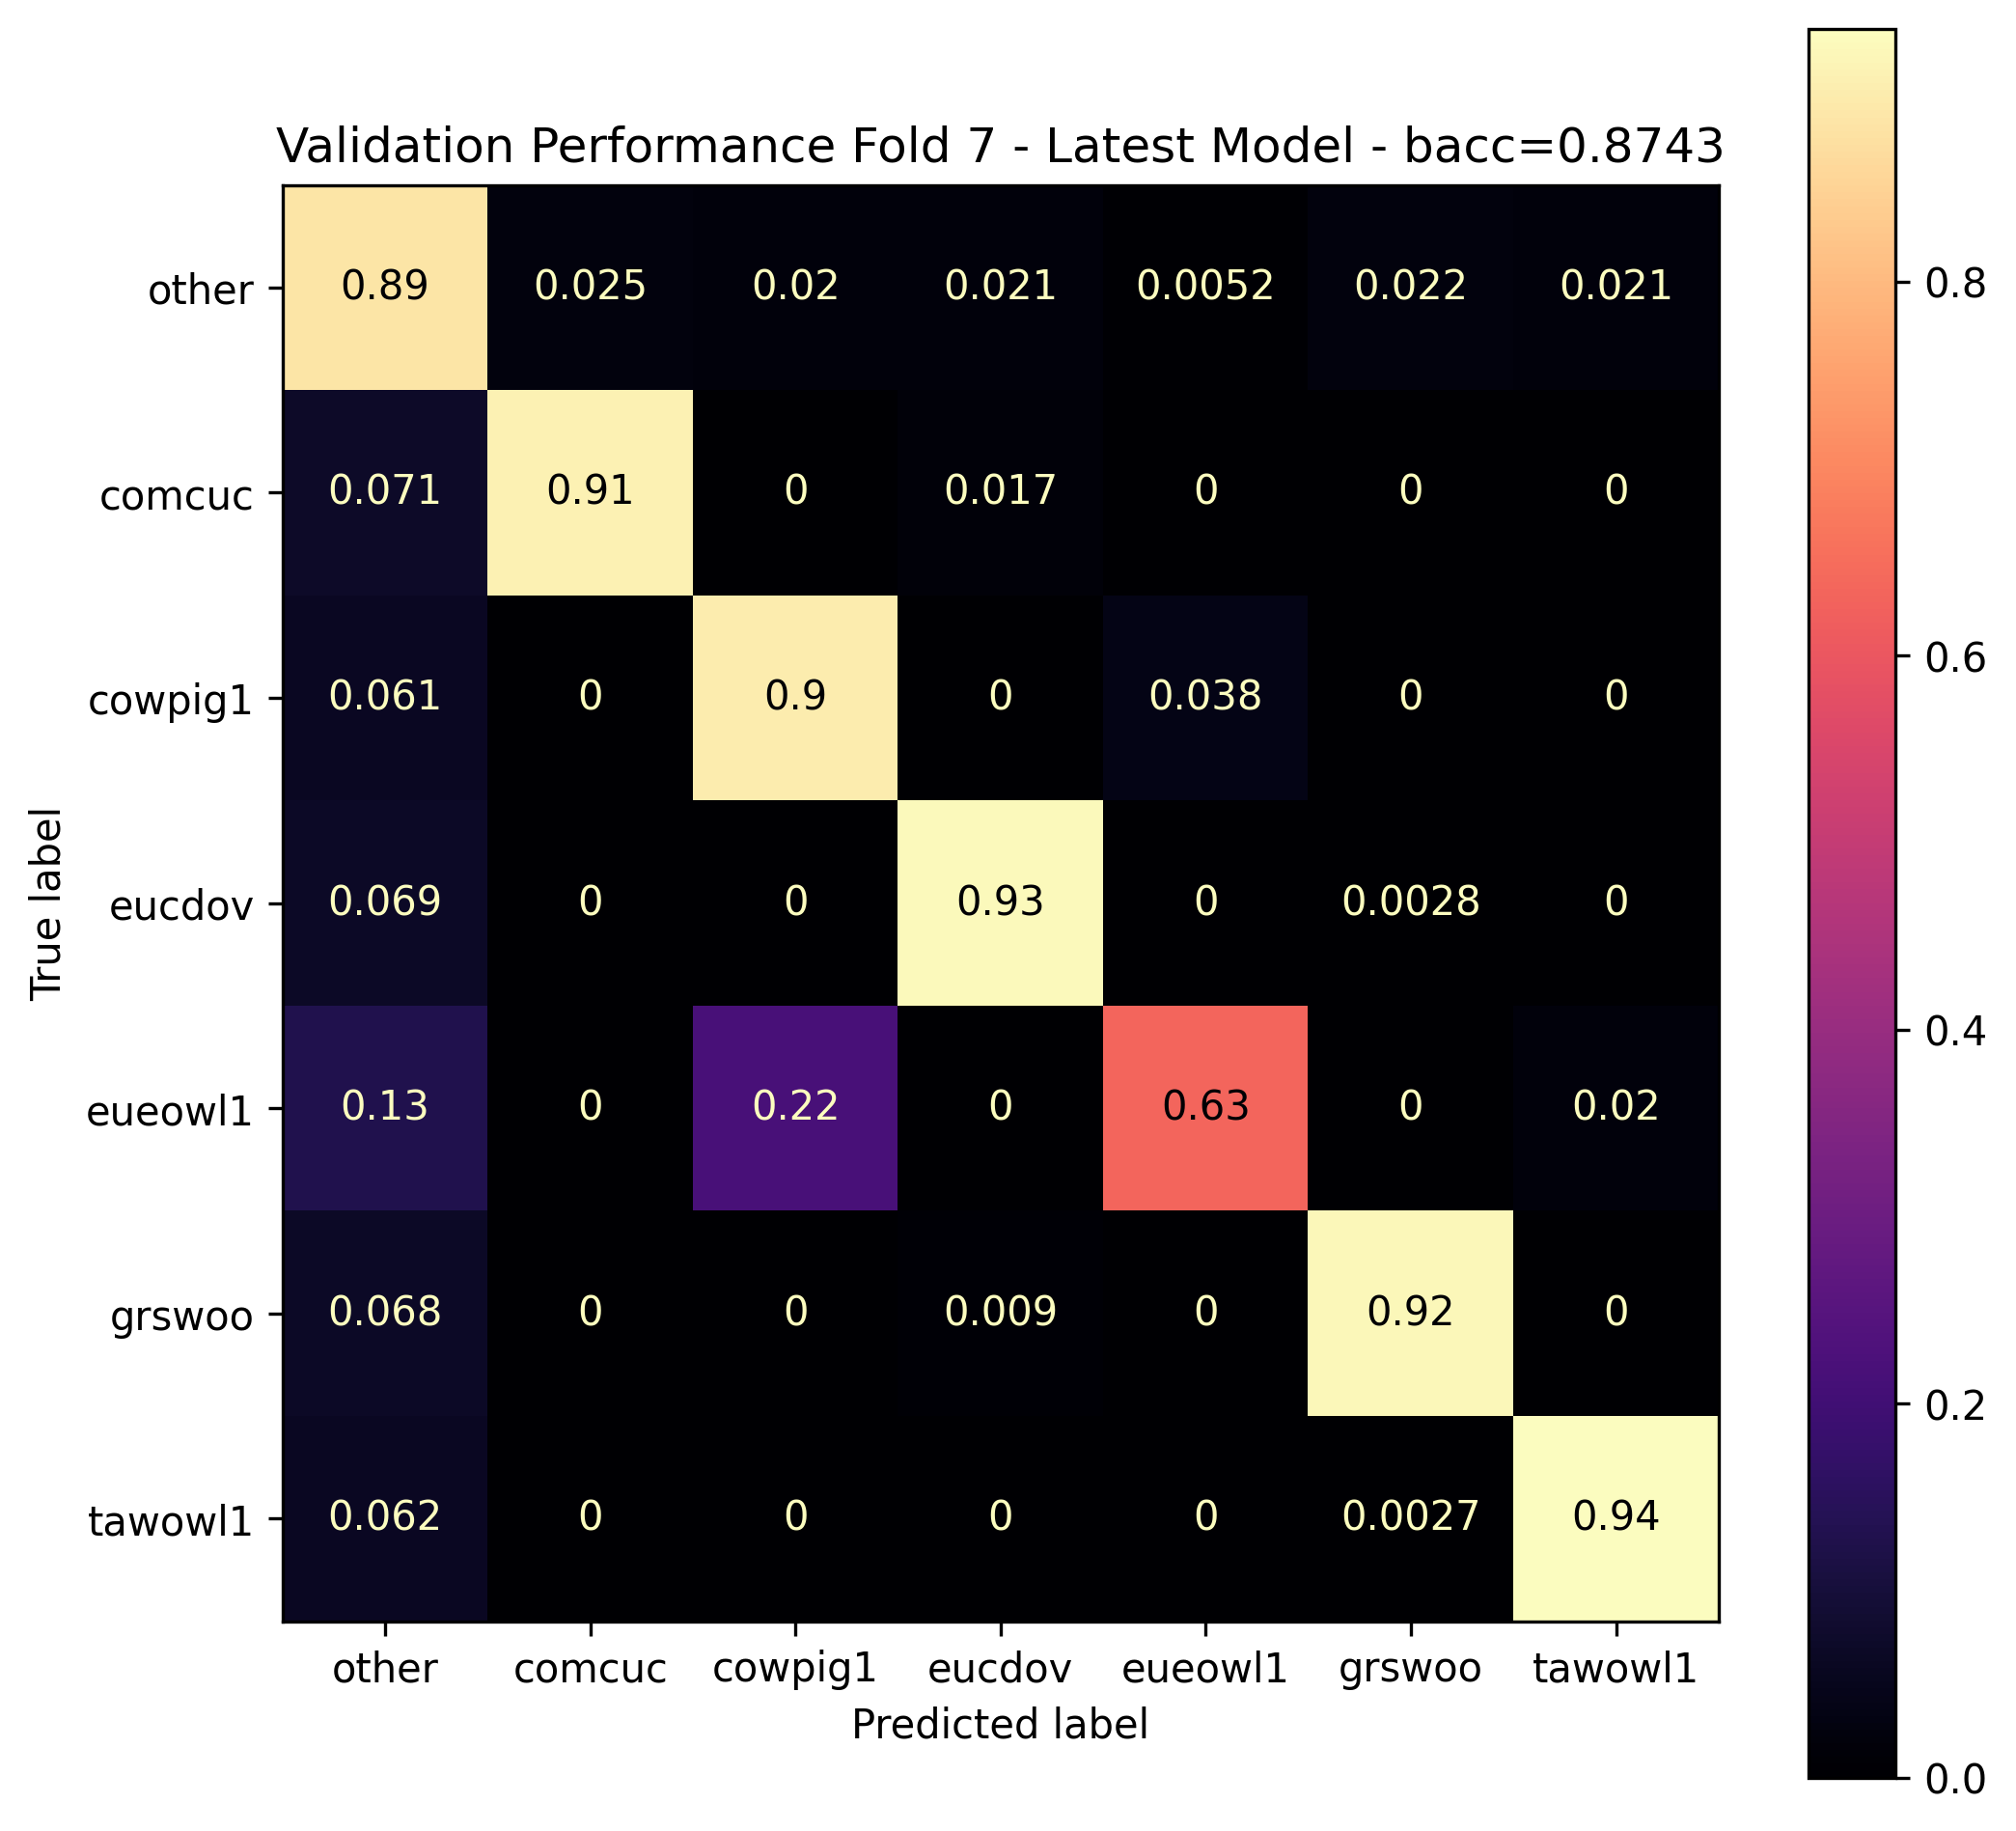

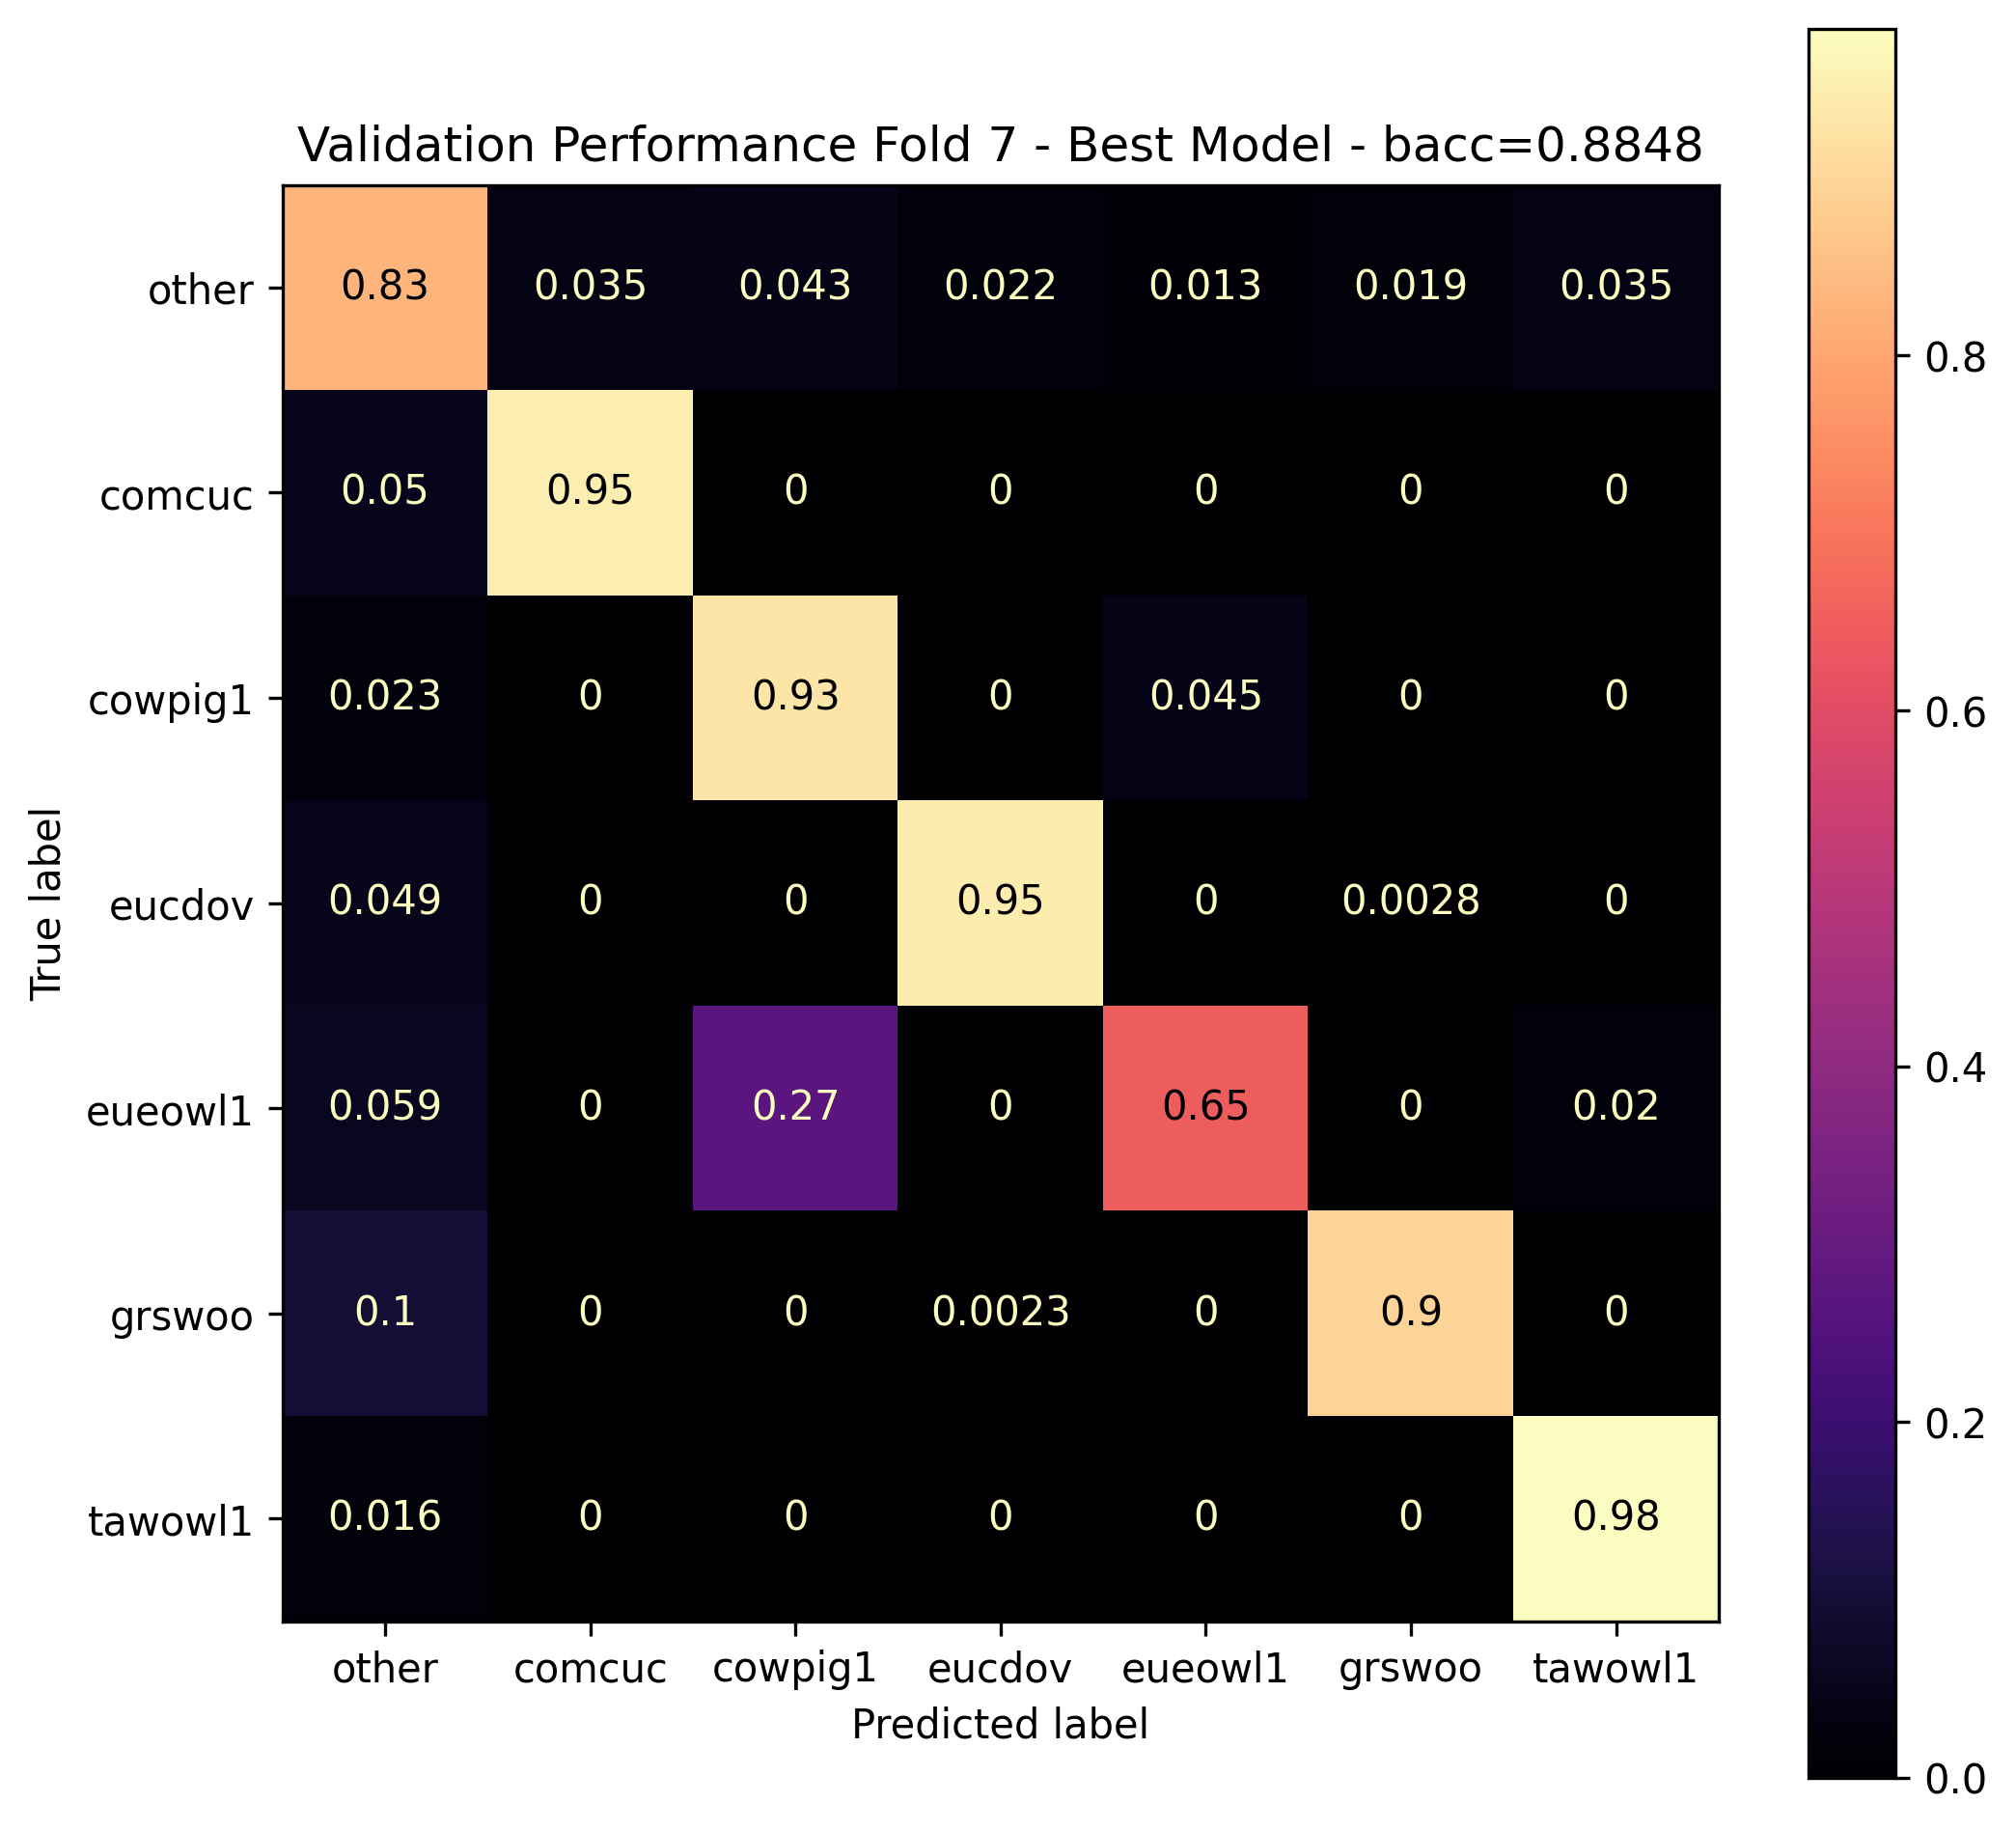

Training fold 8
Training AttentionClassifier with 50643 parameters
train label counts = [61765, 4005, 6420, 5926, 1678, 3488, 3118]
loss weights = [1.0, 15.42, 9.62, 10.42, 36.81, 17.71, 19.81]
eval label counts = [6702, 464, 899, 641, 198, 329, 367]
eval loss weights = [1.0, 14.44, 7.45, 10.46, 33.85, 20.37, 18.26]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000519, num_samples = 86400, num_correct = 18575, acc = 0.214988, bacc = 0.292850
Evaluation Epoch   1/35 : avg_loss = 0.021883, num_samples =  9600, num_correct =  2377, acc = 0.247604, bacc = 0.588661
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000292, num_samples = 86400, num_correct = 26078, acc = 0.301829, bacc = 0.652815
Evaluation Epoch   2/35 : avg_loss = 0.066768, num_samples =  9600, num_correct =  3170, acc = 0.330208, bacc = 0.770921
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000196, num_samples = 86400, num_correct = 44068, acc = 0.510046, bacc = 0.787553
Evaluation Epoch   3/35 : avg_loss = 0.041802, nu

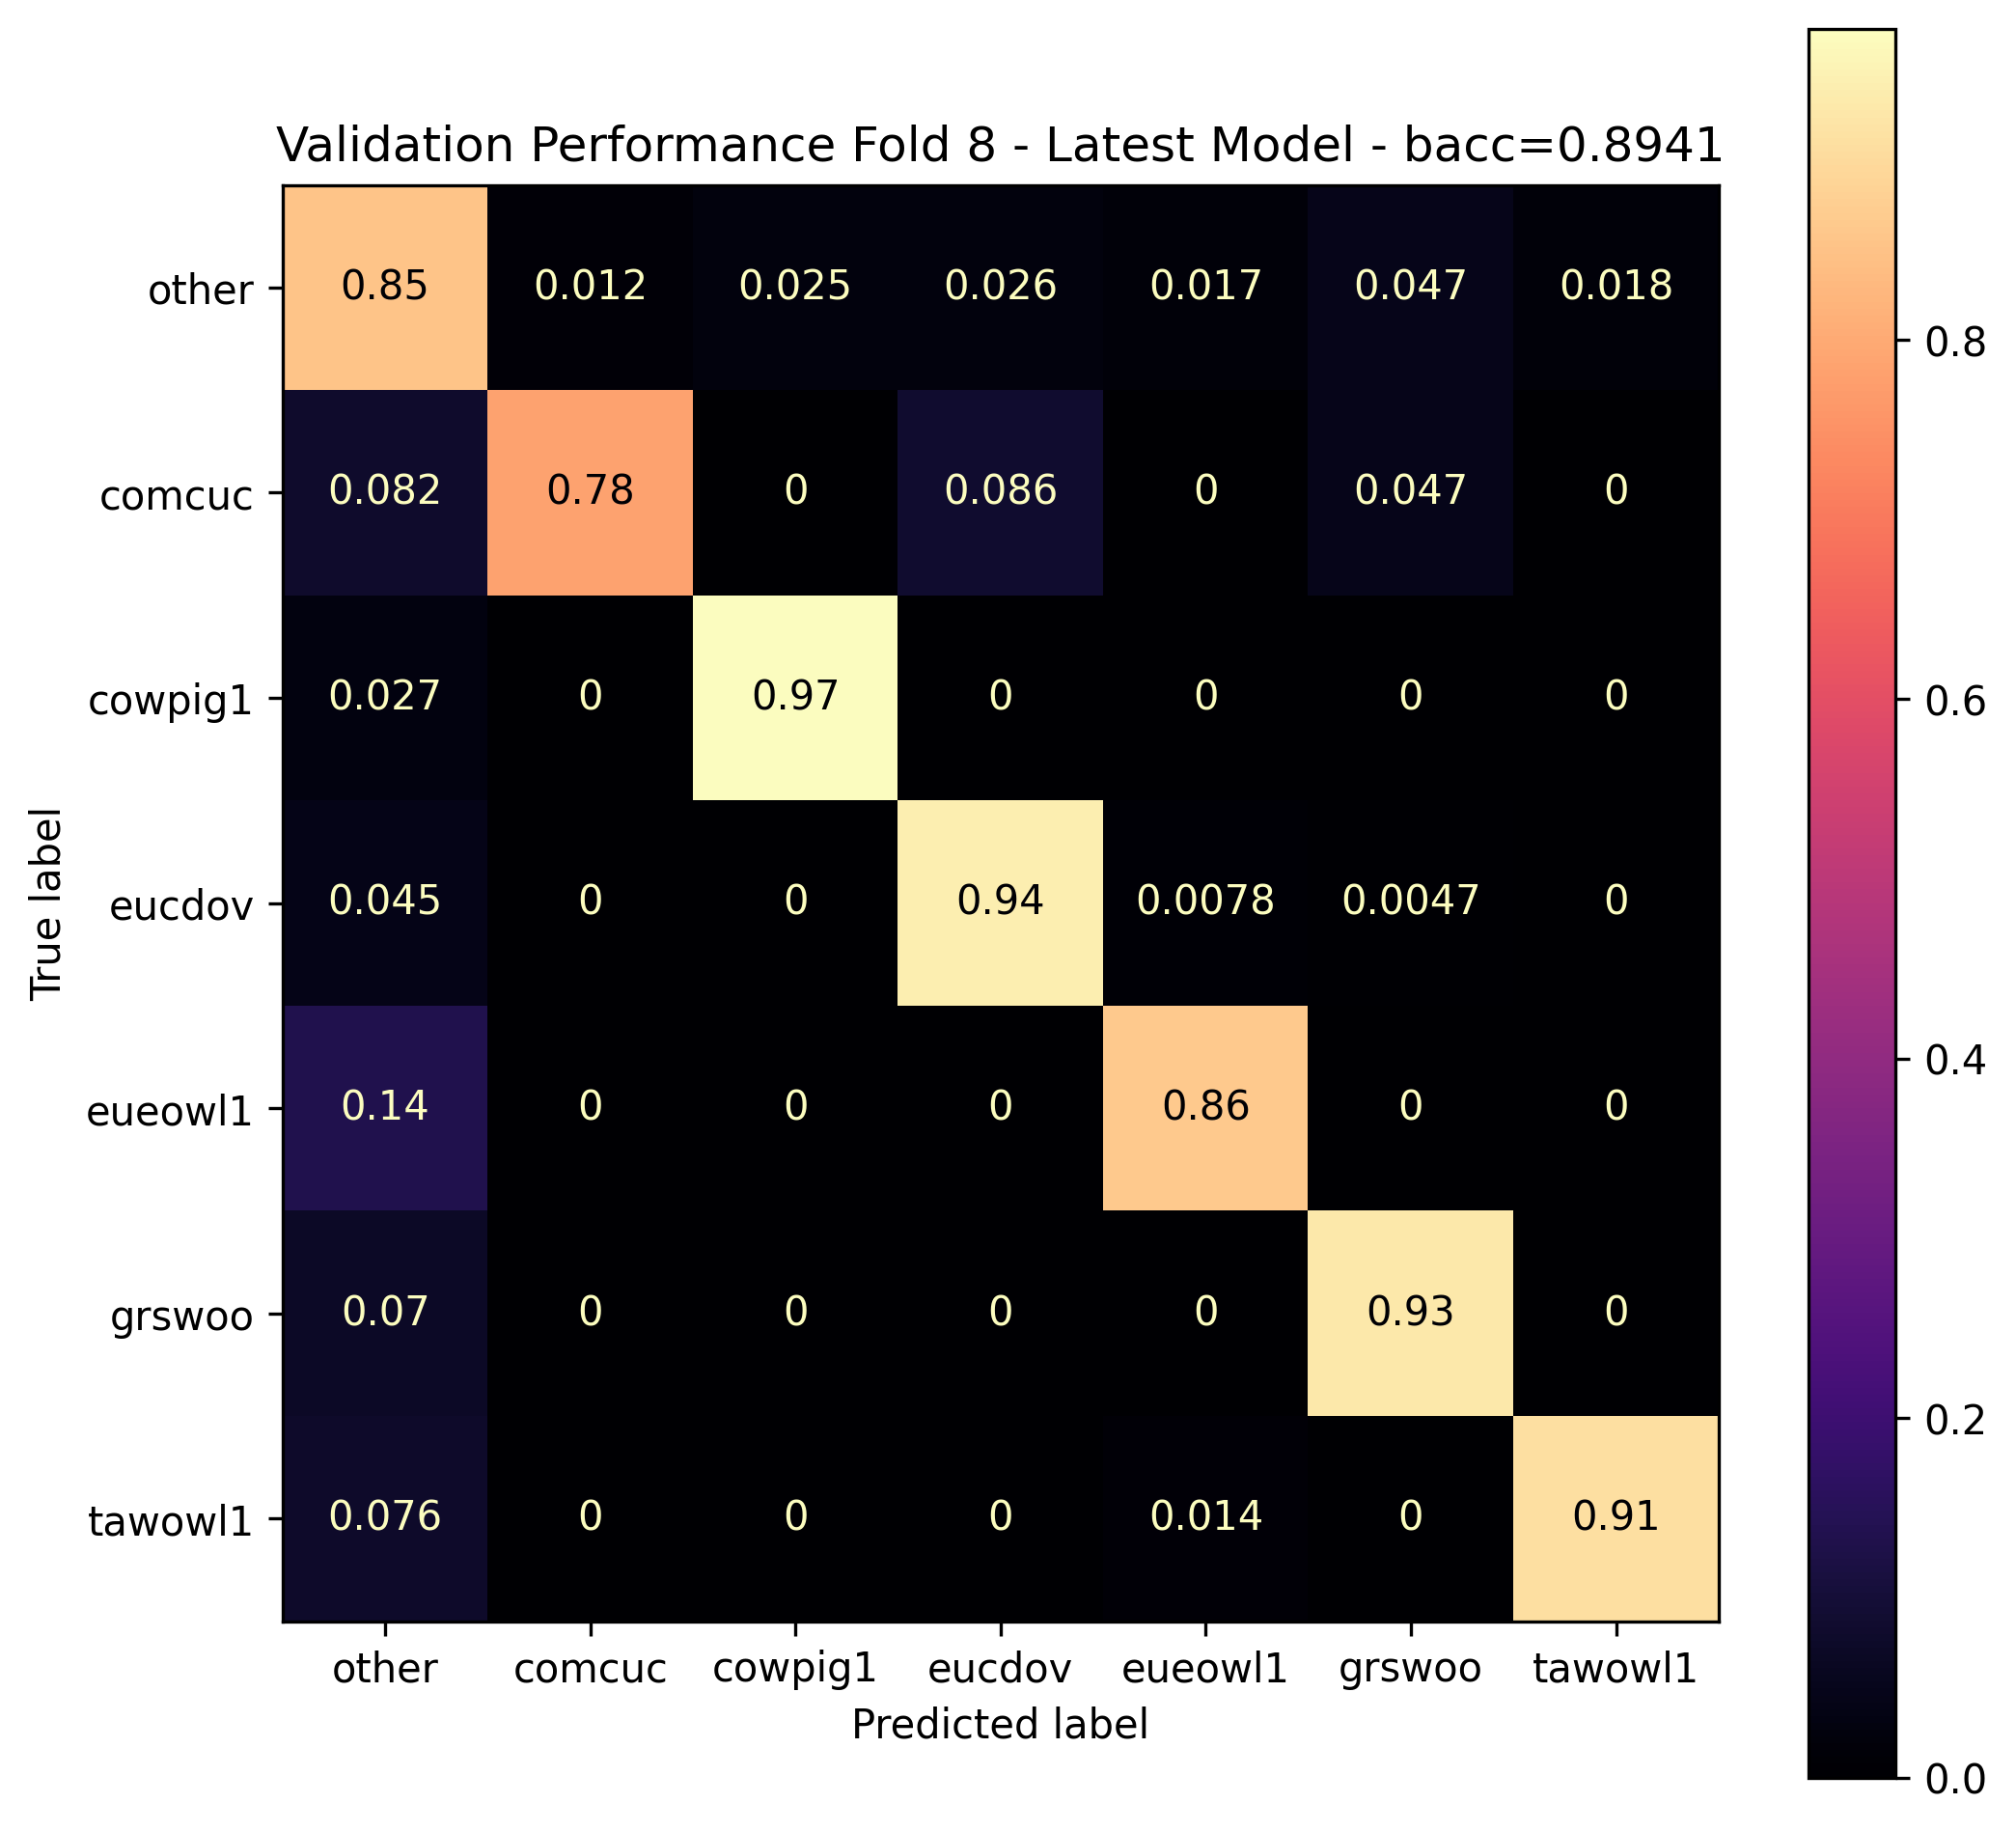

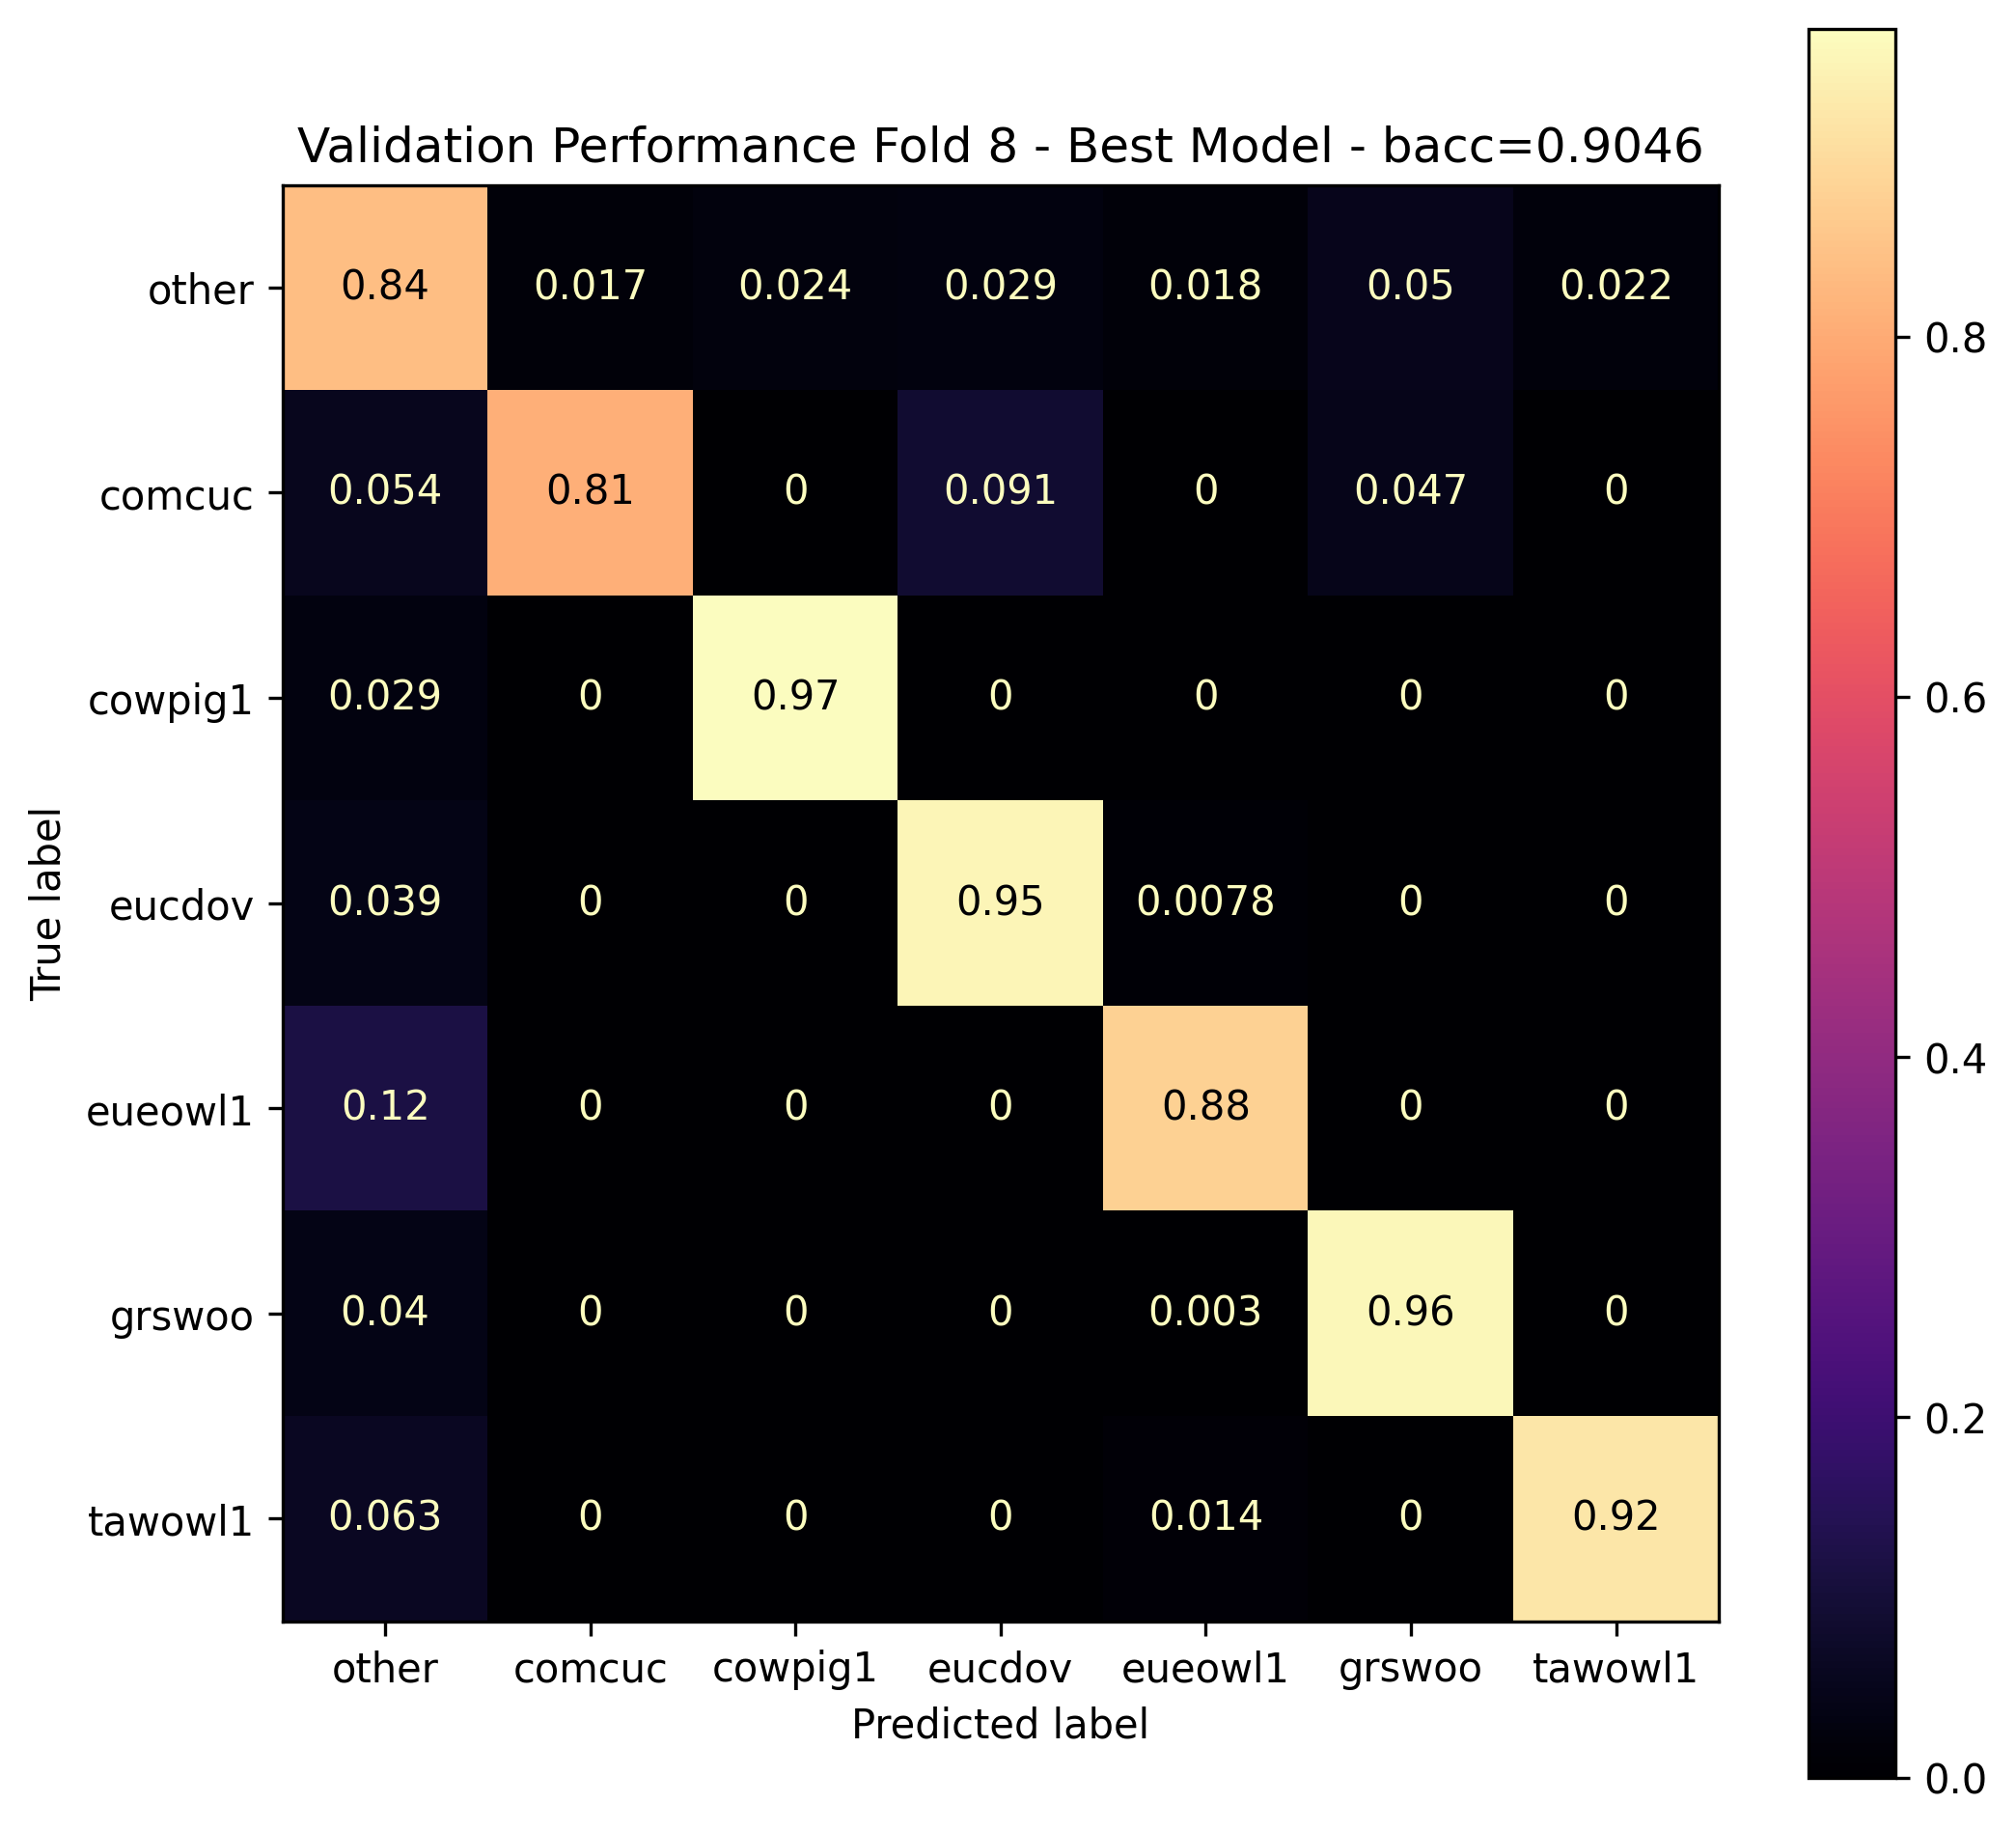

Training fold 9
Training AttentionClassifier with 50643 parameters
train label counts = [61509, 4110, 6580, 5969, 1601, 3510, 3121]
loss weights = [1.0, 14.97, 9.35, 10.3, 38.42, 17.52, 19.71]
eval label counts = [6958, 359, 739, 598, 275, 307, 364]
eval loss weights = [1.0, 19.38, 9.42, 11.64, 25.3, 22.66, 19.12]
Training Epoch   1/35 : lr = 0.01, avg_loss = 0.000509, num_samples = 86400, num_correct = 14914, acc = 0.172616, bacc = 0.285058
Evaluation Epoch   1/35 : avg_loss = 0.000500, num_samples =  9600, num_correct =  2056, acc = 0.214167, bacc = 0.470728
Training Epoch   2/35 : lr = 0.01, avg_loss = 0.000298, num_samples = 86400, num_correct = 24290, acc = 0.281134, bacc = 0.596766
Evaluation Epoch   2/35 : avg_loss = 0.000485, num_samples =  9600, num_correct =  2261, acc = 0.235521, bacc = 0.680650
Training Epoch   3/35 : lr = 0.005, avg_loss = 0.000272, num_samples = 86400, num_correct = 25131, acc = 0.290868, bacc = 0.665787
Evaluation Epoch   3/35 : avg_loss = 0.000408, num_

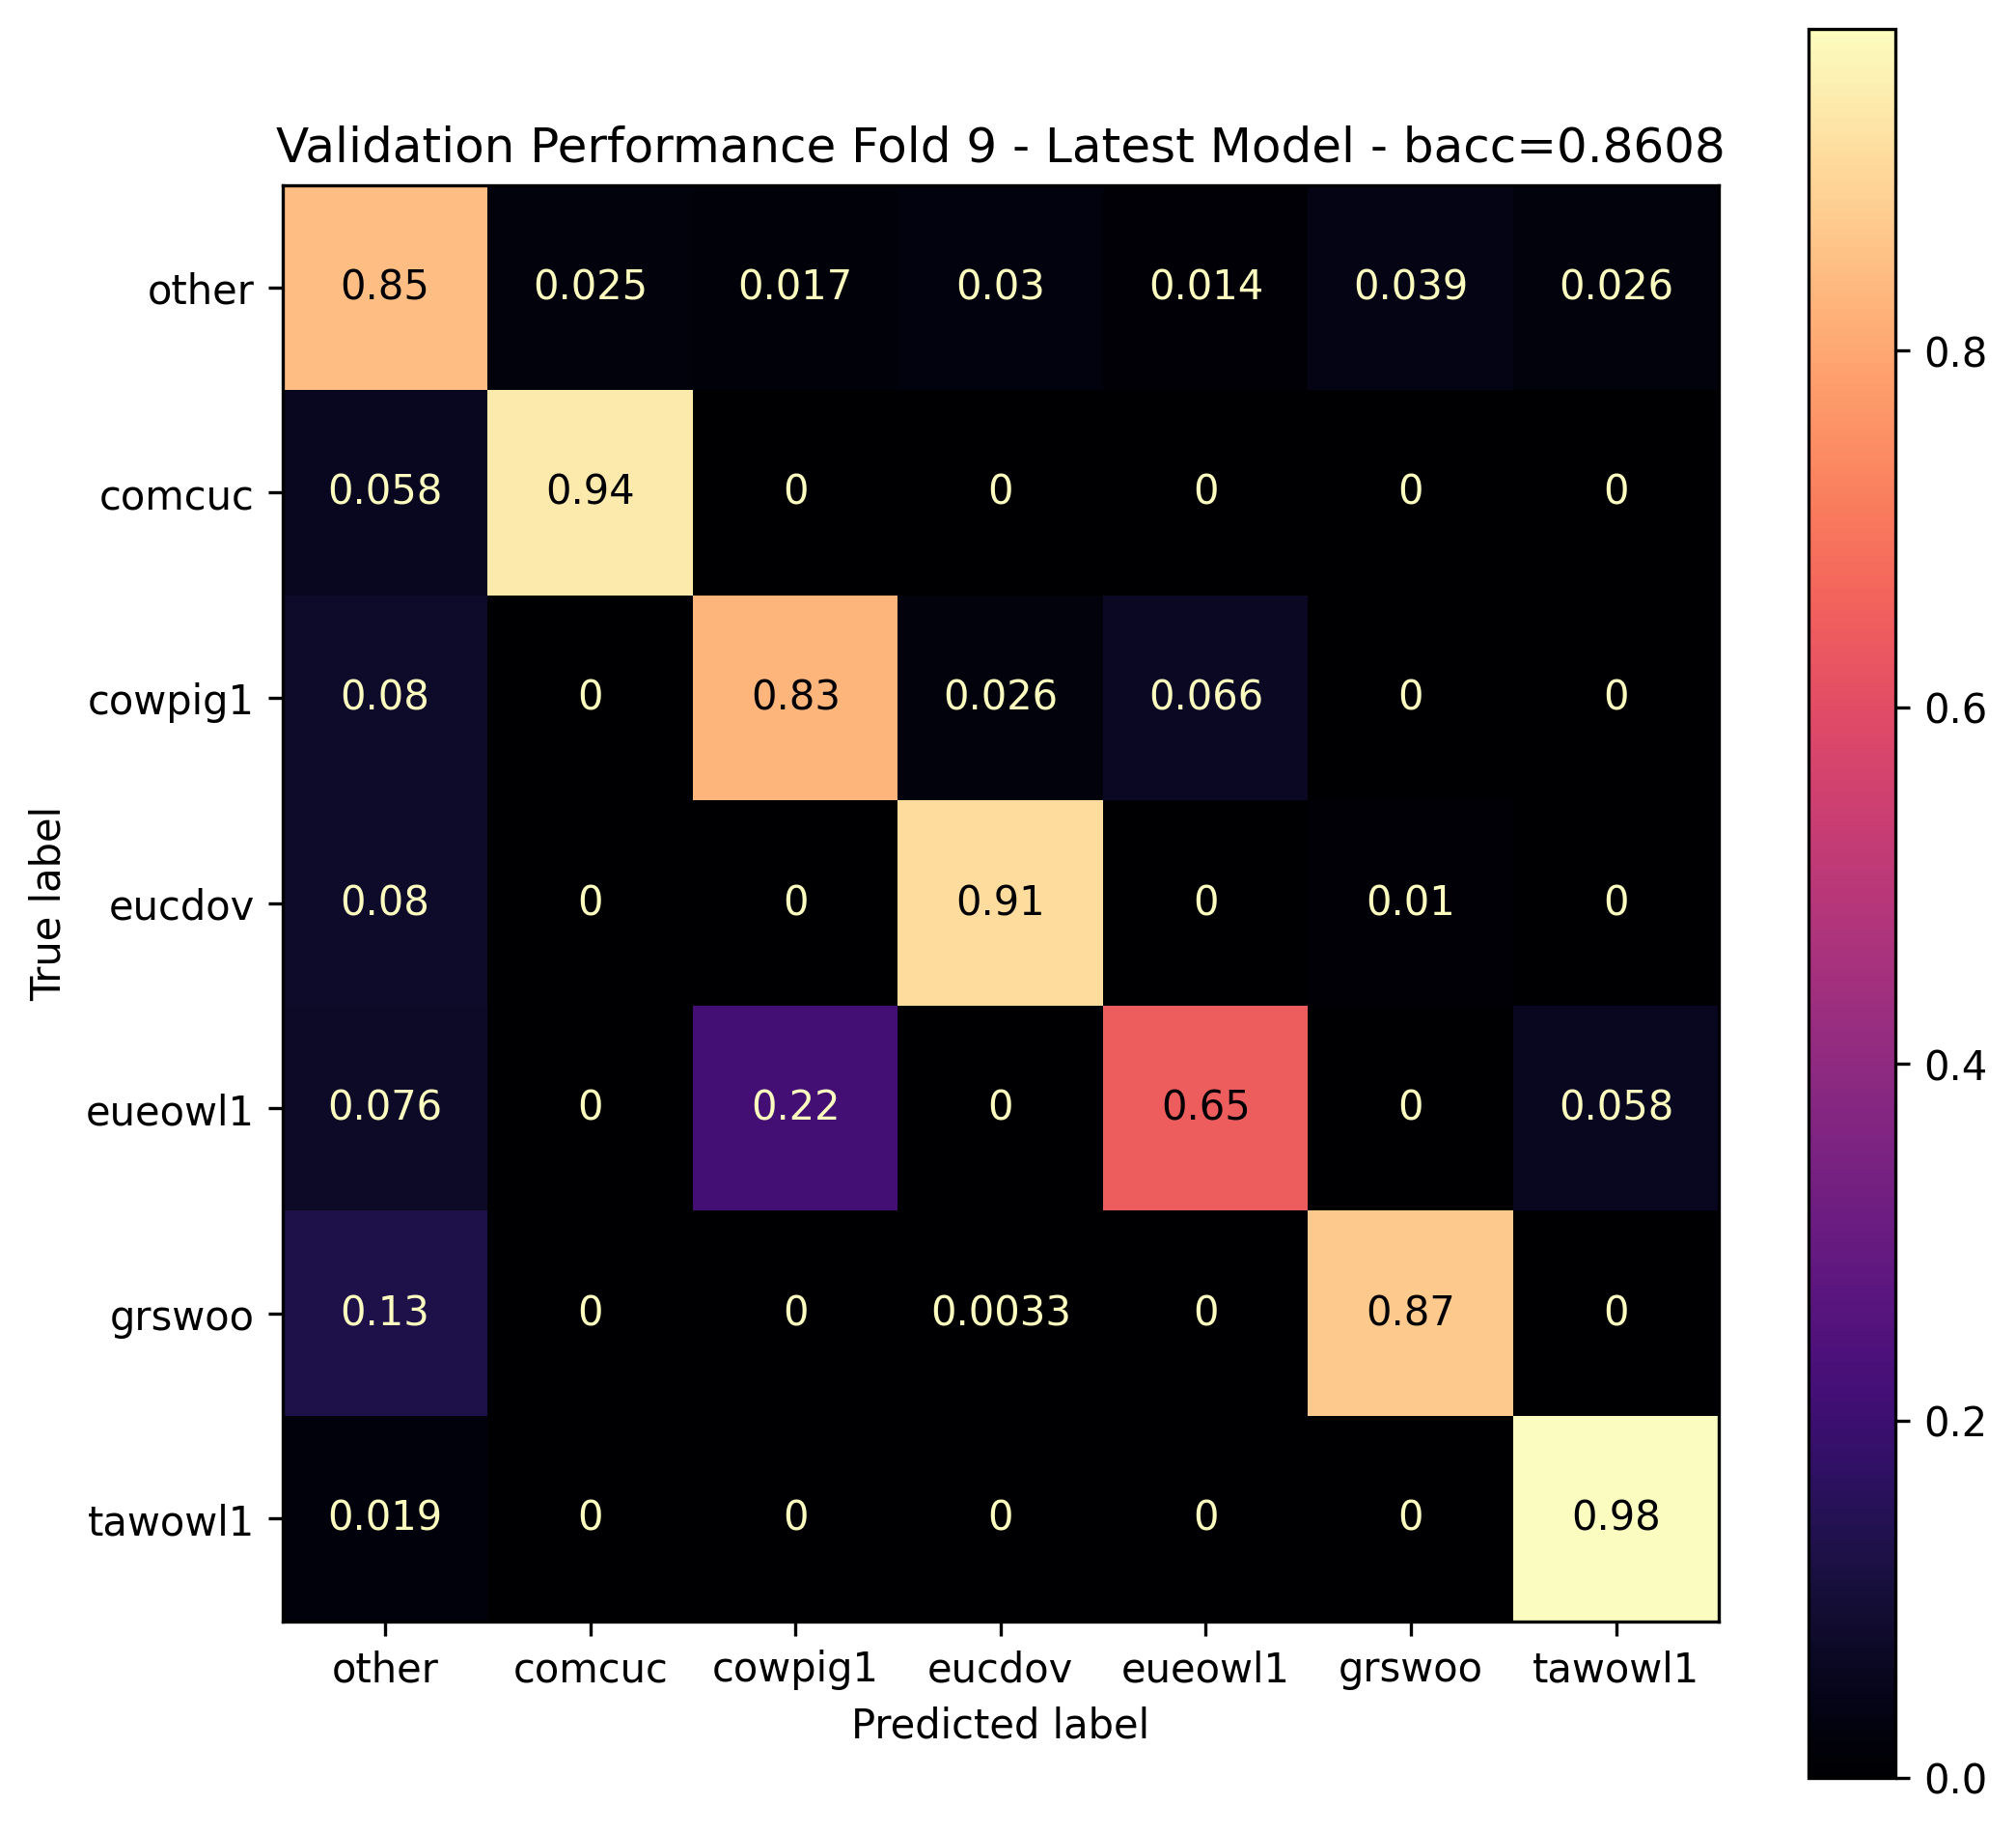

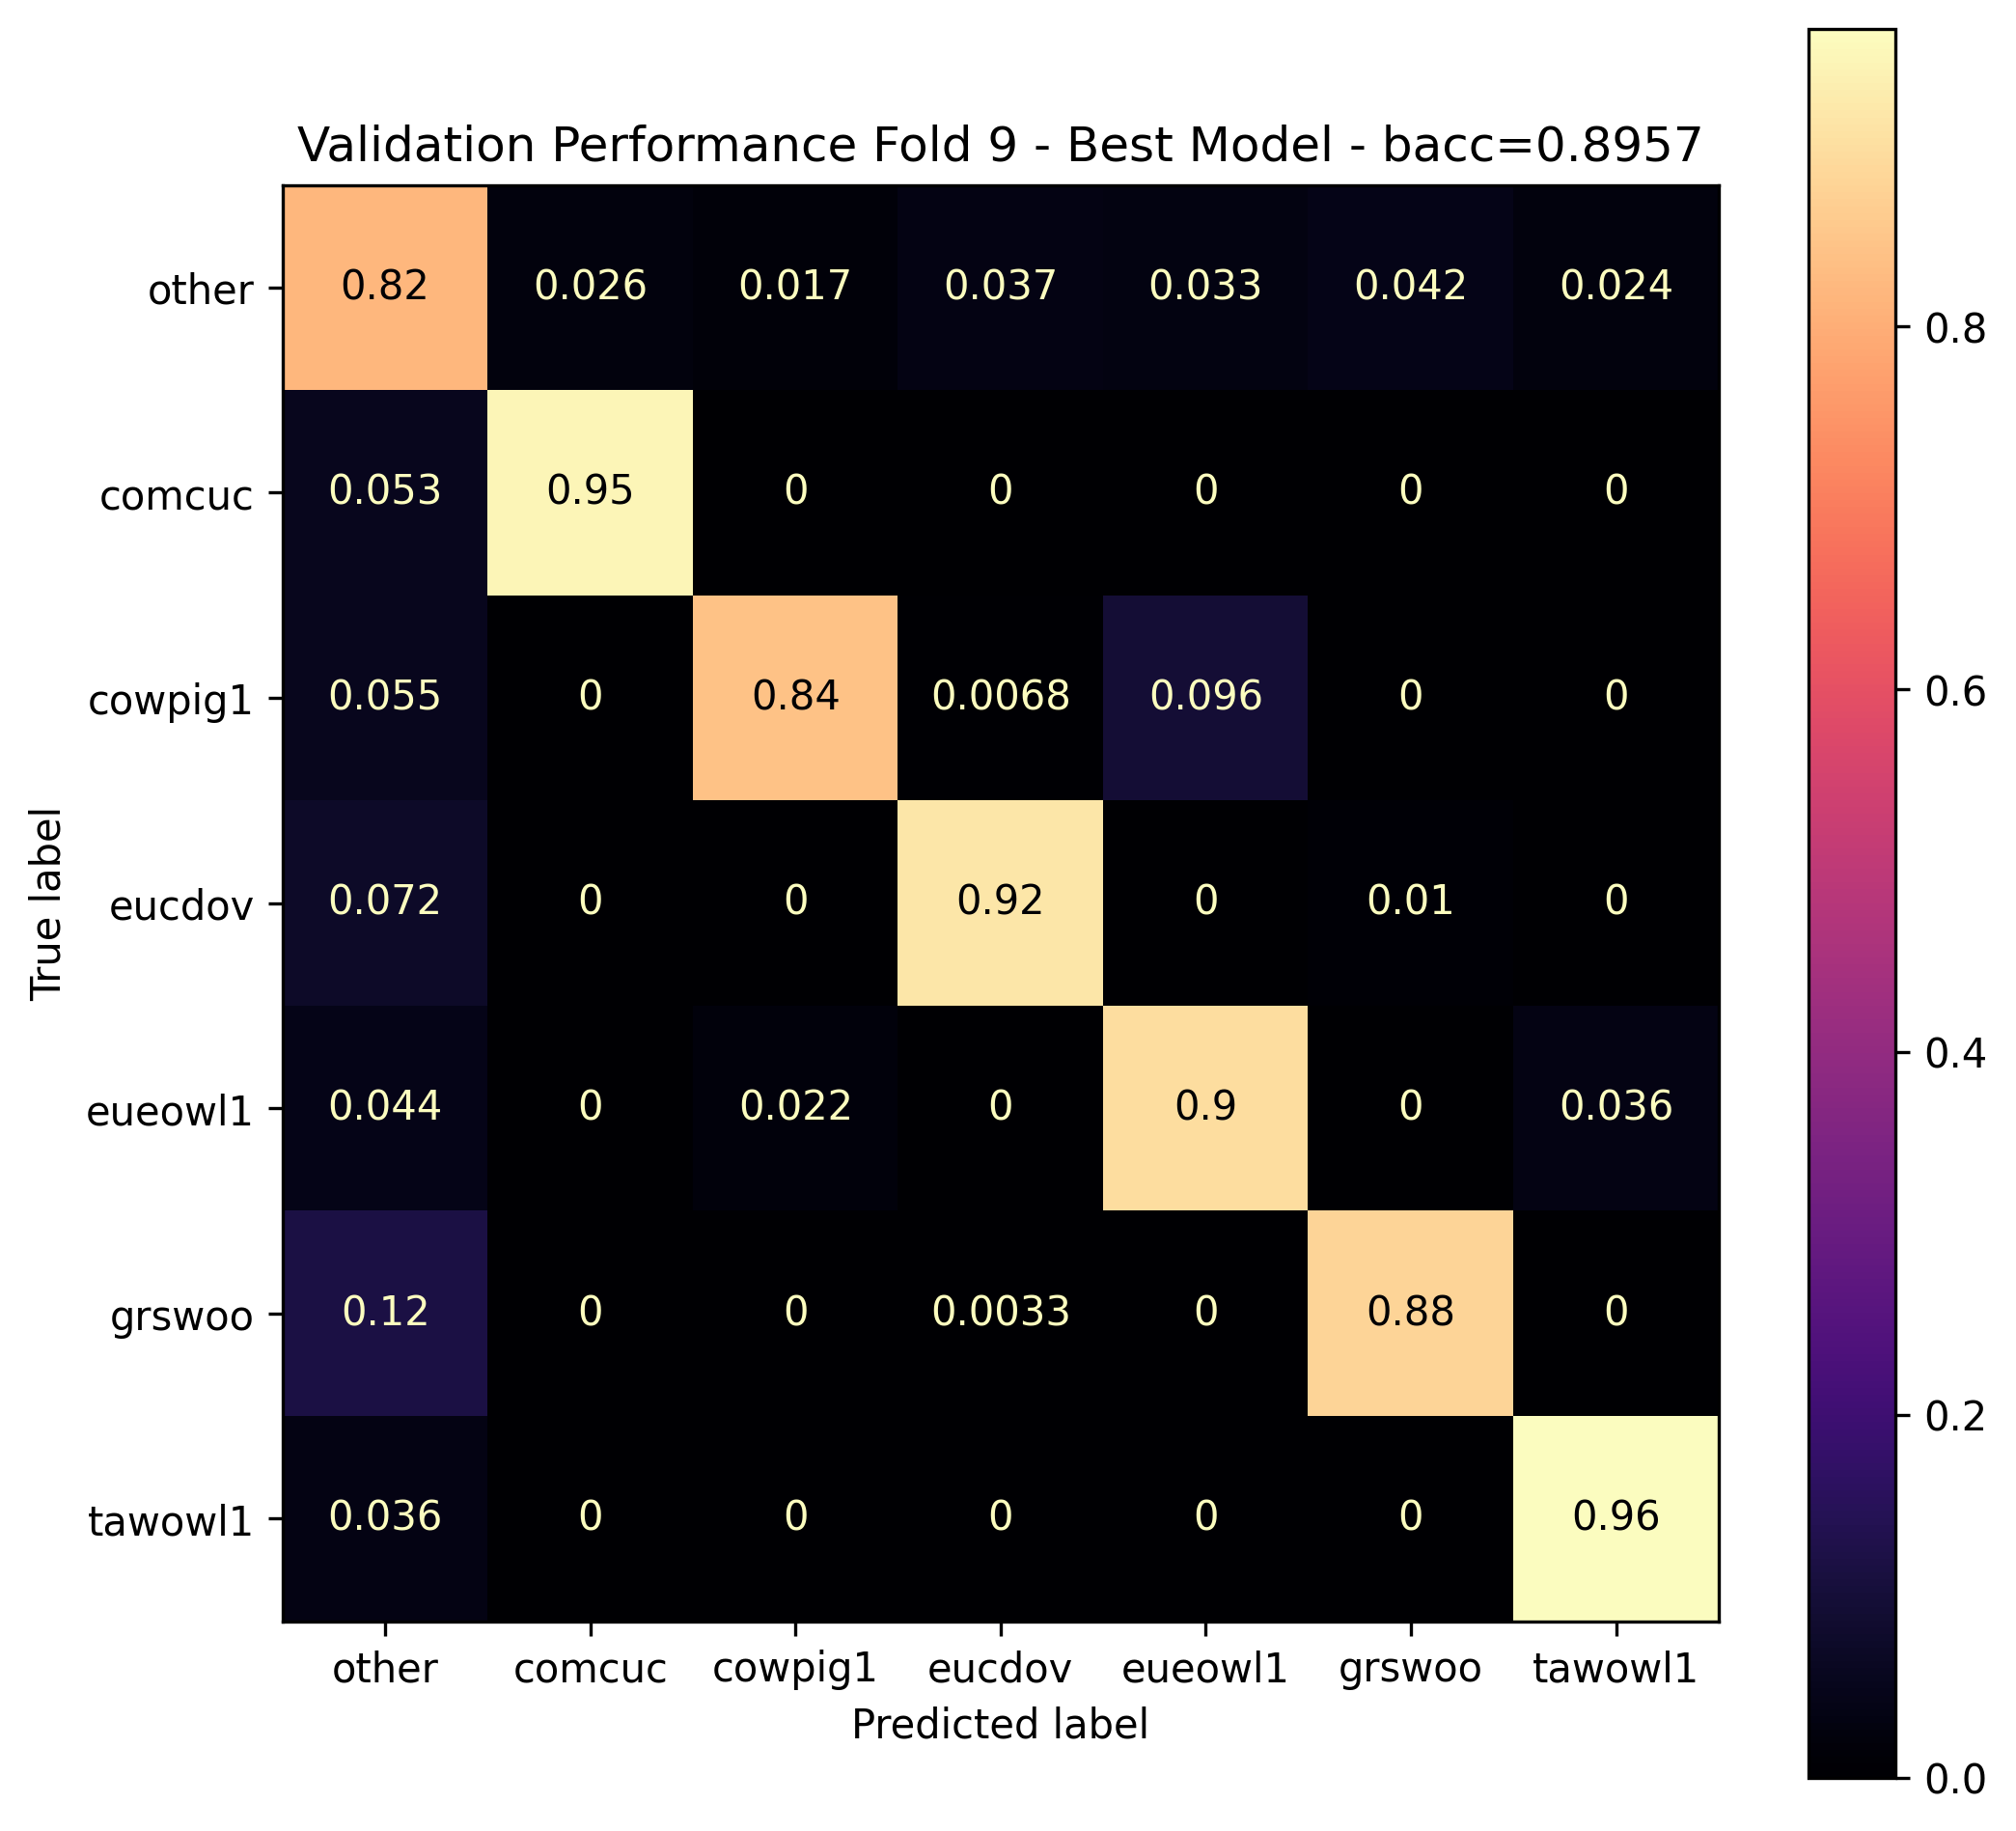

cv_final_epoch_avg_train_metrics      = avg_loss = 0.000021, num_samples = 86400.000000, num_correct = 79363.700000, acc = 0.918561, bacc = 0.979925
cv_final_epoch_avg_evaluation_metrics = avg_loss = 0.002249, num_samples = 9600.000000, num_correct = 8457.400000, acc = 0.880979, bacc = 0.891717


In [52]:
set_random_seed(42)

cv_training_hyper_parameters = create_training_hyper_parameters(
    epoch_multiplier=0.35, 
    lr_multiplier=1
)

cv_models_with_scalers, cv_folds_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    NumpyDataset(data_train, labels_train),
    device,
    cv_folds_permute_seed=42,
    save_models=None
)


## Metrics ##

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_evaluation_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics      = }')
print(f'{cv_final_epoch_avg_evaluation_metrics = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

## Final Train/Test

Training AttentionClassifier with 50643 parameters
train label counts = [68467, 4469, 7319, 6567, 1876, 3817, 3485]
loss weights = [1.0, 15.32, 9.35, 10.43, 36.5, 17.94, 19.65]
eval label counts = [16891, 1364, 1635, 1631, 448, 1294, 737]
eval loss weights = [1.0, 12.38, 10.33, 10.36, 37.7, 13.05, 22.92]
Training Epoch   1/80 : lr = 0.0075, avg_loss = 0.000643, num_samples = 96000, num_correct = 19584, acc = 0.204000, bacc = 0.233113
Evaluation Epoch   1/80 : avg_loss = 0.000605, num_samples = 24000, num_correct =  5383, acc = 0.224292, bacc = 0.176625
Training Epoch   2/80 : lr = 0.0075, avg_loss = 0.000734, num_samples = 96000, num_correct =  9575, acc = 0.099740, bacc = 0.221090
Evaluation Epoch   2/80 : avg_loss = 0.000788, num_samples = 24000, num_correct =   751, acc = 0.031292, bacc = 0.139563
Training Epoch   3/80 : lr = 0.0075, avg_loss = 0.000700, num_samples = 96000, num_correct =  3805, acc = 0.039635, bacc = 0.114401
Evaluation Epoch   3/80 : avg_loss = 0.000742, num_sampl

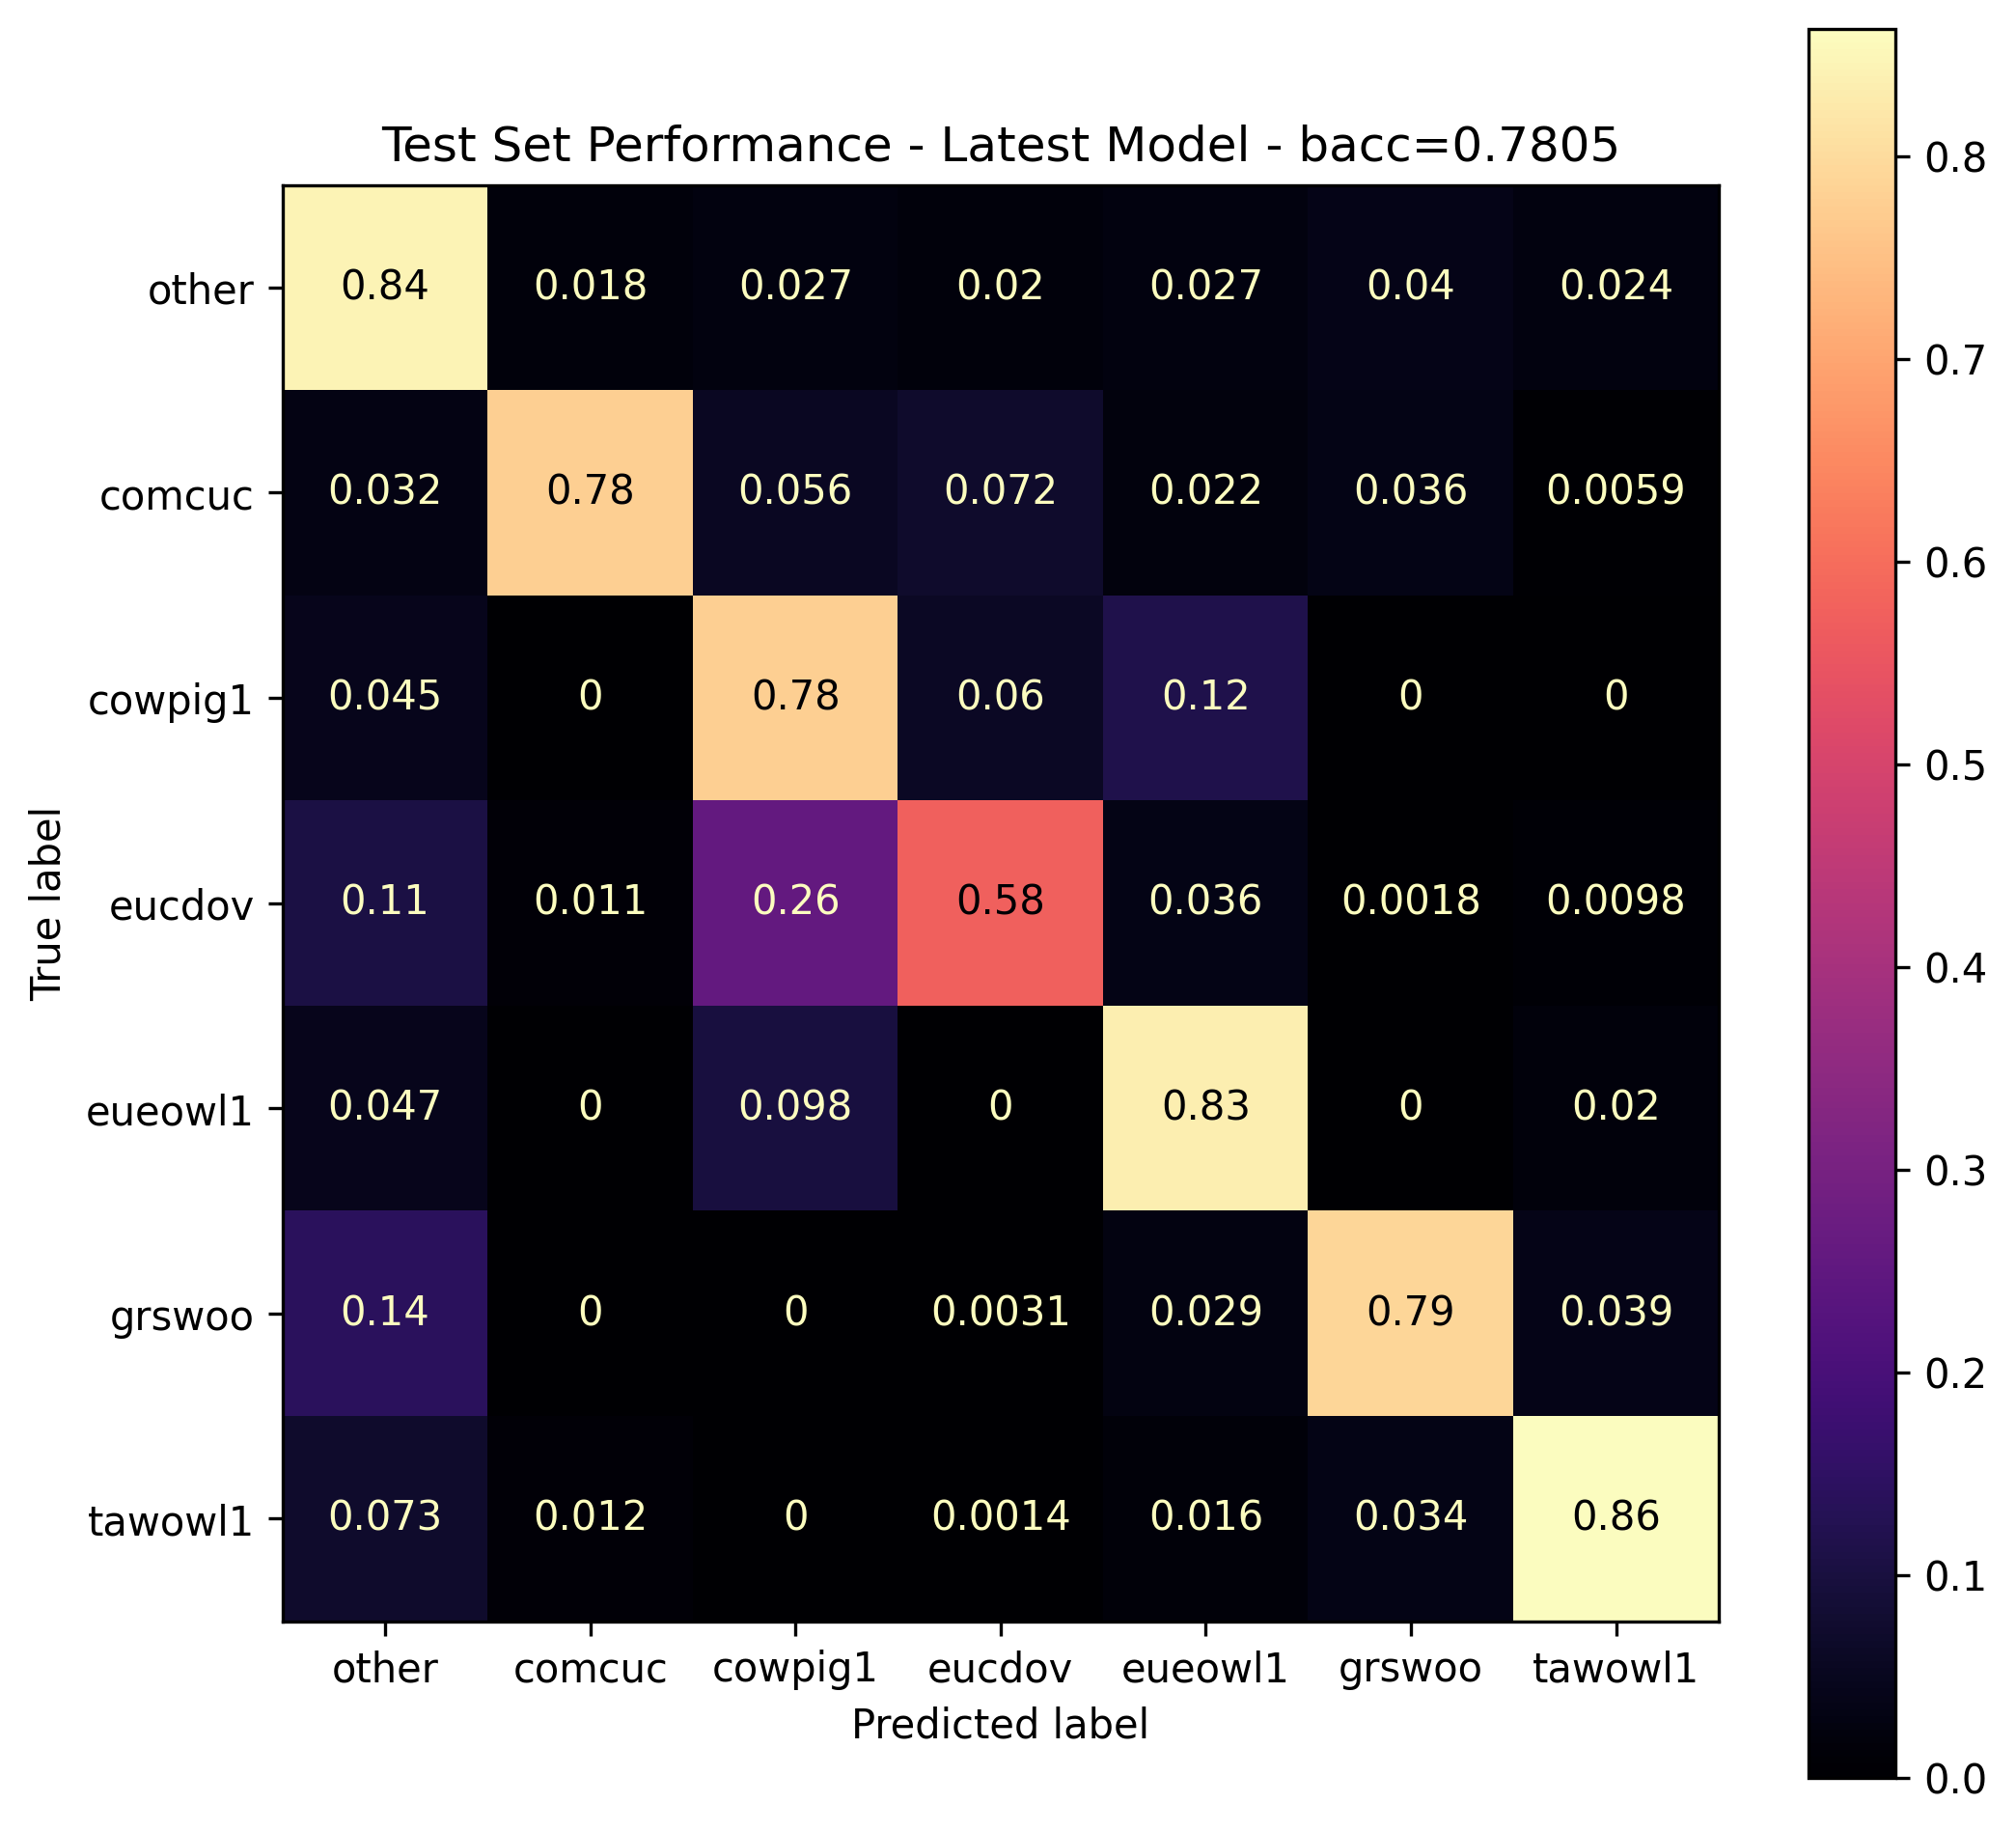

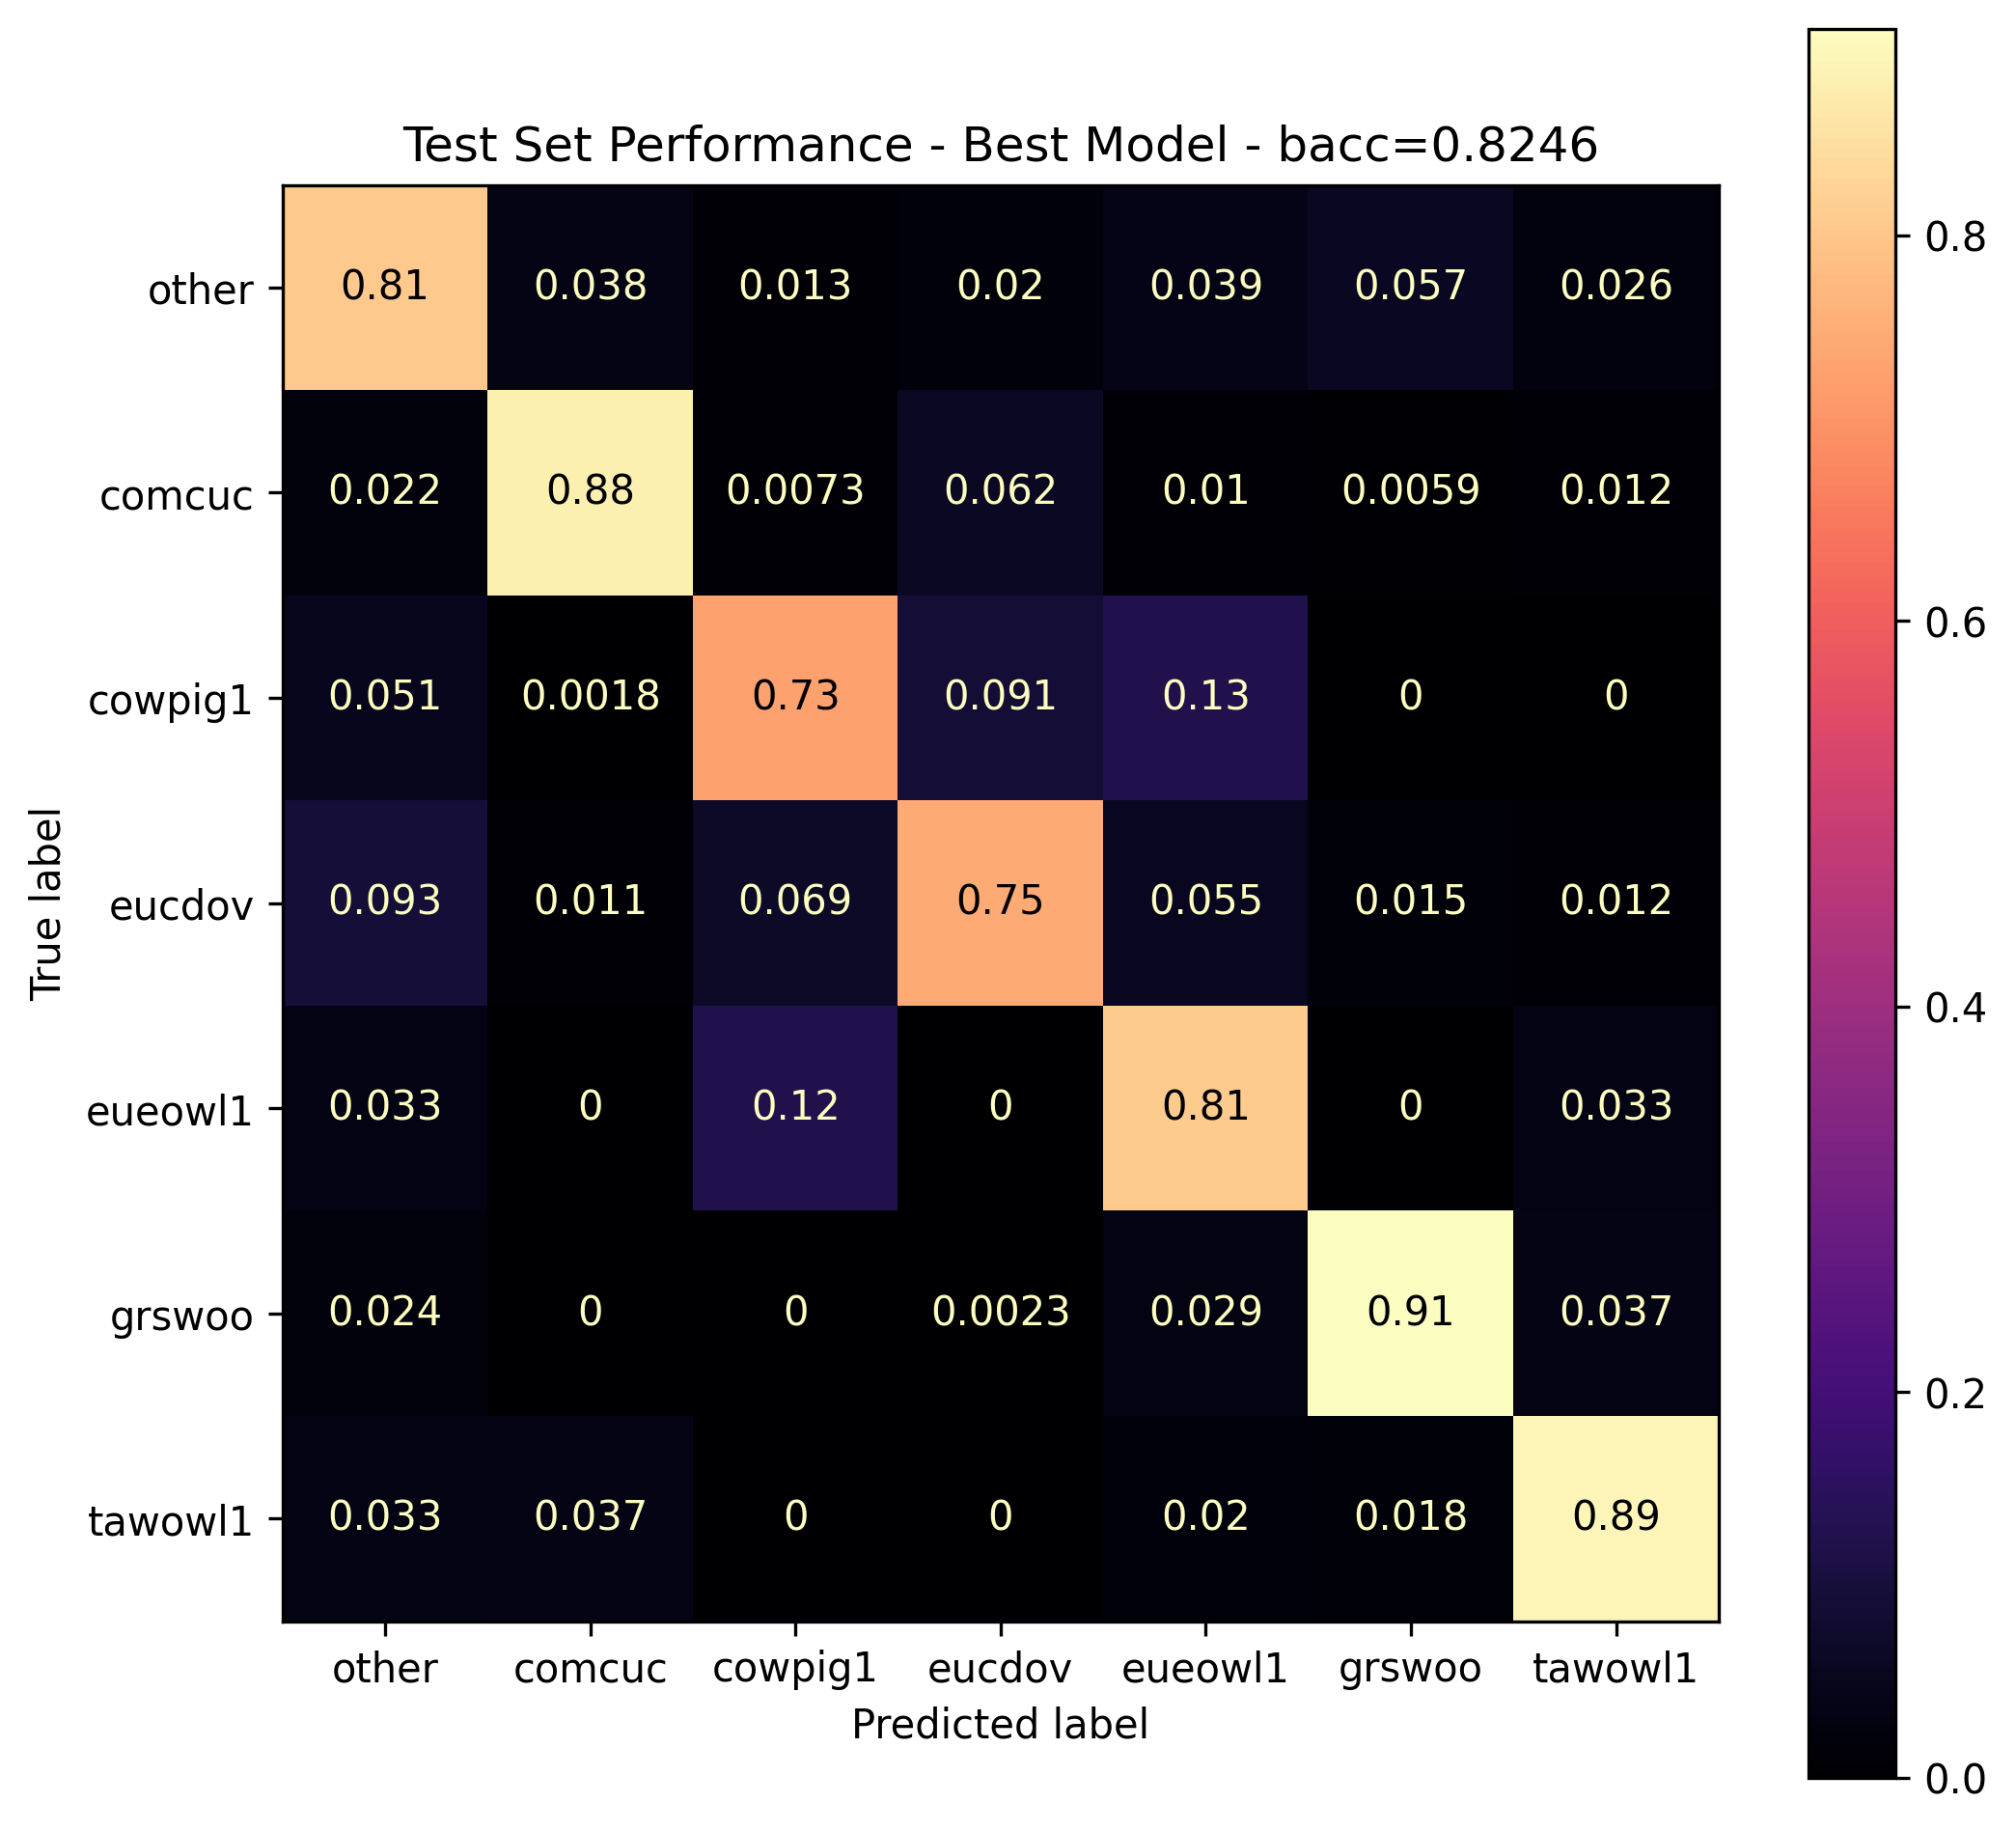

training_run_metrics[-1][0] = avg_loss = 0.000030, num_samples = 96000, num_correct = 86278, acc = 0.898729, bacc = 0.969797
test_metrics_latest_model   = avg_loss = 0.000264, num_samples = 24000, num_correct = 19575, acc = 0.815625, bacc = 0.780541
test_metrics_best_model     = avg_loss = 0.000219, num_samples = 24000, num_correct = 19426, acc = 0.809417, bacc = 0.824582


In [58]:
set_random_seed(42)

final_training_hyper_parameters = create_training_hyper_parameters(
    epoch_multiplier=0.8, 
    lr_multiplier=0.55
)

data_train_normalized, data_test_normalized, normalization_scaler = normalize_data(data_train, data_test)

latest_attention_classifier, training_run_metrics, best_attention_classifier, best_metrics = train_attention_classifier(
    hyper_parameters, 
    final_training_hyper_parameters, 
    NumpyDataset(data_train_normalized, labels_train),
    NumpyDataset(data_test_normalized, labels_test),
    device
)

test_loader = create_data_loader(data_test_normalized, labels_test)

test_metrics_latest_model = evaluate_attention_classifier(
    latest_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Latest Model'
)
test_metrics_best_model = evaluate_attention_classifier(
    best_attention_classifier, 
    test_loader, 
    device, 
    show_confmat=True,
    confmat_title=f'Test Set Performance - Best Model'
)

print(f'{training_run_metrics[-1][0] = }')
print(f'{test_metrics_latest_model   = }')
print(f'{test_metrics_best_model     = }')

# Plots

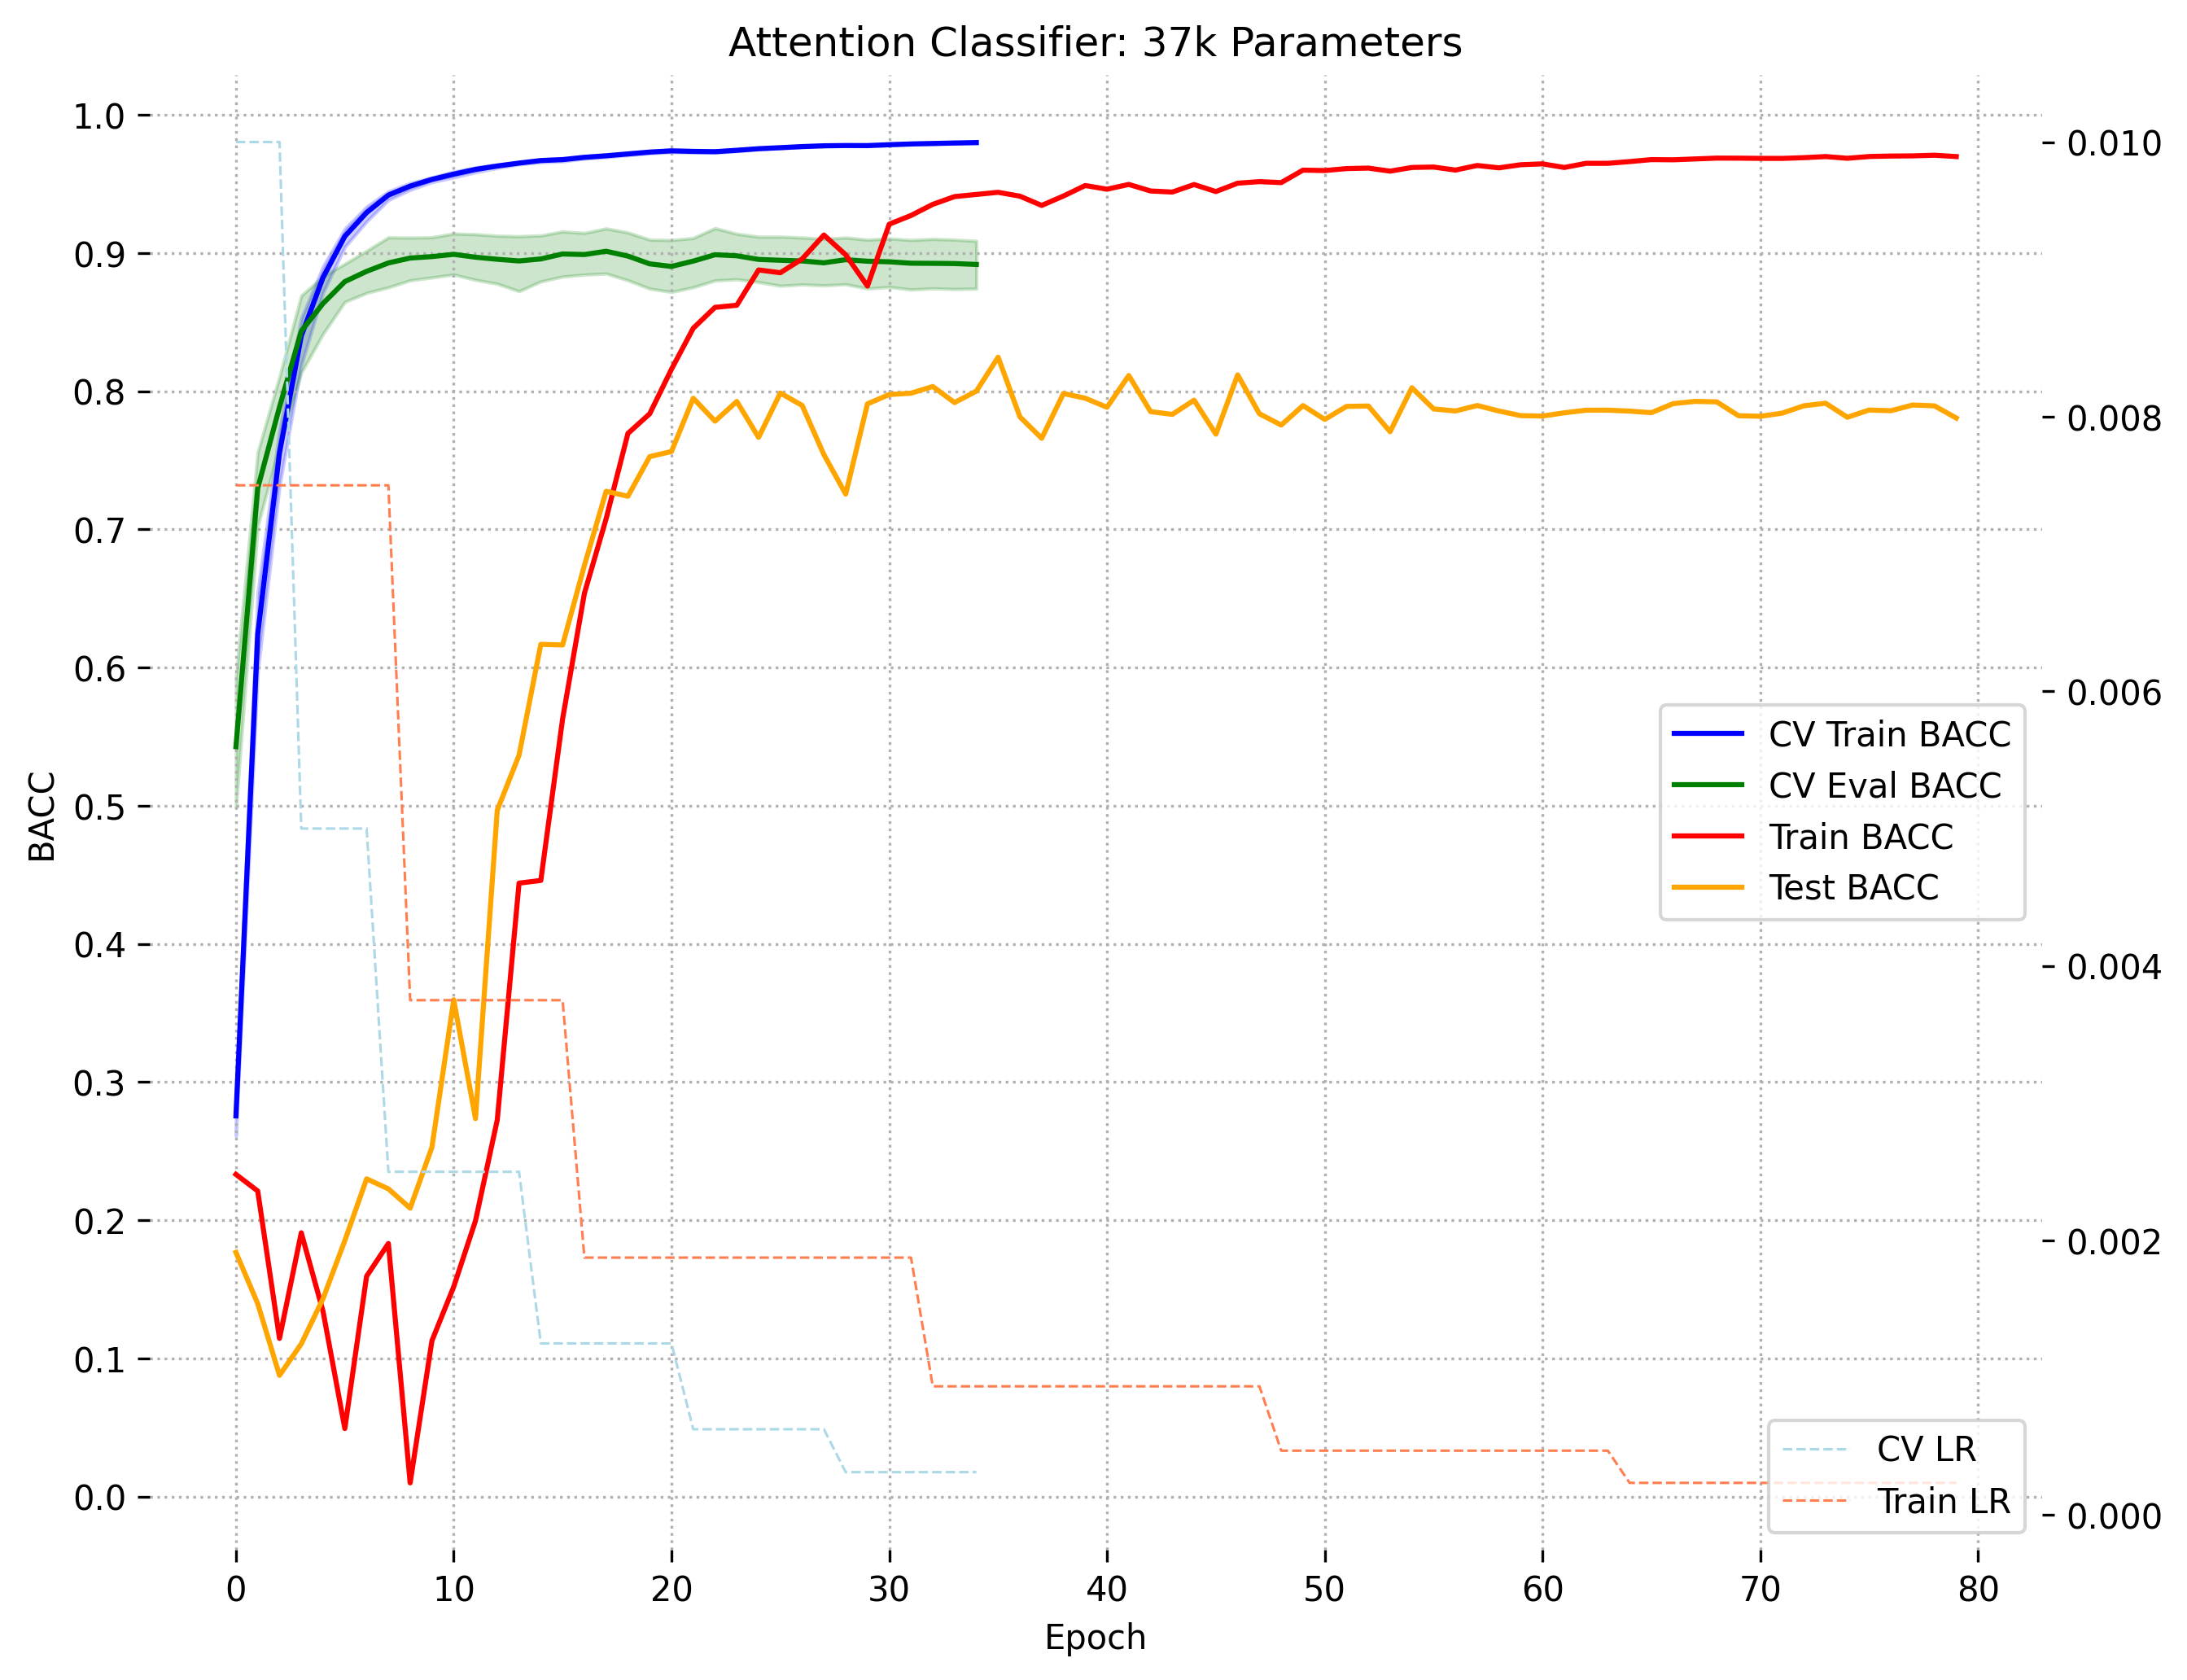

In [59]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    final_train_epoch_range = np.arange(0, final_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])

    ax.plot(final_train_epoch_range, list(map(lambda m: m[0].bacc, training_run_metrics)), label='Train BACC', c='red')
    ax.plot(final_train_epoch_range, list(map(lambda m: m[1].bacc, training_run_metrics)), label='Test BACC', c='orange')
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)
    twin_ax.plot(final_train_epoch_range, create_lrs_over_epochs(final_training_hyper_parameters), label='Train LR', c='coral', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

plot_baccs_over_epochs('Attention Classifier: 37k Parameters')